<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [822]:
import pandas as pd
import numpy as np
import sklearn as sk

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from mpl_toolkits.mplot3d import Axes3D

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Lectura de archivo

### Desde google drive

In [823]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"
file_path = drive_path + '/Dataset/properati_argentina_2021.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'
df = pd.read_csv(file_path)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [824]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# file_path = './dataset/properati_argentina_2021.csv'
# barrios_file = './dataset/barrios.csv'
# df = pd.read_csv(file_path)
# using_drive = False

In [825]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

In [826]:
df.shape

(460154, 20)

# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




## Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [827]:
df["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [828]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [829]:
df["place_l2"].value_counts().head() # Hay muchas ubicaciones

place_l2
Capital Federal             157563
Bs.As. G.B.A. Zona Norte     89693
Santa Fe                     47861
Bs.As. G.B.A. Zona Sur       47754
Bs.As. G.B.A. Zona Oeste     28352
Name: count, dtype: int64

In [830]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [831]:
df["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [832]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [833]:
df["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [834]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [835]:
# DataSet filtrado
ds_propiedades_filtradas.head()

id  start_date    end_date  created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg==  2021-09-09  2021-09-26  2021-09-09        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw==  2021-09-09  2022-03-09  2021-09-09 -34.631621   

     longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
25        NaN  Capital Federal      NaN      NaN      NaN       NaN     Venta   
42 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
43 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
49 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   
51 -58.416825  Capital Federal    Boedo      NaN      NaN       NaN     Venta   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   

    property_surface_covered  property_price property_currency  \
25                     133.0        210000.0               USD   
42                      55.0         82900.0               USD   
43                      70.0         99000.0               USD   
49                     104.0        146000.0               USD   
51                      73.0        250000.0               USD   

                                 property_title  
25  VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42       VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43   Departamento - 4 Ambientes - Catalinas Sur  
49          Venta departamento 4 ambientes Once  
51                                   PH - Boedo

In [836]:
ds_propiedades_filtradas.shape

(94249, 20)

## Exploración Inicial

### Medidas de resumen de las variables cuantitativas del Dataset

In [837]:
# Creo resumen con describe
ds_resumen = ds_propiedades_filtradas.describe()
# Agrego moda a la tabla resumen
ds_resumen.loc['mode'] = ds_propiedades_filtradas.mode().iloc[0]
ds_resumen


latitud      longitud  place_l6  property_rooms  \
count  90519.000000  90519.000000       0.0    93205.000000   
mean     -34.591481    -58.449795       NaN        2.822799   
std        0.181719      0.292630       NaN        1.426148   
min      -53.788624    -71.471192       NaN        1.000000   
25%      -34.615975    -58.466522       NaN        2.000000   
50%      -34.595790    -58.439000       NaN        3.000000   
75%      -34.577413    -58.408862       NaN        4.000000   
max      -24.219827    -54.133330       NaN       40.000000   
mode     -34.541250    -58.472966       NaN        3.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       83262.000000            89405.000000              90895.000000   
mean            2.014629              109.092970                 87.931932   
std             1.129767              980.401976                990.927129   
min            -1.000000               10.000000                  1.000000   
25%             1.000000               45.000000                 40.000000   
50%             2.000000               65.000000                 58.000000   
75%             3.000000              105.000000                 88.000000   
max            70.000000           137000.000000             217000.000000   
mode            1.000000               50.000000                 40.000000   

       property_price  
count    9.424900e+04  
mean     2.262382e+05  
std      3.186035e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.439000e+05  
75%      2.370000e+05  
max      2.140000e+07  
mode     1.100000e+05

En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

Tambien se pueden ver algunos valores atipicos como el hecho que hay alguna propiedad con 36 ambientes y 32 habitaciones, o -1 habitaciones, o tambien el minimo de las longitudes que pareciera estar fuera de CABA. Estos seran abarcados en su correspondiente seccion (valores atipicos).

### Cantidad de valores posibles para cada variable cualitativo

In [838]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
ds_propiedades_filtradas[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             607
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

**Notar que las columnas place l5 y l6 son completamente nulas, retomaremos eso mas adelante**

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

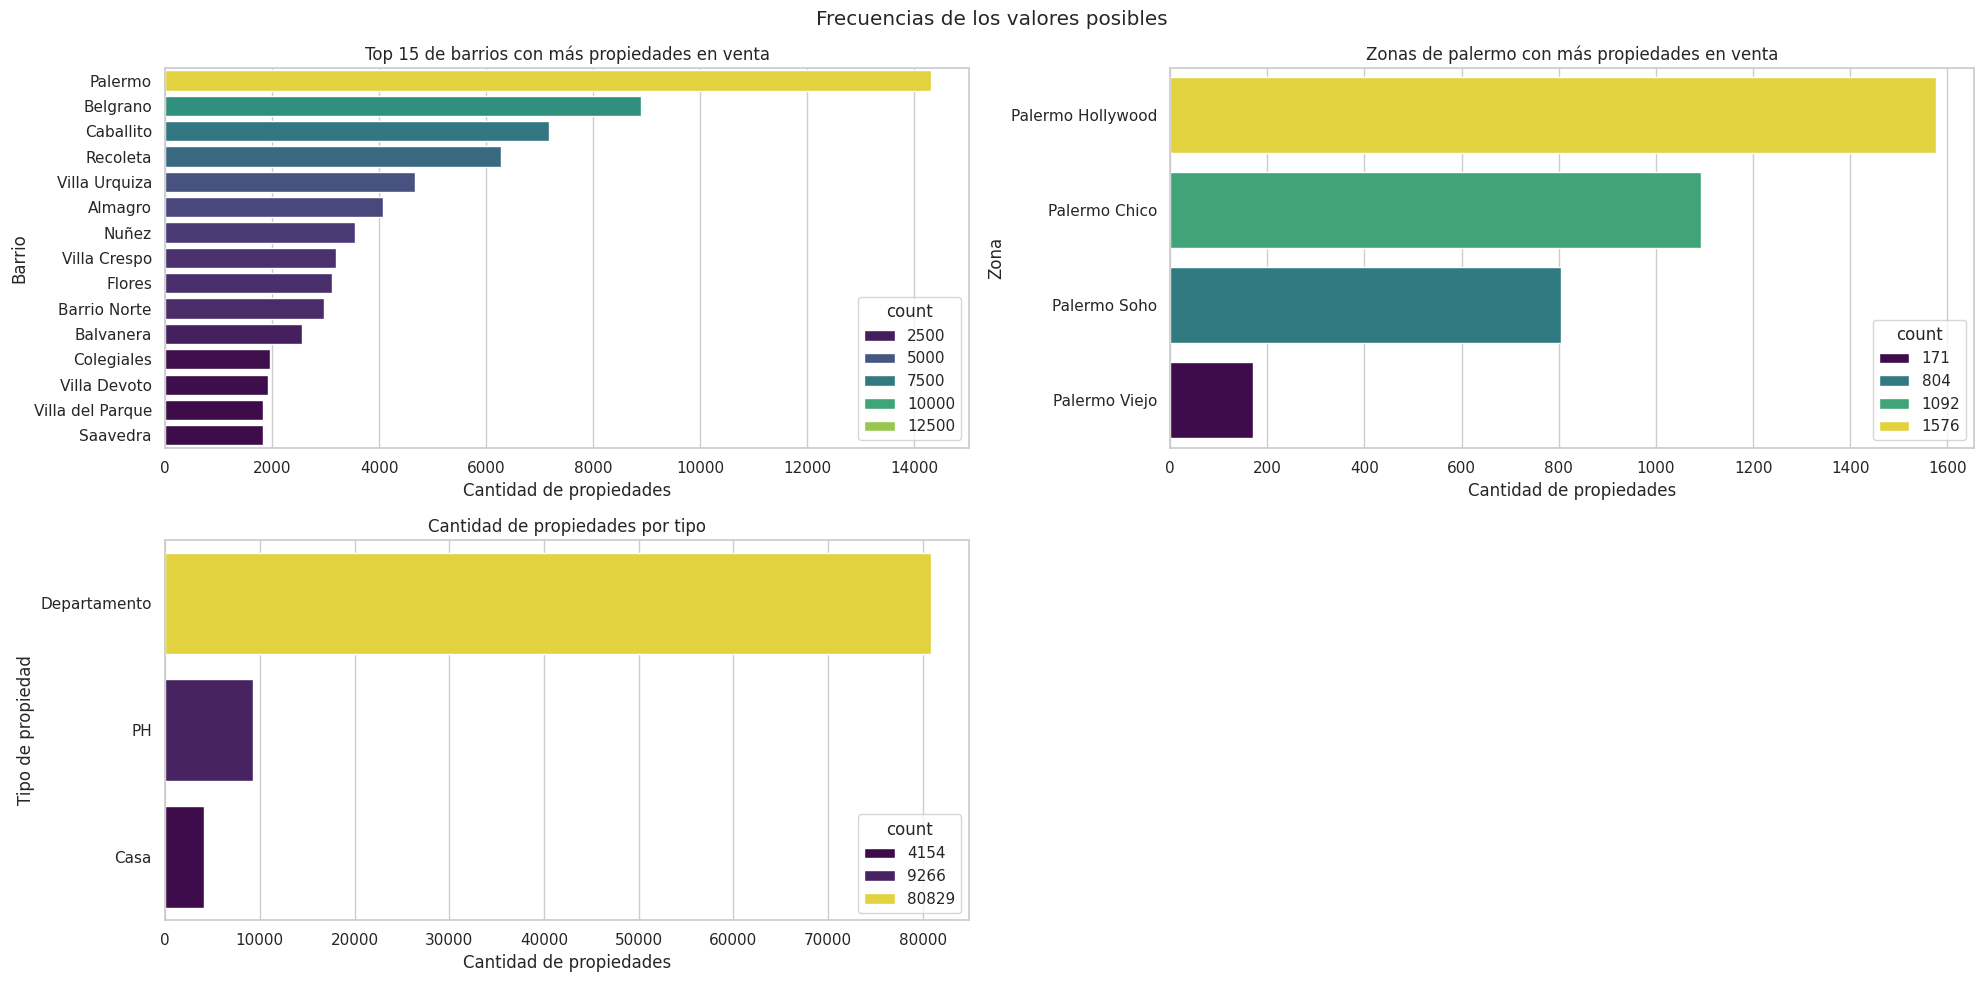

In [839]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_propiedades_filtradas["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_propiedades_filtradas["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_propiedades_filtradas["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

plt.tight_layout()
plt.show()

*Anotacion: todos los place_l4 que no son NaN son zonas de palermo.*

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l2**: siempre son capital federal debido al primer filtro
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan/se crean, de lo contrario no es relevante.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l2
* place_l5/l6 (se abordara en la seccion de datos faltantes)
* operation
* property_currency
* property title

In [840]:
# Nuevo filtro para eliminar dichas columnas
columnas_a_eliminar = ['place_l2', 'operation', 'property_currency', 'property_title']
ds_propiedades_filtradas.drop(columns = columnas_a_eliminar,inplace=True)

### Analisis grafico de distribucion de variables mas relevantes

* distribucion de precios
* distribucion de publicaciones por mes
* distribucion de habitaciones y dormitorios

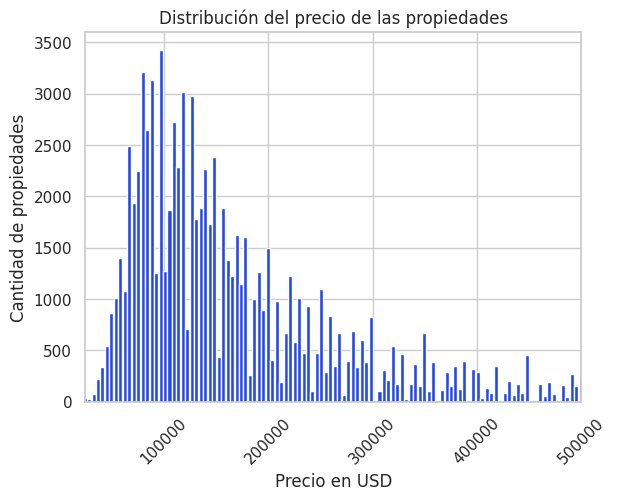

In [841]:
# plot de distribucion de property_price

plt.hist(data=ds_propiedades_filtradas,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)

plt.show()

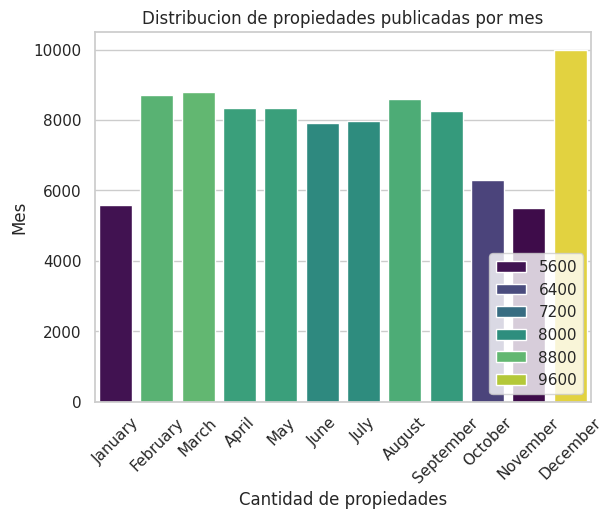

In [842]:
# bar plot distribucion de ventas por mes

ds_propiedades_filtradas["created_on"] = pd.to_datetime(ds_propiedades_filtradas["created_on"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = ds_propiedades_filtradas["created_on"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='lower right')
plt.title('Distribucion de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.show()

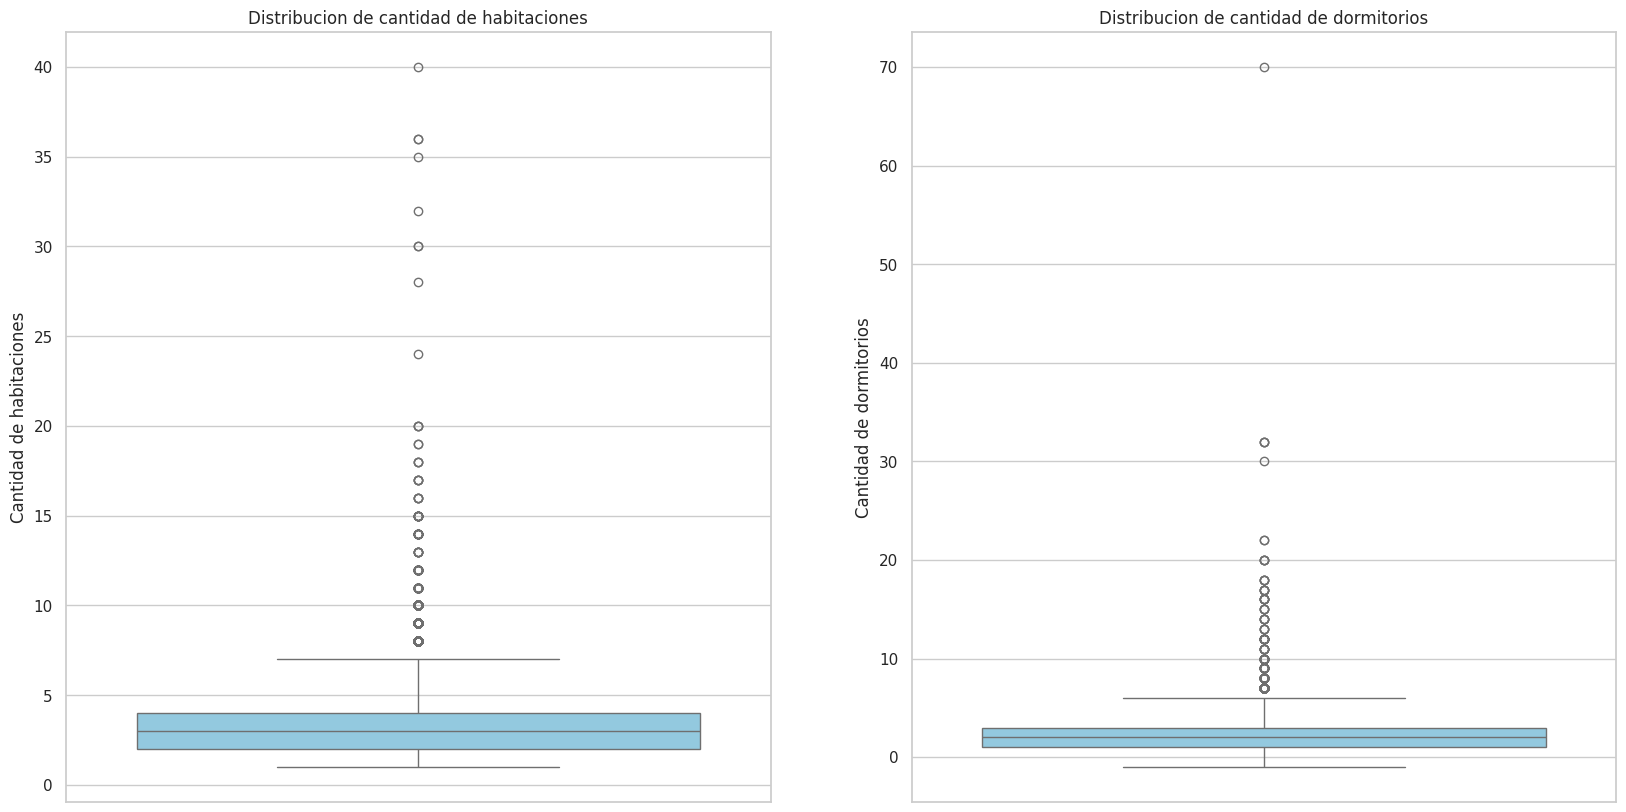

In [843]:
# Boxplot de property_rooms y property_bedrooms
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1 posicion
sns.boxplot(data=ds_propiedades_filtradas, y='property_rooms', color='skyblue')
plt.title('Distribucion de cantidad de habitaciones')
plt.ylabel('Cantidad de habitaciones')

plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2 posicion
sns.boxplot(data=ds_propiedades_filtradas, y='property_bedrooms', color='skyblue')
plt.title('Distribucion de cantidad de dormitorios')
plt.ylabel('Cantidad de dormitorios')

plt.show()

### Analisis de correlaciones existentes entre variables

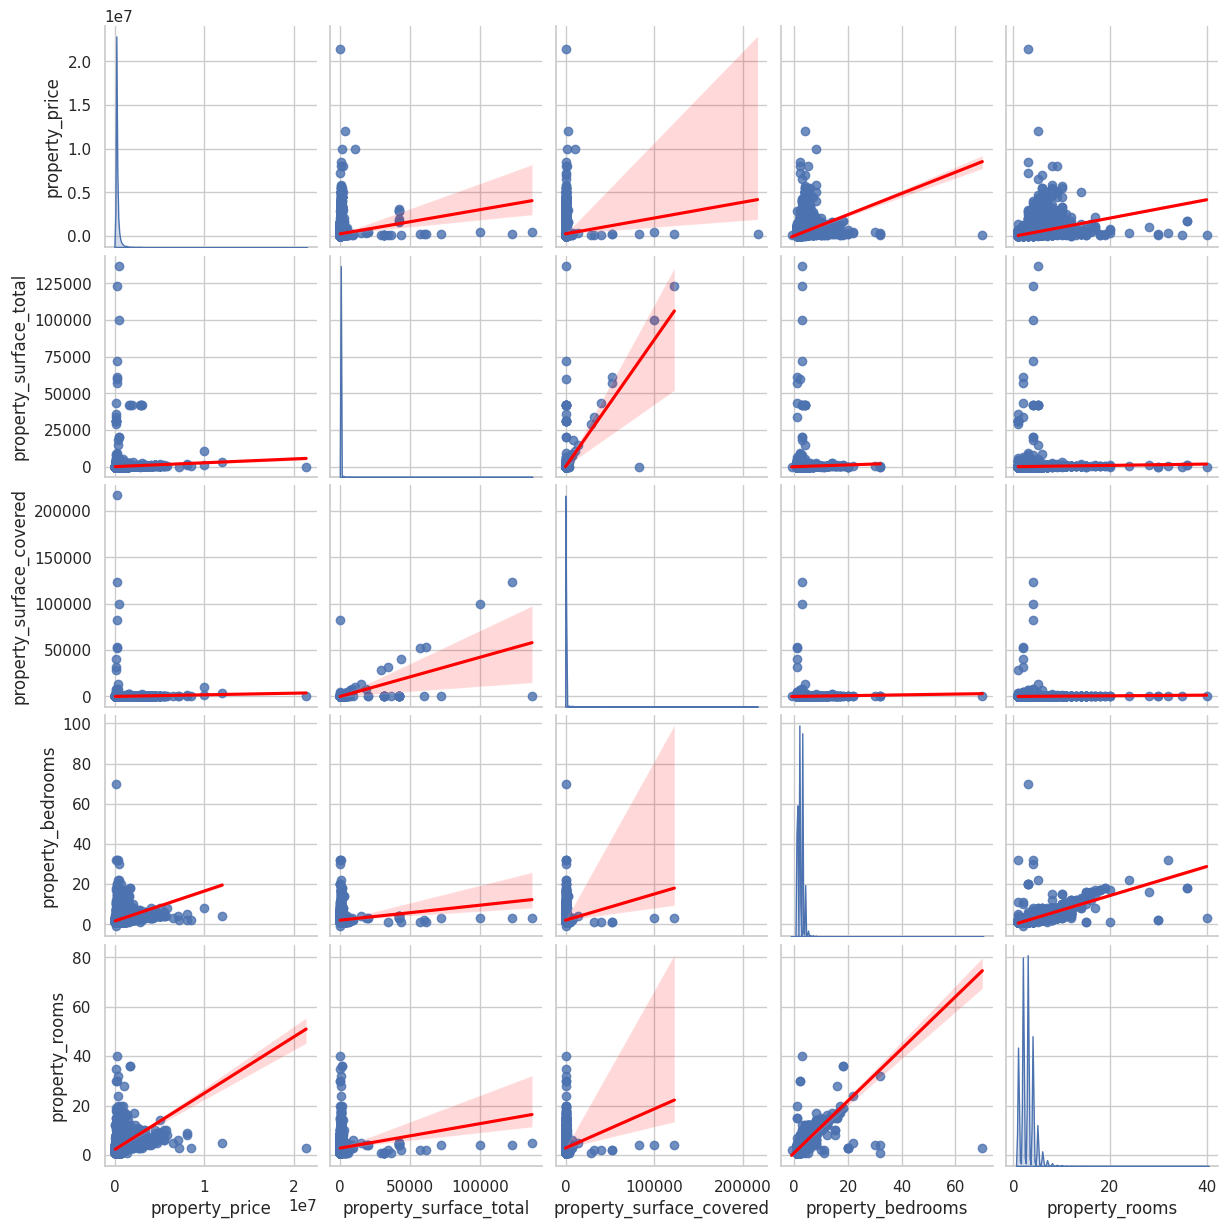

In [844]:
# pairplot con price, surface_total, surface_covered, bedrooms, rooms
sns.pairplot(ds_propiedades_filtradas[['property_price', 'property_surface_total', 'property_surface_covered', 'property_bedrooms', 'property_rooms']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

Observando este grafico de relaciones se pueden ver que algunas de estas variables tienen claramente una relacion y otras no tanto.

* La relacion entre la **superficie total** y **superficie cubierta** es lineal y acendente, es decir da la impresion que una dependiera de la otra, y si se piensa logicamente esto tiene sentido (si hay mas espacio se cubre mas espacio) aunque no siempre es necesariamente el caso (puede haber una casa pequeña en un terreno grande)
* La relacion entre el **precio** y la cantidad de **habitaciones** y **dormitorios**, en esta se puede notar que a mas habitaciones y/o dormitorios mas aumenta el maximo precio pero no deja de haber precios mas bajos, sin embargo, pasada una cierta cantidad (aproximadamente ~15) el precio deja de aumentar y mas bien se queda constante (entre los valores hasta ~250,000 USD)
* La relacion entre **habitaciones** y **dormitorios** tambien es lineal y acendente, lo cual puede deberse a que cuando una casa tiene muchas habitaciones esta probablemente tenga tambien muchos dormitorios.

*Extra: hay ciertos valores outliers que pueden afectar a la correlacion entre variables por ejemplo una propiedad con mas de 60 habitaciones, estos seran analizados en la seccion de valores atipicos*

Para hacer un analisis mas profundo de estos datos se analiza la *covarianza* y *correlacion* entre las variables usadas en la figura anterior:

In [845]:
# covarianza y correlacion entre property_surface_total y property_surface_covered
covariance = ds_propiedades_filtradas['property_surface_total'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_surface_total'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Surface Total vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_rooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_rooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_rooms'])
print(f'Price vs Rooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_bedrooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Price vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_total
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_total'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_total'])
print(f'Price vs Surface Total\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_covered
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Price vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre property_rooms y property_bedrooms
covariance = ds_propiedades_filtradas['property_rooms'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_rooms'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Rooms vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

Surface Total vs Surface Covered
Covariance: 422567.93 & Correlation: 0.60

Price vs Rooms
Covariance: 213915.99 & Correlation: 0.49

Price vs Bedrooms
Covariance: 155132.09 & Correlation: 0.43

Price vs Surface Total
Covariance: 26682797.26 & Correlation: 0.09

Price vs Surface Covered
Covariance: 17771425.78 & Correlation: 0.06

Rooms vs Bedrooms
Covariance: 1.31 & Correlation: 0.87



Esto nos dice que en efecto lo previamente observado era el caso. Tambien ahora gracias a este analisis se ve que las relaciones mas debiles son las dadas entre el precio y las superficies totales/cubiertas.

## Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


In [846]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
prop_train, prop_test = train_test_split(ds_propiedades_filtradas, train_size=0.8, random_state=42) # random state para usar misma semilla siempre
print("Propiedades para entrenar:", len(prop_train))
print("Propiedades para testear:", len(prop_test))

Propiedades para entrenar: 75399
Propiedades para testear: 18850


## Visualización de los datos

In [847]:
# Crear una copia del DataFrame original prop_train
visu_prop_train = prop_train.copy()

# Aplicar el filtro por la columna 'property_rooms' < 6 en la copia
visu_prop_train = visu_prop_train[visu_prop_train['property_rooms'] < 6]

# Filtrar propiedades con precios entre 20,000 y 500,000
visu_prop_train = visu_prop_train[(visu_prop_train['property_price'] > 20000) &
                             (visu_prop_train['property_price'] < 500000)]

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_prop_train.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

df_visu

#Modificamos un rango para que se vea mejor la visualizacion

property_rooms                  1.0            2.0            3.0  \
place_l3                                                            
Abasto                 67343.617021   94723.618182  122465.886364   
Agronomía              73533.545455   99982.586957  167868.888889   
Almagro                76574.348797   96930.285441  140616.519442   
Balvanera              66309.678977   78418.137221  116856.502415   
Barracas               85206.463768  107908.159836  153942.518634   
Barrio Norte           96118.994681  115590.284178  193241.438333   
Belgrano              103711.295082  144506.920173  216215.036269   
Boca                   64224.977273   67662.087912   97143.642857   
Boedo                  70250.775194   90347.449686  134483.344615   
Caballito              85092.671091  110929.662708  165566.482103   
Catalinas              50500.000000            NaN  128500.000000   
Centro / Microcentro   61297.500000   80578.947368  114428.571429   
Chacarita              84050.260870  109618.166667  175968.153333   
Coghlan                85576.488095  126124.177215  197609.439394   
Colegiales             88335.533597  129194.145089  191045.576674   
Congreso               65722.449541   80559.221311  118104.172727   
Constitución           59199.834862   67907.485981   94887.777778   
Flores                 71349.604000   90788.834921  131844.743191   
Floresta               66650.504202   85877.119565  129961.945652   
Las Cañitas           110000.000000  213166.666667            NaN   
Liniers                63022.690476   87584.353659  136395.704225   
Mataderos              65977.280000   90283.846154  135945.334951   
Monserrat              75411.449275   84519.366071  118468.466960   
Monte Castro           79070.708333   99830.813084  152114.166667   
Nuñez                 101804.701794  141623.988134  211171.501801   
Once                   51805.000000   74794.444444  117785.840708   
Palermo               104638.992335  149006.078995  237215.677820   
Parque Avellaneda      69171.428571   82014.814815  115793.684211   
Parque Centenario      81158.333333  107439.240000  145020.000000   
Parque Chacabuco       77319.027273   96737.940092  140601.086142   
Parque Chas            78944.202532  107847.431818  174004.202703   
Parque Patricios       67301.315789   90166.939130  107953.600000   
Paternal               75588.530864   90655.521429  129843.166667   
Pompeya                47090.000000   59946.633333   94988.135593   
Puerto Madero         247762.174419  328986.705696  409225.800000   
Recoleta               98662.198300  126931.080935  227002.182896   
Retiro                 95863.037037  100344.101266  178201.037736   
Saavedra               93672.834375  118110.140476  189960.837270   
San Cristobal          63498.079498   77791.327402  112922.192429   
San Nicolás            60324.554839   79543.885993  115052.290816   
San Telmo              81715.020134  102790.068182  138915.541353   
Tribunales             62246.000000   94311.111111  110199.458333   
Velez Sarsfield        68550.000000   88930.576923  146277.586207   
Versalles              79583.333333  105703.442623  158013.333333   
Villa Crespo           81749.458333  106259.615776  154040.042292   
Villa Devoto           92520.043860  113487.244898  179546.951311   
Villa General Mitre    70370.720930   87981.732673  131088.181818   
Villa Lugano           68228.000000   86945.606061   90830.677725   
Villa Luro             73316.901408   94099.809524  137173.557692   
Villa Ortuzar          77804.113043  100516.185629  183195.491525   
Villa Pueyrredón       79869.990654  111454.553398  158905.720930   
Villa Real             81500.000000  101883.333333  138265.789474   
Villa Riachuelo                 NaN   89666.666667   96500.000000   
Villa Santa Rita       75782.433333   96778.977273  139948.351351   
Villa Soldati                   NaN            NaN   84647.058824   
Villa Urquiza          90983.315549  124685.383915  190657.435609  

Text(70.93749999999999, 0.5, 'Zonas de Capital Federal')

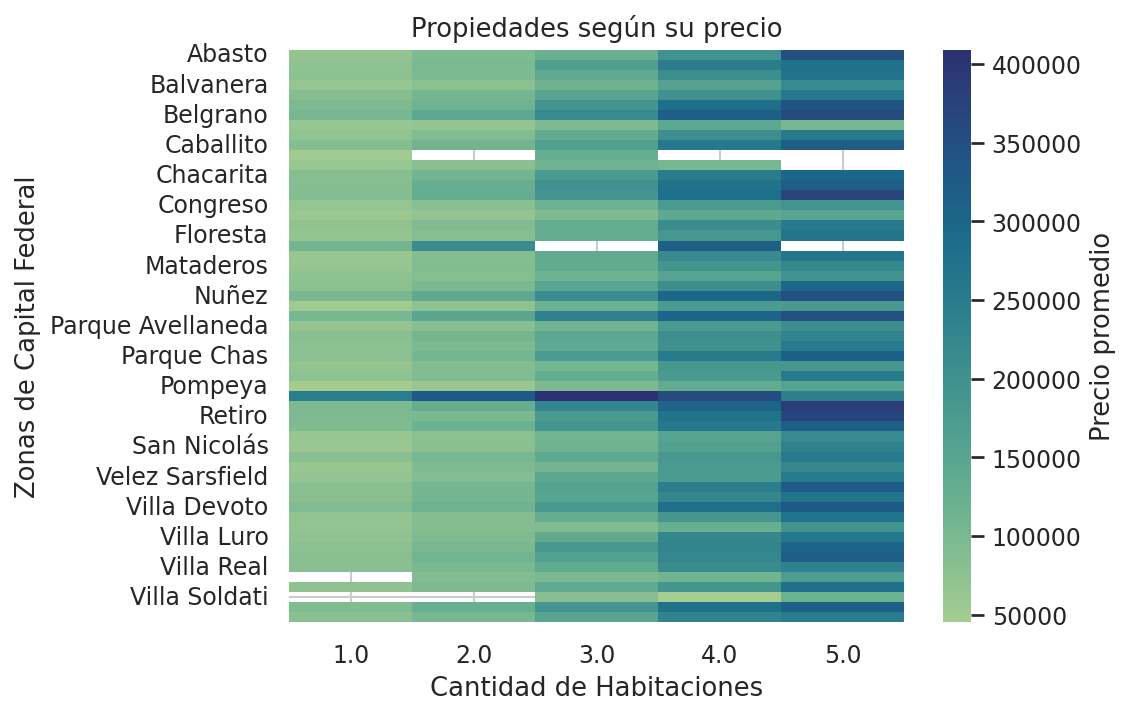

In [848]:
# Nueva figura con un dpi de 155 para mejorar la calidad de la visualización
plt.figure(dpi=155)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, square=False, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Establecer etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")

# Heatmap que muestra el precio promedio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicación

La visualización presentada es un mapa de calor (heatmap) que muestra el precio promedio de las propiedades en función de la cantidad de habitaciones y su ubicación en diferentes zonas de la Ciudad Autónoma de Buenos Aires (CABA). Al observar el heatmap, es posible identificar patrones en los precios según la ubicación y el tamaño de la propiedad. Por ejemplo, puede haber áreas donde las propiedades con más habitaciones tienden a tener precios más altos, mientras que en otras zonas los precios son más uniformes independientemente del tamaño de la propiedad.La visualización proporciona una manera efectiva de entender cómo se relacionan el precio promedio de las propiedades, la cantidad de habitaciones y la ubicación en diferentes áreas de la Ciudad Autónoma de Buenos Aires. Ayuda a los interesados a tomar decisiones informadas sobre la compra o inversión en propiedades en la ciudad.

VERSION MEJORADA: POR CORRECCION DEL PROFE

---


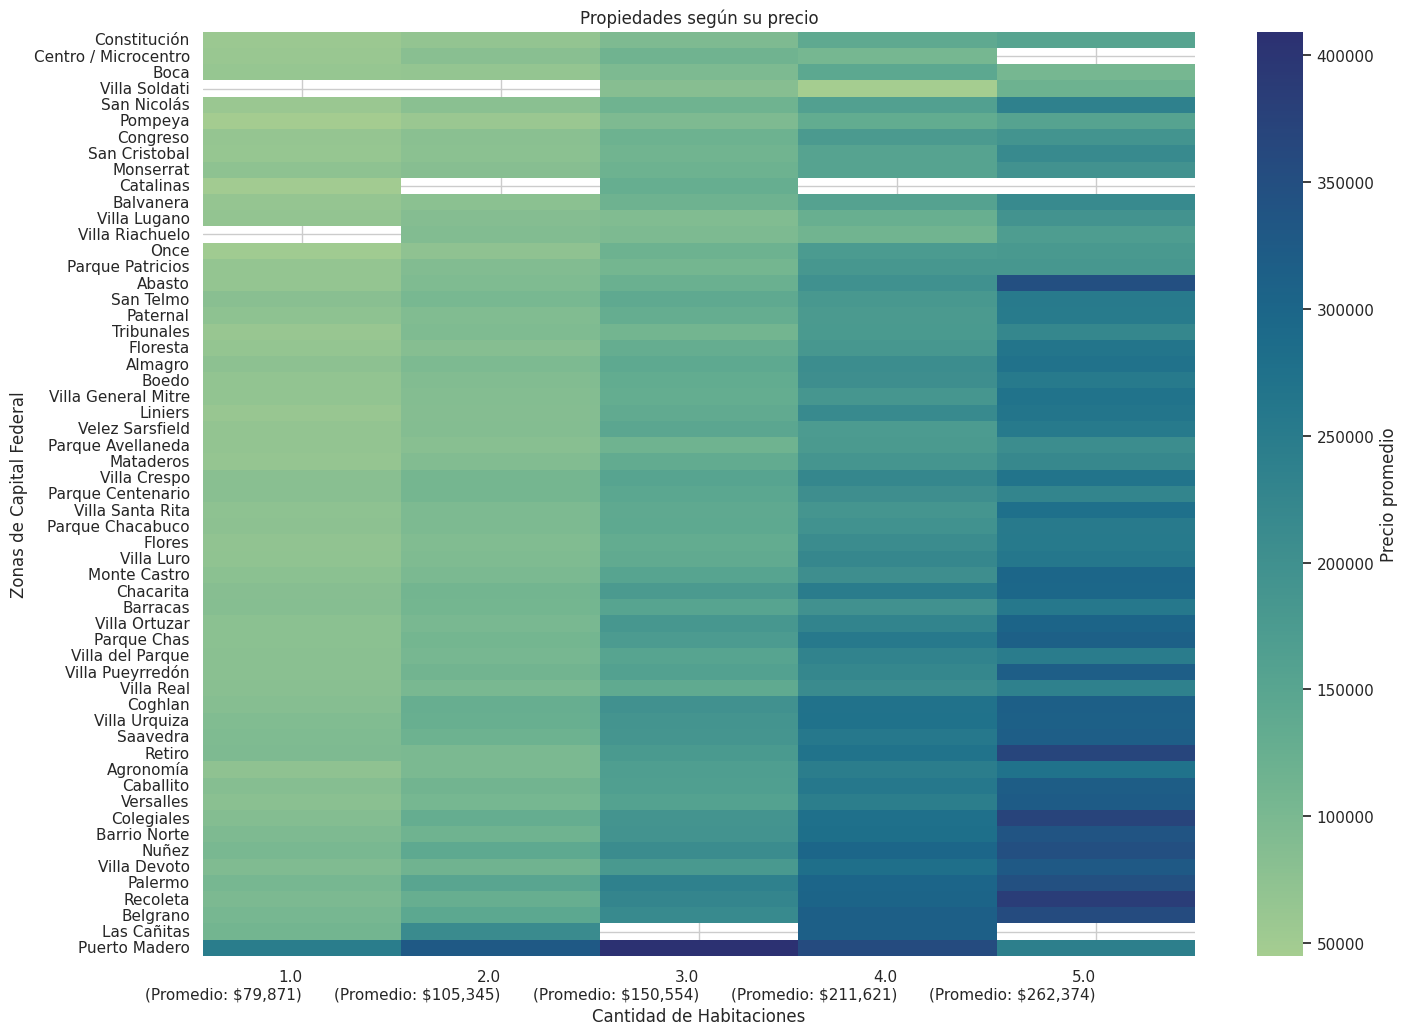

In [849]:
# Calcula el precio promedio por zona
avg_price_by_zone = visu_prop_train.groupby('place_l3')['property_price'].mean()

# Ordenar los barrios según el precio promedio
sorted_zones = avg_price_by_zone.sort_values().index

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_prop_train.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

# Reordenar los barrios según el precio promedio
df_visu = df_visu.reindex(index=sorted_zones)

# Nueva figura con un tamaño mayor y dpi para mejorar la calidad de la visualización
plt.figure(figsize=(16, 12), dpi=100)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Ajustar los ticks del eje x para coincidir con las zonas de la Capital Federal
plt.xticks(ticks=np.arange(0.5, len(df_visu.columns)), labels=df_visu.columns, rotation=45, ha='right')

# Ajustar los ticks del eje y para incluir todos los barrios
plt.yticks(ticks=np.arange(0.5, len(df_visu.index)), labels=df_visu.index, rotation=0, ha='right')
# Ajustar los ticks del eje x para coincidir con las zonas de la Capital Federal y el precio promedio por zona
plt.xticks(ticks=np.arange(0.5, len(df_visu.columns)),
           labels=[f"{col}\n(Promedio: ${df_visu[col].mean():,.0f})" for col in df_visu.columns],
           rotation=45, ha='right')

# Ajustar los ticks del eje y para incluir todos los barrios
plt.yticks(ticks=np.arange(0.5, len(df_visu.index)), labels=df_visu.index, rotation=0, ha='right')

# Añadir etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")
plt.xticks(rotation=0)

# Mostrar el heatmap
plt.show()

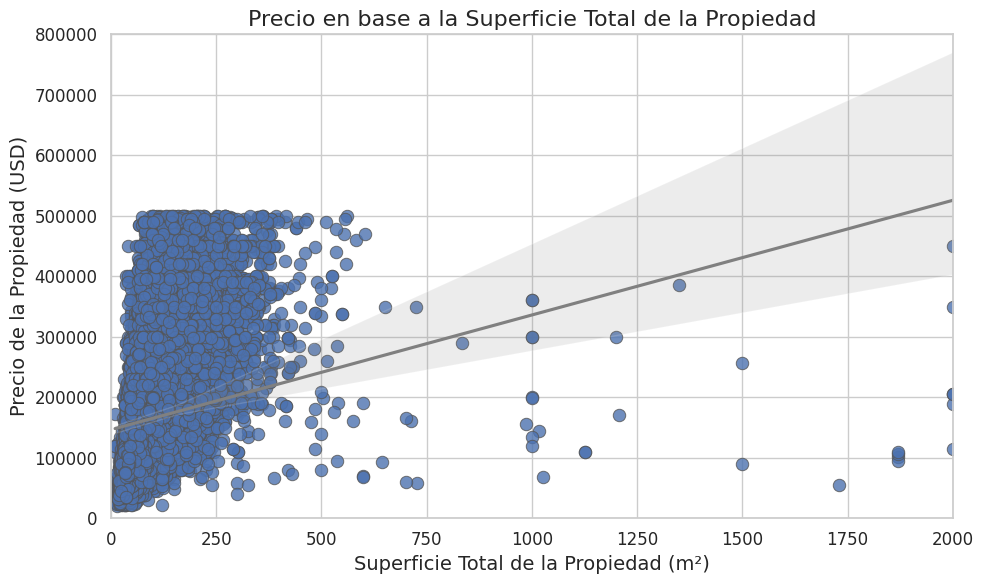

In [850]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el scatter plot utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
                x='property_surface_total', y='property_price', palette='pastel', s=80, alpha=0.8)

# Agregar una línea de regresión
sns.regplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
            x='property_surface_total', y='property_price', scatter=False, color='gray')

# Ajustar título y etiquetas
plt.title('Precio en base a la Superficie Total de la Propiedad', fontsize=16)
plt.xlabel('Superficie Total de la Propiedad (m²)', fontsize=14)
plt.ylabel('Precio de la Propiedad (USD)', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar el rango de los ejes
plt.xlim(0, 2000)  # Establecer el rango x hasta 20,000
plt.ylim(0, 800000)
# Añadir sombreado alrededor de las burbujas
plt.gca().collections[0].set_edgecolor("#555555")

plt.tight_layout()
plt.show()

Esta visualización muestra un diagrama de dispersión (scatter plot) que relaciona el precio de la propiedad con su superficie total, con el agregado de una línea de regresión para visualizar la tendencia general de los datos.La línea de regresión trazada en el gráfico muestra la tendencia general de los datos. Permite ver si hay una relación lineal entre el precio y la superficie total de la propiedad. En este caso, la pendiente de la línea de regresión indica la tasa de cambio en el precio para cada unidad adicional de superficie.Cada punto en el diagrama de dispersión representa una propiedad individual, y su posición relativa en el gráfico indica su precio y superficie total. Esto facilita la identificación de propiedades que pueden estar por encima o por debajo de la tendencia general.

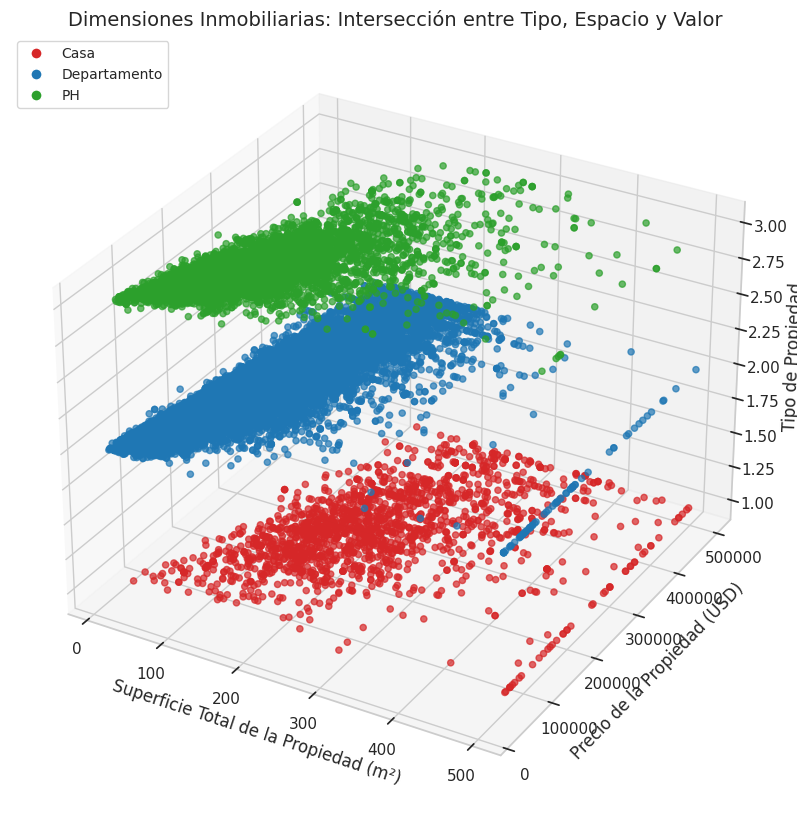

In [851]:
# Crear una figura y un conjunto de ejes tridimensionales
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Mapa de colores para los tipos de propiedad
color_mapping = {'Casa': 'tab:red', 'Departamento': 'tab:blue', 'PH': 'tab:green'}

# Asignar un valor numérico a cada tipo de propiedad
property_type_mapping = {'Casa': 1, 'Departamento': 2, 'PH': 3}
property_type_numeric = [property_type_mapping[prop_type] for prop_type in visu_prop_train['property_type']]

# Extraer las variables del dataframe
property_surface_total = visu_prop_train['property_surface_total'].clip(0, 500)
property_price = visu_prop_train['property_price']

# Graficar los puntos tridimensionales
scatter = ax.scatter(property_surface_total, property_price, property_type_numeric, c=[color_mapping[prop_type] for prop_type in visu_prop_train['property_type']], alpha=0.7)

# Etiquetas de los ejes
ax.set_xlabel('Superficie Total de la Propiedad (m²)', fontsize=12)
ax.set_ylabel('Precio de la Propiedad (USD)', fontsize=12)
ax.set_zlabel('Tipo de Propiedad', fontsize=12)

# Leyenda para los colores
legend_labels = ['Casa', 'Departamento', 'PH']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[prop_type], markersize=8, label=prop_type) for prop_type in legend_labels]
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=10)

# Añadir una rejilla de fondo
ax.grid(True)

# Título del gráfico
plt.title('Dimensiones Inmobiliarias: Intersección entre Tipo, Espacio y Valor', fontsize=14)

# Mostrar el gráfico
plt.show()

Este gráfico tridimensional permite visualizar la distribución de las propiedades en función de su tipo, tamaño y precio. Se pueden identificar patrones de agrupamiento o tendencias en el espacio tridimensional, lo que puede ser útil para comprender mejor el mercado inmobiliario y tomar decisiones informadas. Además, podría usarse para ajustar un modelo de regresión tridimensional para predecir el precio de una propiedad en función de su tipo y tamaño.

In [852]:
# Calcular el precio promedio por barrio
precio_promedio_por_barrio = visu_prop_train.groupby('place_l3')['property_price'].mean().reset_index()

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='place_l3',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio promedio por barrio',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio promedio'})
fig.show()

Esta visualización muestra un gráfico de burbujas agrupadas que representa el precio promedio de las propiedades en cada barrio.El gráfico de burbujas agrupadas proporciona una representación visual del precio promedio de las propiedades en cada barrio de interés. Cada burbuja representa un barrio, y el tamaño de la burbuja indica el precio promedio de las propiedades en ese barrio. Los colores de las burbujas pueden indicar diferentes barrios para facilitar la identificación visual, las burbujas más grandes representan barrios con precios promedio más altos, mientras que las burbujas más pequeñas representan barrios con precios promedio más bajos.El gráfico de burbujas agrupadas es interactivo, lo que permite a los usuarios explorar los datos con mayor detalle al pasar el cursor sobre las burbujas para ver información adicional, como el nombre del barrio y el precio promedio.

VERSION MEJORADA: POR CORRECCION DEL PROFE

---


In [853]:
# Ordenar los barrios según el precio promedio
precio_promedio_por_barrio_sorted = precio_promedio_por_barrio.sort_values('property_price')

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio_sorted,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='property_price',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio Promedio por Zona de Capital Federal',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio Promedio por Zona'})
fig.update_layout(xaxis_title="Precio Promedio por Zona",
                  yaxis_title="Barrio",
                  title_font=dict(size=20, family="Arial"),
                  font=dict(family="Arial", size=12),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  hoverlabel=dict(font=dict(family="Arial", size=14)),
                  xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'))
fig.show()

In [854]:
# Filtramos los Nan de latitud ya que es impresindible contar con este dato para asignarlo al mapa
visu_prop_train = visu_prop_train.dropna(subset=['latitud'])

def generar_mapa_con_registros_por_barrio(df):
    """
    Función para generar un mapa con los registros por barrio.

    Parámetros:
    - visu_prop_train: DataFrame que contiene los datos de las propiedades filtradas.

    Devuelve:
    - mapa: Objeto del mapa de Folium.
    """
    # Coordenadas del centro de la Ciudad Autónoma de Buenos Aires
    latitud_caba = -34.6037
    longitud_caba = -58.3816

    # Crear el mapa centrado en CABA
    mapa = folium.Map(location=[latitud_caba, longitud_caba], zoom_start=12)

    # Agregar un grupo de marcadores
    marker_cluster = MarkerCluster().add_to(mapa)

    # Contar la cantidad de registros por barrio
    registros_por_barrio = visu_prop_train['place_l3'].value_counts()

    # Agregar marcadores en el mapa para cada barrio
    for barrio, cantidad in registros_por_barrio.items():
        latitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['latitud'].iloc[0]
        longitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['longitud'].iloc[0]

        folium.Marker(location=[latitud, longitud],
                      tooltip=f"{barrio}: {cantidad} Propiedad en Venta").add_to(marker_cluster)

    return mapa

# Generar el mapa con los registros por barrio
mapa = generar_mapa_con_registros_por_barrio(visu_prop_train)

# Mostrar el mapa
mapa

La visualización proporciona un mapa interactivo que muestra la ubicación de las propiedades en venta en la Ciudad Autónoma de Buenos Aires (CABA), agrupadas por barrio.Cada marcador en el mapa representa una propiedad, y su ubicación específica está determinada por las coordenadas de latitud y longitud proporcionadas en los datos.Los grupos de marcadores en el mapa indican la concentración de propiedades en cada barrio, lo que puede proporcionar información sobre la popularidad y la demanda de viviendas en diferentes áreas de CABA.

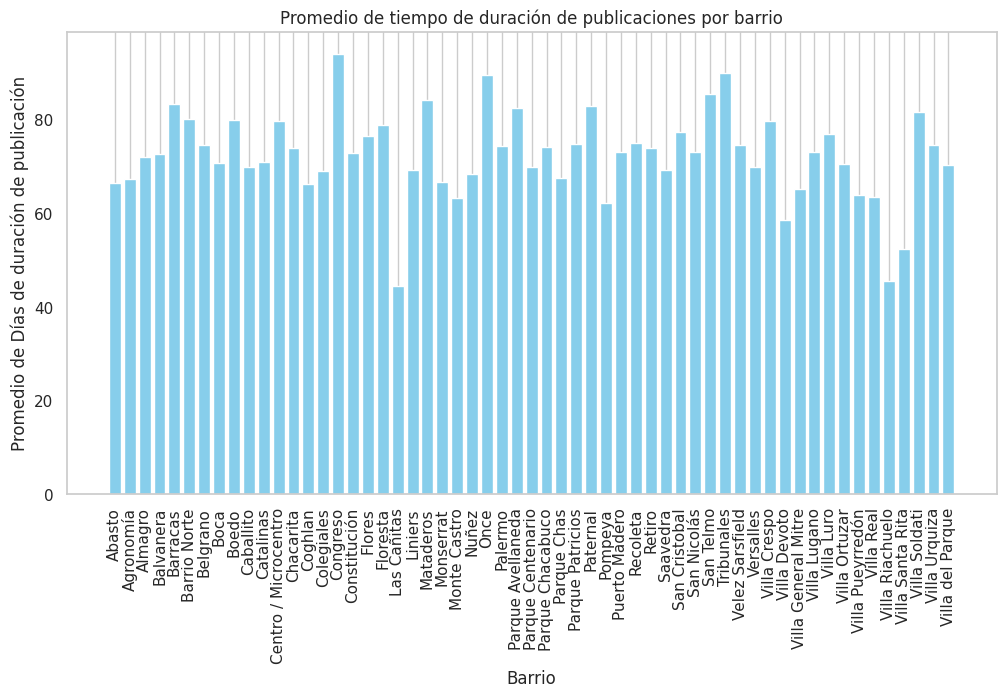

In [855]:
# Convertir las fechas a tipo datetime si no están en ese formato
visu_prop_train['start_date'] = pd.to_datetime(visu_prop_train['start_date'], errors='coerce')
visu_prop_train['end_date'] = pd.to_datetime(visu_prop_train['end_date'], errors='coerce')

# Calcular la duración de cada publicación
visu_prop_train['duracion_publicacion'] = (visu_prop_train['end_date'] - visu_prop_train['start_date']).dt.days

# Agrupar por barrio y calcular el promedio de duración de las publicaciones
promedio_duracion_por_barrio = visu_prop_train.groupby('place_l3')['duracion_publicacion'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(promedio_duracion_por_barrio['place_l3'], promedio_duracion_por_barrio['duracion_publicacion'], color='skyblue')
plt.title('Promedio de tiempo de duración de publicaciones por barrio')
plt.xlabel('Barrio')
plt.ylabel('Promedio de Días de duración de publicación')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

Esta visualización presenta un gráfico de barras que muestra el promedio de tiempo de duración de las publicaciones por barrio en la Ciudad Autónoma de Buenos Aires (CABA). Cada barra en el gráfico representa un barrio específico, y su altura indica el promedio de días que las publicaciones permanecen activas en ese barrio.La visualización permite comparar fácilmente la duración promedio de las publicaciones entre diferentes barrios de la ciudad. Las barras más altas indican que las publicaciones en ese barrio tienden a permanecer activas por más tiempo, mientras que las barras más cortas indican una duración promedio más corta de las publicaciones.Los barrios con barras más altas pueden indicar áreas de la ciudad donde la demanda de propiedades es más alta o donde las propiedades tienden a permanecer en el mercado por períodos más prolongados. Esto puede ser útil para comprender las dinámicas del mercado inmobiliario en diferentes áreas de la ciudad.

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes

### Análisis de datos faltantes a nivel columna

#### Análisis previo

In [856]:
ds_train = prop_train
ds_test = prop_test

In [857]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l3', 'place_l4', 'place_l5', 'place_l6', 'property_type',
       'property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [858]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [859]:
filas = obtener_filas(ds_train)
columnas = obtener_columnas(ds_train)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 75399 filas y 16 columnas


Obtengo el porcentaje de cada columna que contiene datos nulos

In [860]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_train)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.950981
longitud                      3.950981
place_l3                      0.432366
place_l4                     96.193583
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.119378
property_bedrooms            11.673895
property_surface_total        5.159220
property_surface_covered      3.569013
property_price                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [861]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_train)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      2979
longitud                     2979
place_l3                      326
place_l4                    72529
place_l5                    75399
place_l6                    75399
property_type                   0
property_rooms                844
property_bedrooms            8802
property_surface_total       3890
property_surface_covered     2691
property_price                  0
dtype: int64

Grafico esta relación

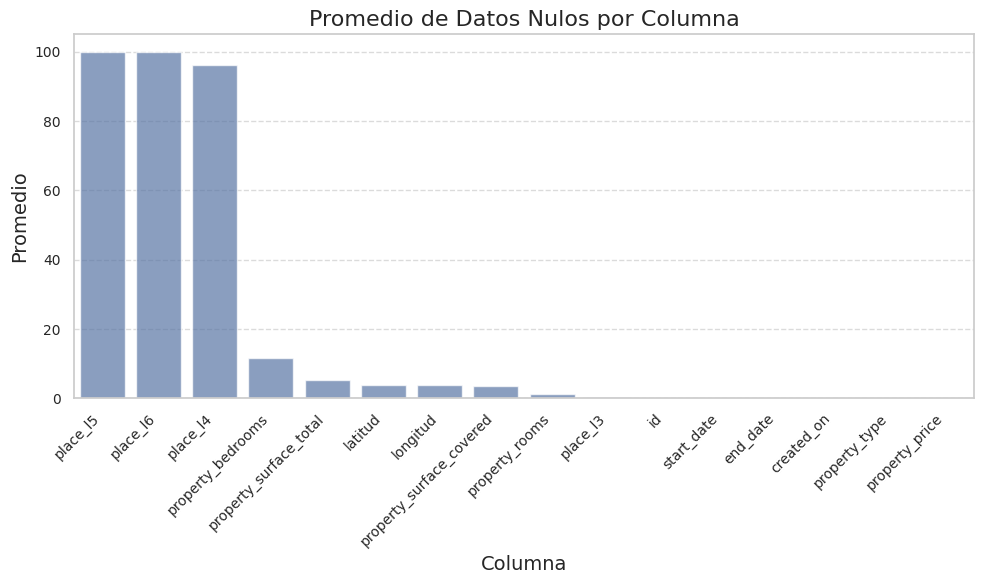

In [862]:
ds_porcentaje = promedio_datos_nulos

# Ordenar los valores en orden descendente
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)

# Establecer el estilo del gráfico
sns.set_style("whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar el gráfico de barras
bar_plot = sns.barplot(x=ds_porcentaje.index, y=ds_porcentaje.values, alpha=0.7)

# Agregar título y etiquetas
bar_plot.set_title("Promedio de Datos Nulos por Columna", fontsize=16)
bar_plot.set_xlabel("Columna", fontsize=14)
bar_plot.set_ylabel("Promedio", fontsize=14)

# Rotar etiquetas del eje x para una mejor legibilidad
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Agregar líneas de la cuadrícula y ajustar el tamaño de la fuente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Entonces los datos que debo analizar son:

In [863]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_train)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.193583
property_bedrooms            11.673895
property_surface_total        5.159220
latitud                       3.950981
longitud                      3.950981
property_surface_covered      3.569013
property_rooms                1.119378
place_l3                      0.432366
dtype: float64

In [864]:
obtener_cantidad_nulos(ds_test)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     95.899204
property_bedrooms            11.591512
property_surface_total        5.061008
latitud                       3.984085
longitud                      3.984085
property_surface_covered      3.517241
property_rooms                1.061008
place_l3                      0.482759
dtype: float64

#### Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [865]:
columnas = ['place_l6','place_l5','place_l4']
ds_train.drop(columns=columnas, inplace=True)
ds_test.drop(columns=columnas, inplace=True)

In [866]:
ds_train.head()

id  start_date    end_date created_on  \
285884  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18 2021-03-06   
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
419659  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09 2021-10-14   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07 2021-10-01   
103677  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
285884 -34.621390 -58.506366      Monte Castro  Departamento             3.0   
120762 -34.563005 -58.453674          Belgrano  Departamento             3.0   
419659 -34.612349 -58.491906  Villa del Parque  Departamento             3.0   
21443  -34.620806 -58.397336             Boedo            PH             3.0   
103677 -34.558229 -58.446708          Belgrano  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
285884                2.0                    51.0                      44.0   
120762                2.0                    79.0                      66.0   
419659                2.0                   110.0                      80.0   
21443                 2.0                    97.0                      67.0   
103677                2.0                    89.0                      89.0   

        property_price  
285884        112000.0  
120762        299900.0  
419659        249000.0  
21443         135000.0  
103677        300000.0

In [867]:
ds_test.head()

id  start_date    end_date created_on  \
212483  YFz1x0+yHihePDT0XdbztQ==  2021-03-22  2021-06-05 2021-03-22   
276449  jWTIlUSYoW5XfmJhydjX5g==  2021-12-23  2022-01-27 2021-12-23   
39814   LcDdt55Y7QNl8VSF1EywmA==  2021-07-30  9999-12-31 2021-07-30   
191752  dS6CarH4aO2s/Yynnm8kXg==  2021-11-01  2021-11-16 2021-11-01   
210393  2BAnzpt5EGhw6FPJJqnb8Q==  2021-07-22  2021-08-08 2021-07-22   

          latitud   longitud       place_l3 property_type  property_rooms  \
212483 -34.587719 -58.418529        Palermo  Departamento             1.0   
276449 -34.599837 -58.466978       Paternal          Casa             3.0   
39814  -34.603665 -58.377891    San Nicolás  Departamento             1.0   
191752 -34.615056 -58.379276      San Telmo  Departamento             1.0   
210393 -34.564364 -58.494266  Villa Urquiza  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
212483                1.0                    26.0                      20.0   
276449                2.0                   100.0                      56.0   
39814                 1.0                    24.0                      24.0   
191752                NaN                    36.0                      30.0   
210393                1.0                    39.0                      37.0   

        property_price  
212483         53000.0  
276449        119000.0  
39814          49900.0  
191752         55000.0  
210393         80900.0

In [868]:
nulos_preimputacion = obtener_cantidad_nulos(ds_train)

In [869]:
obtener_cantidad_nulos(ds_test)

property_bedrooms           11.591512
property_surface_total       5.061008
latitud                      3.984085
longitud                     3.984085
property_surface_covered     3.517241
property_rooms               1.061008
place_l3                     0.482759
dtype: float64

#### Generar funciones para análisis

In [870]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_train[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [871]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [872]:
def generar_grafico(ds, columna):
  # Ajustar el tamaño de la figura
  plt.figure(figsize=(10, 6))

  # Agrupar por 'longitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
  ds.groupby(columna).size().plot(kind='barh', color=sns.color_palette('Dark2'))

  # Ocultar los ejes superior y derecho
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  titulo = 'Tamaño de Grupo por ' + columna
  # Configurar el tamaño de la letra del título y las etiquetas
  plt.title(titulo, fontsize=16)
  plt.xlabel('Cantidad', fontsize=14)
  plt.ylabel(columna, fontsize=14)

  # Mostrar el gráfico
  plt.show()

#### Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [873]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()



latitud longitud
285884  no nulo  no nulo
120762  no nulo  no nulo
419659  no nulo  no nulo
21443   no nulo  no nulo
103677  no nulo  no nulo

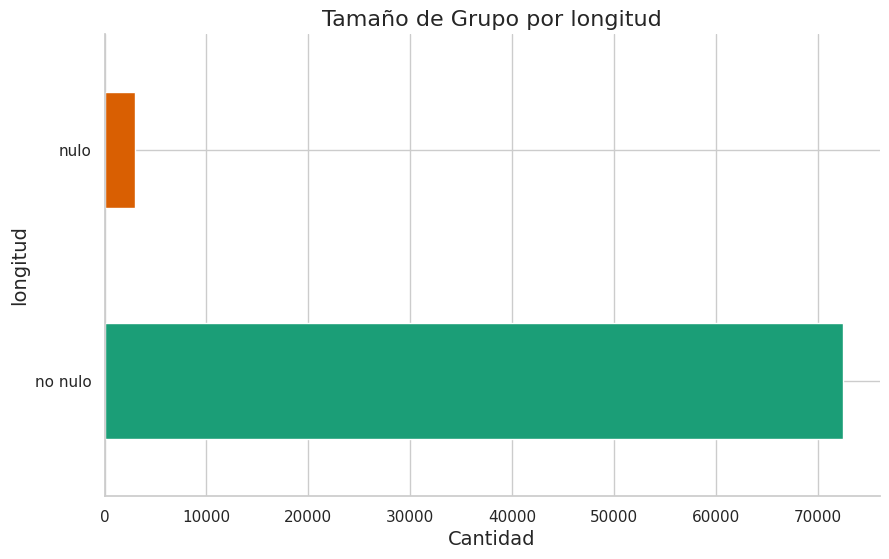

In [874]:
generar_grafico(latatitud_longitud,'longitud')

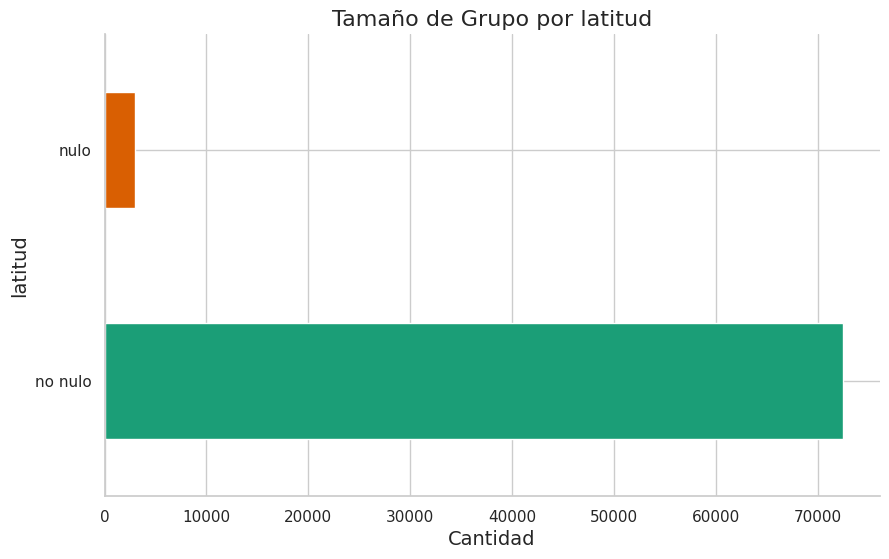

In [875]:
generar_grafico(latatitud_longitud,'latitud')

In [876]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'longitud')

Cantidad de datos NULOS en longitud: 2979
Cantidad de datos NO NULOS en longitud: 72420


In [877]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'latitud')

Cantidad de datos NULOS en latitud: 2979
Cantidad de datos NO NULOS en latitud: 72420


#### Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [878]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

property_surface_total property_surface_covered
285884                no nulo                  no nulo
120762                no nulo                  no nulo
419659                no nulo                  no nulo
21443                 no nulo                  no nulo
103677                no nulo                  no nulo

In [879]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 3890
Cantidad de datos NO NULOS en property_surface_total: 68818


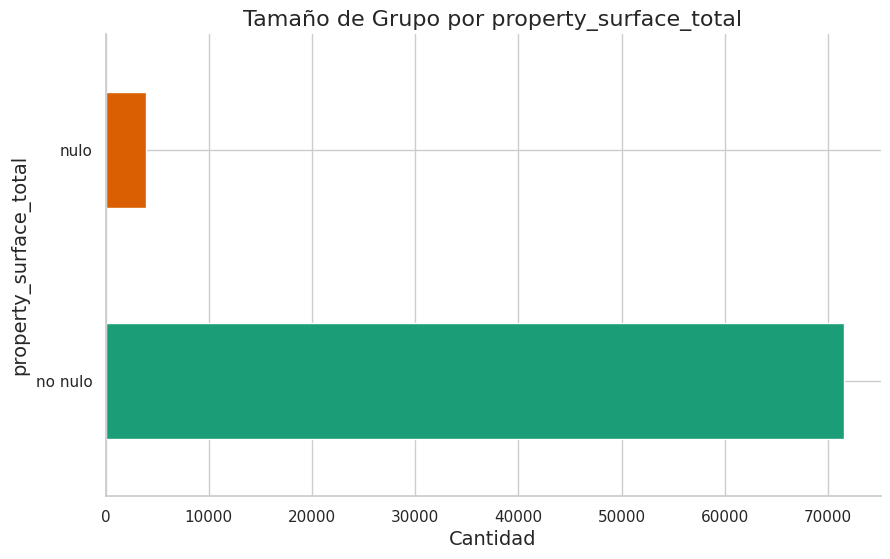

In [880]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [881]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 3890
Cantidad de datos NO NULOS en property_surface_covered: 68818


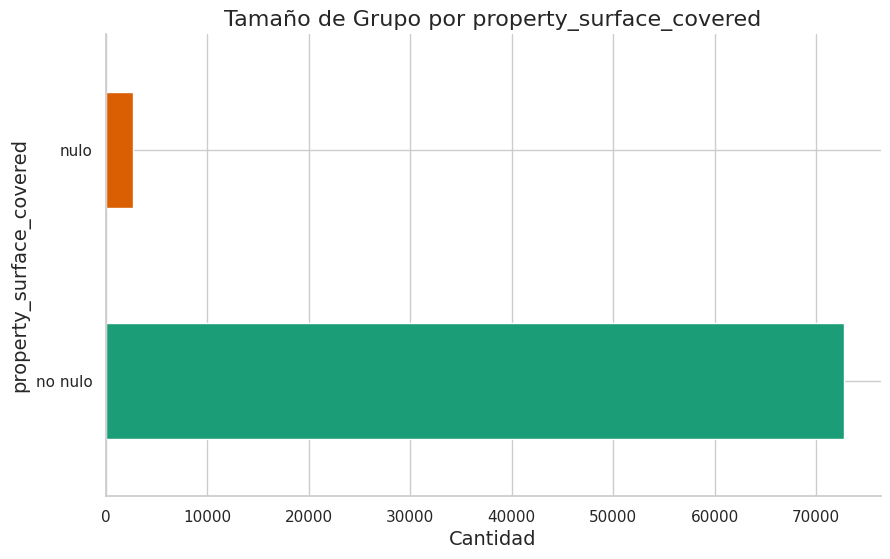

In [882]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

#### Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [883]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

property_rooms property_bedrooms
285884        no nulo           no nulo
120762        no nulo           no nulo
419659        no nulo           no nulo
21443         no nulo           no nulo
103677        no nulo           no nulo

In [884]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_rooms')

Cantidad de datos NULOS en property_rooms: 8460
Cantidad de datos NO NULOS en property_rooms: 66095


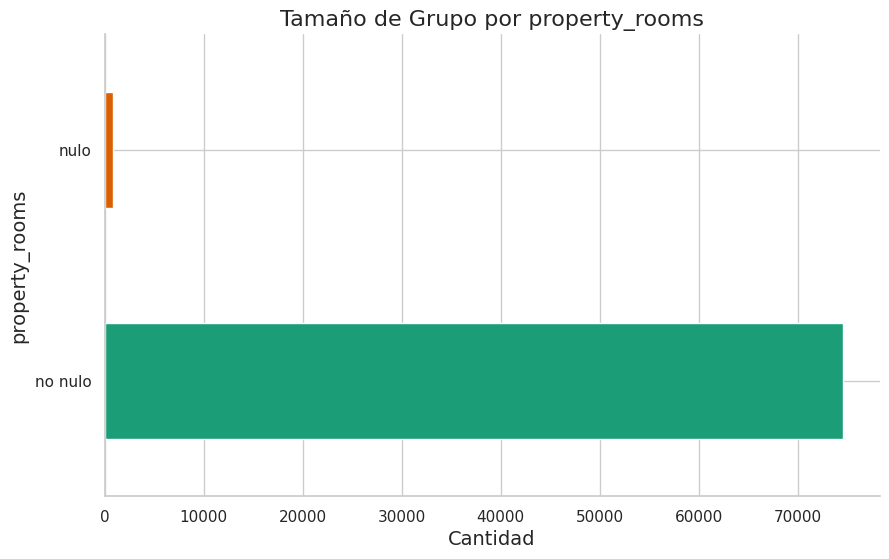

In [885]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [886]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 8460
Cantidad de datos NO NULOS en property_bedrooms: 66095


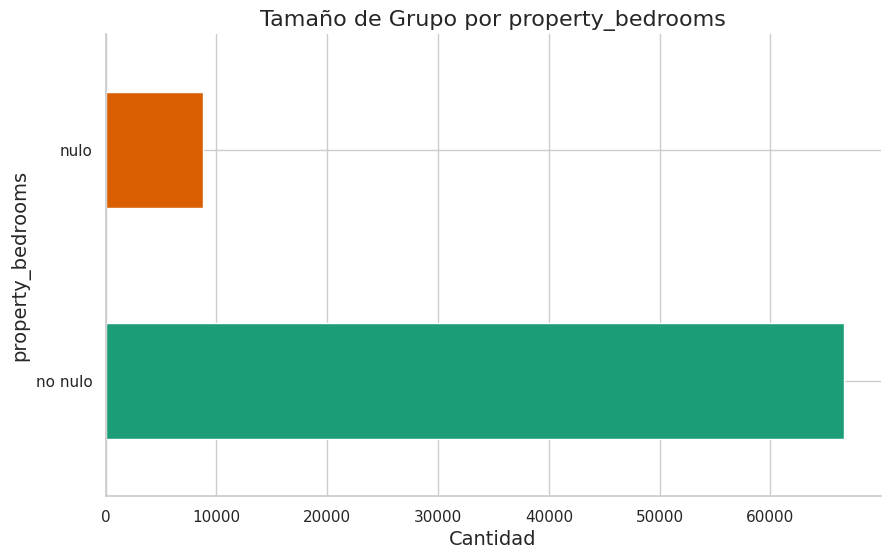

In [887]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

#### Barrio (place_l3)

In [888]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

285884    no nulo
120762    no nulo
419659    no nulo
21443     no nulo
103677    no nulo
Name: place_l3, dtype: object

In [889]:
imprimir_cantidades(barrio.value_counts()[1], barrio.value_counts()[0], 'place_l3')

Cantidad de datos NULOS en place_l3: 326
Cantidad de datos NO NULOS en place_l3: 75073


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

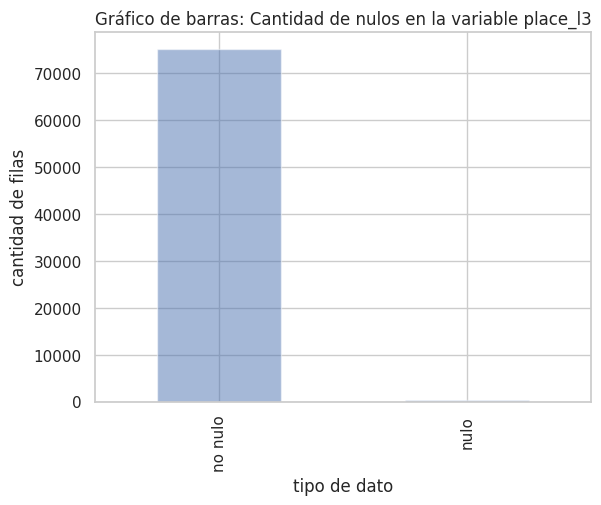

In [890]:
barrio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

#### Precio

In [891]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

285884    no nulo
120762    no nulo
419659    no nulo
21443     no nulo
103677    no nulo
Name: property_price, dtype: object

In [892]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))

Cantidad de datos NO NULOS en property_price: property_price
no nulo    75399
Name: count, dtype: int64


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

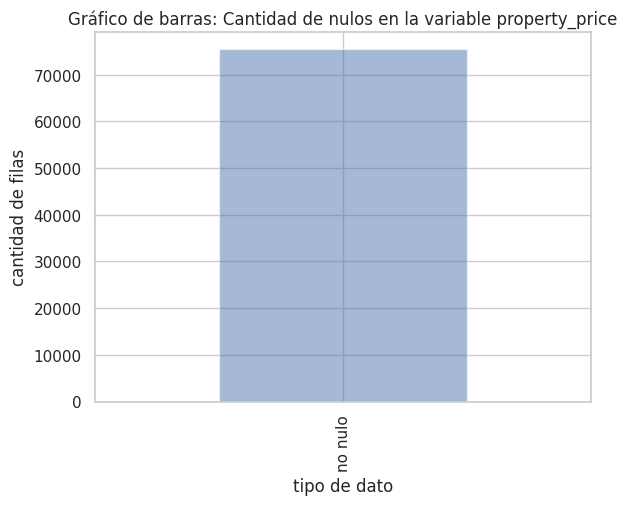

In [893]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

### Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [894]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_train.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  17118


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en ds_train'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

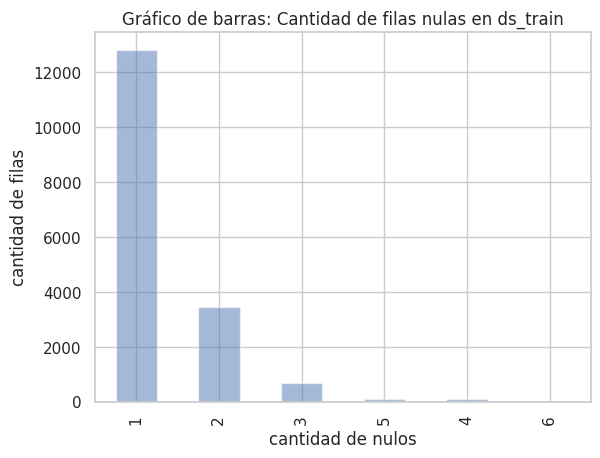

In [895]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en ds_train", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

### Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_train

In [896]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.673895
property_surface_total       5.159220
latitud                      3.950981
longitud                     3.950981
property_surface_covered     3.569013
property_rooms               1.119378
place_l3                     0.432366
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

#### Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [897]:
ds_pre_imputacion = ds_train.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [898]:
ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_train)
completar_barrios(ds_test)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [899]:
# Ordenar el DataFrame por 'place_l3'
ds_train_sorted = ds_train.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_train_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_train_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_train_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_train_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_train_sorted

place_l3                        id  start_date    end_date  \
27      AGRONOMIA                       NaN         NaN         NaN   
4         ALMAGRO                       NaN         NaN         NaN   
27431      Abasto  0E+HNlZBz5FzbFrIZZFTpQ==  2021-12-03  2021-12-11   
296468     Abasto  dSfzvnYJCzEDSphNoqZbew==  2021-04-26  2021-06-05   
443635     Abasto  xkJVsPfqiyjVwpJvS0Vi5Q==  2021-11-09  9999-12-31   
...           ...                       ...         ...         ...   
377126        NaN  utOWuv4OXDSljDlUPiZh3A==  2021-03-16  2021-06-05   
131188        NaN  Qmi68tFcN9DiyOJjVmGvYg==  2021-05-27  2021-06-05   
363969        NaN  p6PDh9UYBzTc/nWB1Ye2Xw==  2021-04-10  2021-04-13   
389004        NaN  CPXCgjqRI/3js9VHc63/ew==  2021-05-05  2021-06-05   
130482        NaN  L1fMpjJS2AMQh1WzDSci3g==  2021-05-27  2021-06-05   

       created_on    latitud   longitud property_type  property_rooms  \
27            NaT        NaN        NaN           NaN             NaN   
4             NaT        NaN        NaN           NaN             NaN   
27431  2021-12-03 -34.603709 -58.413119  Departamento             2.0   
296468 2021-04-26 -34.602023 -58.412953  Departamento             4.0   
443635 2021-11-09 -34.601861 -58.421274  Departamento             2.0   
...           ...        ...        ...           ...             ...   
377126 2021-03-16        NaN        NaN  Departamento             4.0   
131188 2021-05-27 -41.083002 -71.182747  Departamento             2.0   
363969 2021-04-10        NaN        NaN          Casa             NaN   
389004 2021-05-05        NaN        NaN            PH             3.0   
130482 2021-05-27 -31.633224 -60.616306          Casa             NaN   

        property_bedrooms  property_surface_total  property_surface_covered  \
27                    NaN                     NaN                       NaN   
4                     NaN                     NaN                       NaN   
27431                 1.0                    47.0                      41.0   
296468                3.0                    76.0                      76.0   
443635                1.0                    43.0                      40.0   
...                   ...                     ...                       ...   
377126                2.0                     NaN                      98.0   
131188                1.0                    66.0                      56.0   
363969                1.0                   300.0                     300.0   
389004                2.0                    64.0                      55.0   
130482                3.0                     NaN                     150.0   

        property_price  
27                 NaN  
4                  NaN  
27431         139900.0  
296468        192000.0  
443635         75000.0  
...                ...  
377126        300000.0  
131188        135000.0  
363969        330000.0  
389004        109000.0  
130482        150000.0  

[75414 rows x 13 columns]

Vemos que hay datos NaN en el barrio

In [900]:
ds_train['place_l3'].isna().value_counts()

place_l3
False    75088
True       326
Name: count, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [901]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_train = ds_train.dropna(subset=columnas_a_eliminar)
ds_test =  ds_test.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [902]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.556780
property_surface_total       5.046659
property_surface_covered     3.526431
property_rooms               0.969180
dtype: float64

#### Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

##### Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [903]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                          True
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [904]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

id  start_date    end_date created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18 2021-01-07   

          latitud   longitud       place_l3 place_l4 place_l5  place_l6  \
406880 -34.577595 -58.495185  Villa Urquiza      NaN      NaN       NaN   

       property_type  property_rooms  property_bedrooms  \
406880  Departamento             2.0               -1.0   

        property_surface_total  property_surface_covered  property_price  
406880                    61.0                      43.0        125000.0

Como hay un registro, procederemos a asignarlo nulo.

In [905]:
ds_train.loc[ds_train['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

Se verifica si hay valores menores o iguales que cero.

In [906]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Se realiza el mismo análisis con ds_test

In [907]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_test[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

##### Análisis de duplicados

Verificamos si hay datos duplicados en estas columnas

In [908]:
ds_train[ds_train.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [909]:
ds_test[ds_test.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

Procederemos a eliminar filas duplicadas

In [910]:
size_antes = len(ds_train)
ds_train_filtrado = ds_train.drop_duplicates()
size_despues = len(ds_train_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_train")

Se eliminaron: 0 filas duplicadas de ds_train


In [911]:
ds_train_filtrado.reset_index(drop=True, inplace=True)

In [912]:
size_antes = len(ds_test)
ds_test_filtrado = ds_test.drop_duplicates()
size_despues = len(ds_test_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_test")

Se eliminaron: 0 filas duplicadas de ds_test


In [913]:
ds_test_filtrado.reset_index(drop=True, inplace=True)

##### Completacion de las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijiremos el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [914]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_train,columnas_con_numeros)
rellenar_variables(ds_test,columnas_con_numeros)

ds_train[columnas_con_numeros] = ds_train[columnas_con_numeros].round()
ds_test[columnas_con_numeros] = ds_test[columnas_con_numeros].round()


In [915]:
obtener_promedio_nulos(ds_train)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64

In [916]:
obtener_cantidad_nulos(ds_train)

'No existen valores NaN'

### Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [917]:
ds_pre_imputacion.head()

id  start_date    end_date created_on  \
285884  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18 2021-03-06   
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
419659  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09 2021-10-14   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07 2021-10-01   
103677  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
285884 -34.621390 -58.506366      Monte Castro  Departamento             3.0   
120762 -34.563005 -58.453674          Belgrano  Departamento             3.0   
419659 -34.612349 -58.491906  Villa del Parque  Departamento             3.0   
21443  -34.620806 -58.397336             Boedo            PH             3.0   
103677 -34.558229 -58.446708          Belgrano  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
285884                2.0                    51.0                      44.0   
120762                2.0                    79.0                      66.0   
419659                2.0                   110.0                      80.0   
21443                 2.0                    97.0                      67.0   
103677                2.0                    89.0                      89.0   

        property_price  
285884        112000.0  
120762        299900.0  
419659        249000.0  
21443         135000.0  
103677        300000.0

Recordemos que datos imputamos

In [918]:
nulos_preimputacion

property_bedrooms           11.673895
property_surface_total       5.159220
latitud                      3.950981
longitud                     3.950981
property_surface_covered     3.569013
property_rooms               1.119378
place_l3                     0.432366
dtype: float64

In [919]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

#### Funciones de distribución

In [920]:
def generar_distribucion(variable):
  # Configuración de estilo y colores
  sns.set(style="whitegrid")
  sns.set_palette("pastel")

  # Creo la cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0], width=0.5)
  axes[0].set_title("Boxplot {} pre-imputación".format(variable), fontsize=14)
  axes[0].set_ylabel("Valor", fontsize=12)
  axes[0].set_xlabel("", fontsize=12)

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1], width=0.5)
  axes[1].set_title("Boxplot {} post-imputación".format(variable), fontsize=14)
  axes[1].set_ylabel("Valor", fontsize=12)
  axes[1].set_xlabel("", fontsize=12)

  # Ajusto el diseño
  plt.tight_layout()

  plt.show()

  return

In [921]:
def generar_distribucion_zoom(variable):
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  plt.show()
  return

In [922]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [923]:
def comparar_imputacion(pre, post, columna):
    longitud_post = len(post)
    longitud_pre = len(pre)

    for i in range(longitud_post):
        # Verificar si i es mayor que la longitud de pre
        if i >= longitud_pre:
            print("i es mayor que la longitud de pre. Se corta el bucle.")
            break

        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, post[columna][i], columna))

    return

#### Comparación property_bedrooms

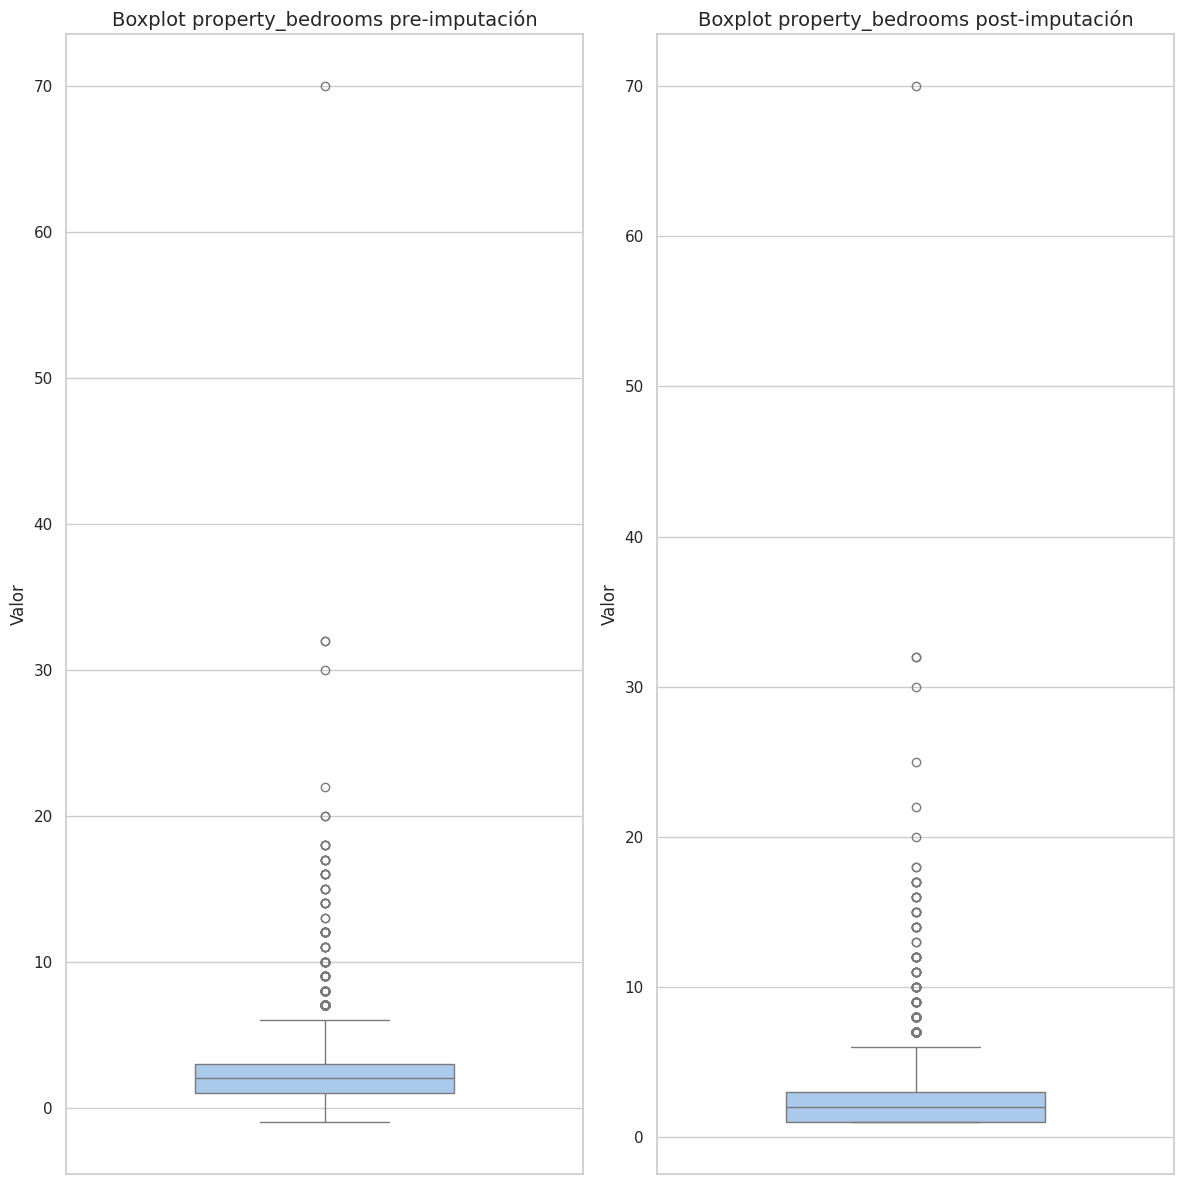

In [924]:
generar_distribucion("property_bedrooms")

Un poco de zoom

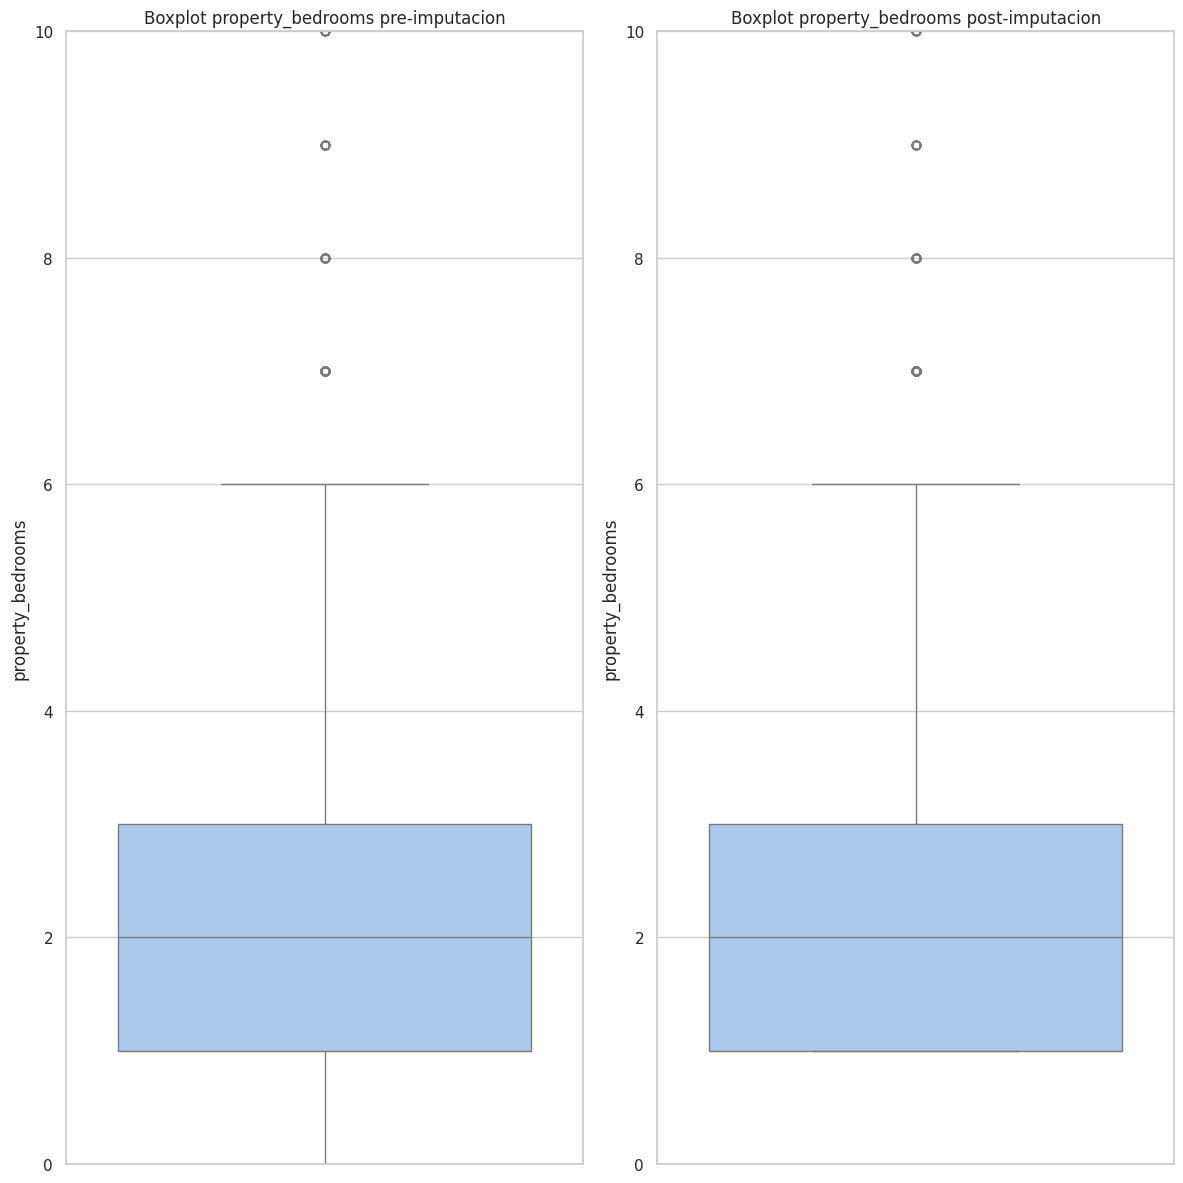

In [925]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [926]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

property_bedrooms  cantidad
0                1.0     25533
1                2.0     21827
2                3.0     14243
3                4.0      3812
4                5.0       753

In [927]:
post_bedrooms = obtener_cantidad_variables(ds_train,'property_bedrooms')
post_bedrooms.head()

property_bedrooms  cantidad
0                1.0     32204
1                2.0     21508
2                3.0     13746
3                4.0      3633
4                5.0       704

Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [928]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

6671 registros se imputaron con el valor de 1.0 property_bedrooms
319 registros se imputaron con el valor de 2.0 property_bedrooms
497 registros se imputaron con el valor de 3.0 property_bedrooms
179 registros se imputaron con el valor de 4.0 property_bedrooms
49 registros se imputaron con el valor de 5.0 property_bedrooms
7 registros se imputaron con el valor de 6.0 property_bedrooms
5 registros se imputaron con el valor de 7.0 property_bedrooms
0 registros se imputaron con el valor de 8.0 property_bedrooms
2 registros se imputaron con el valor de 9.0 property_bedrooms
1 registros se imputaron con el valor de 10.0 property_bedrooms
0 registros se imputaron con el valor de 12.0 property_bedrooms
2 registros se imputaron con el valor de 11.0 property_bedrooms
1 registros se imputaron con el valor de 14.0 property_bedrooms
0 registros se imputaron con el valor de 17.0 property_bedrooms
0 registros se imputaron con el valor de 15.0 property_bedrooms
1 registros se imputaron con el valor d

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

#### Comparación property_rooms

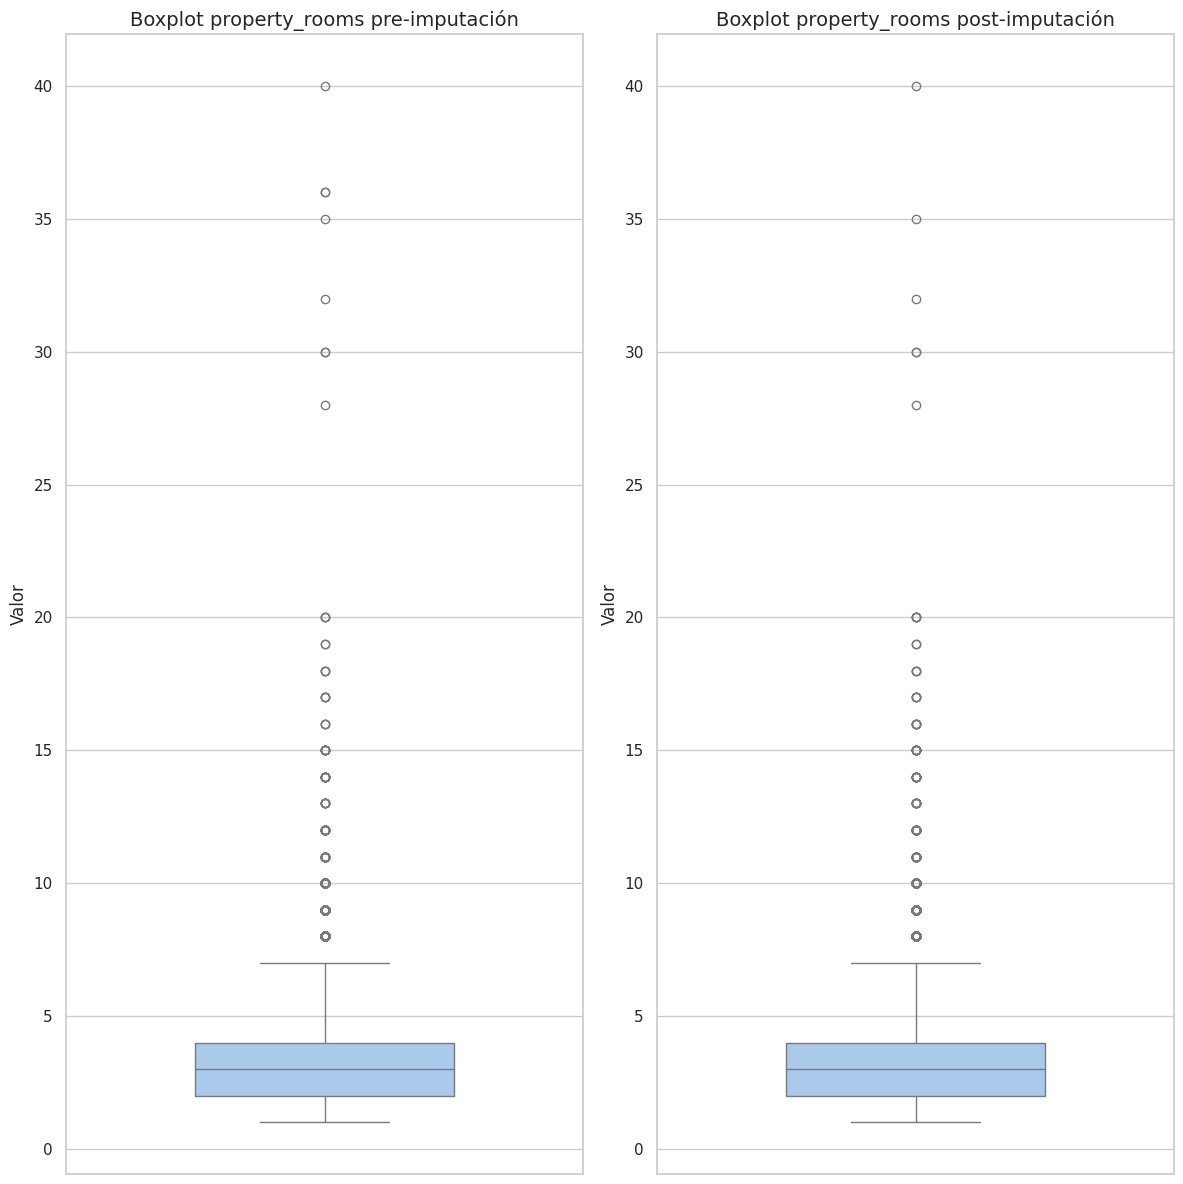

In [929]:
generar_distribucion("property_rooms")

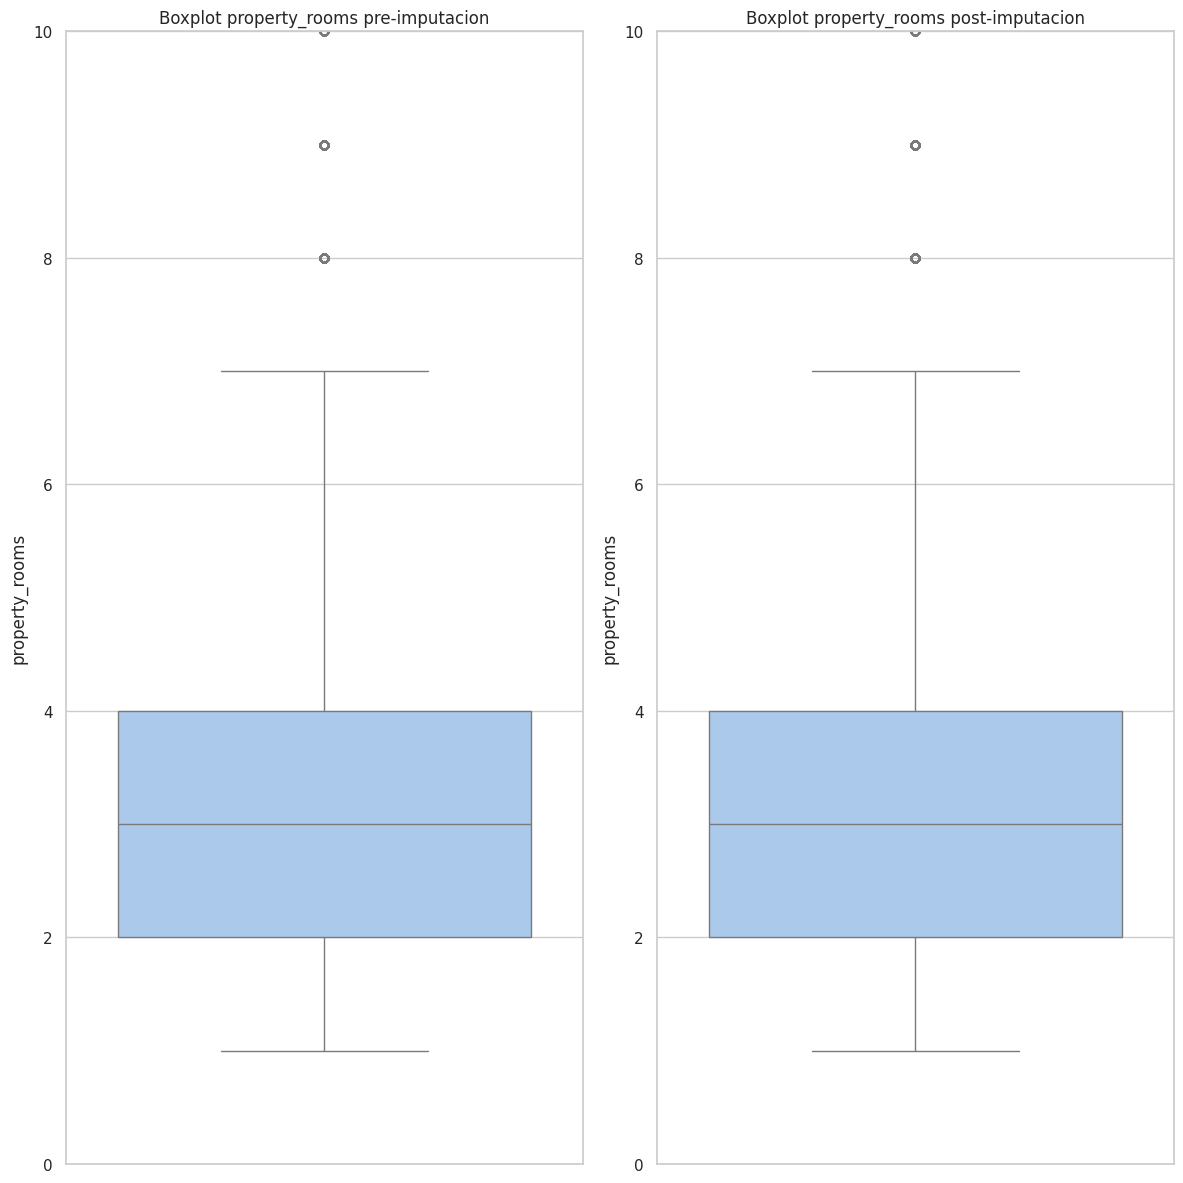

In [930]:
generar_distribucion_zoom("property_rooms")

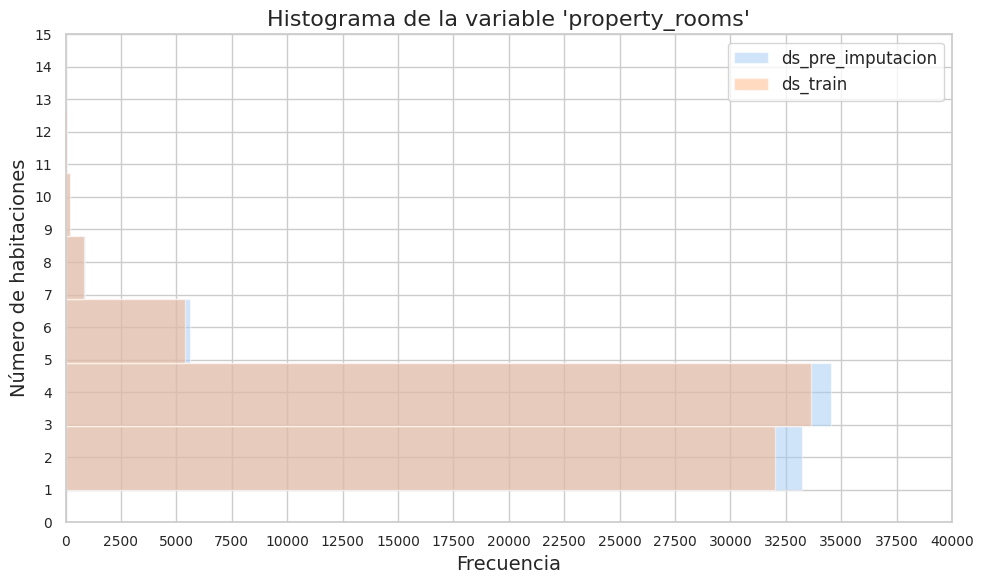

In [931]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_train')

# Ajustes de título y etiquetas
plt.title("Histograma de la variable 'property_rooms'", fontsize=16)
plt.xlabel("Frecuencia", fontsize=14)
plt.ylabel("Número de habitaciones", fontsize=14)

# Ajustes de límites de los ejes (zoom)
plt.ylim(0, 15)
plt.xlim(0, 40000)

# Establecer intervalos del eje x
plt.xticks(np.arange(0, 40001, 2500), fontsize=10)

# Añadir leyenda
plt.legend(fontsize=12)

# Establecer intervalos del eje y
plt.yticks(np.arange(16), fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='property_rooms'>

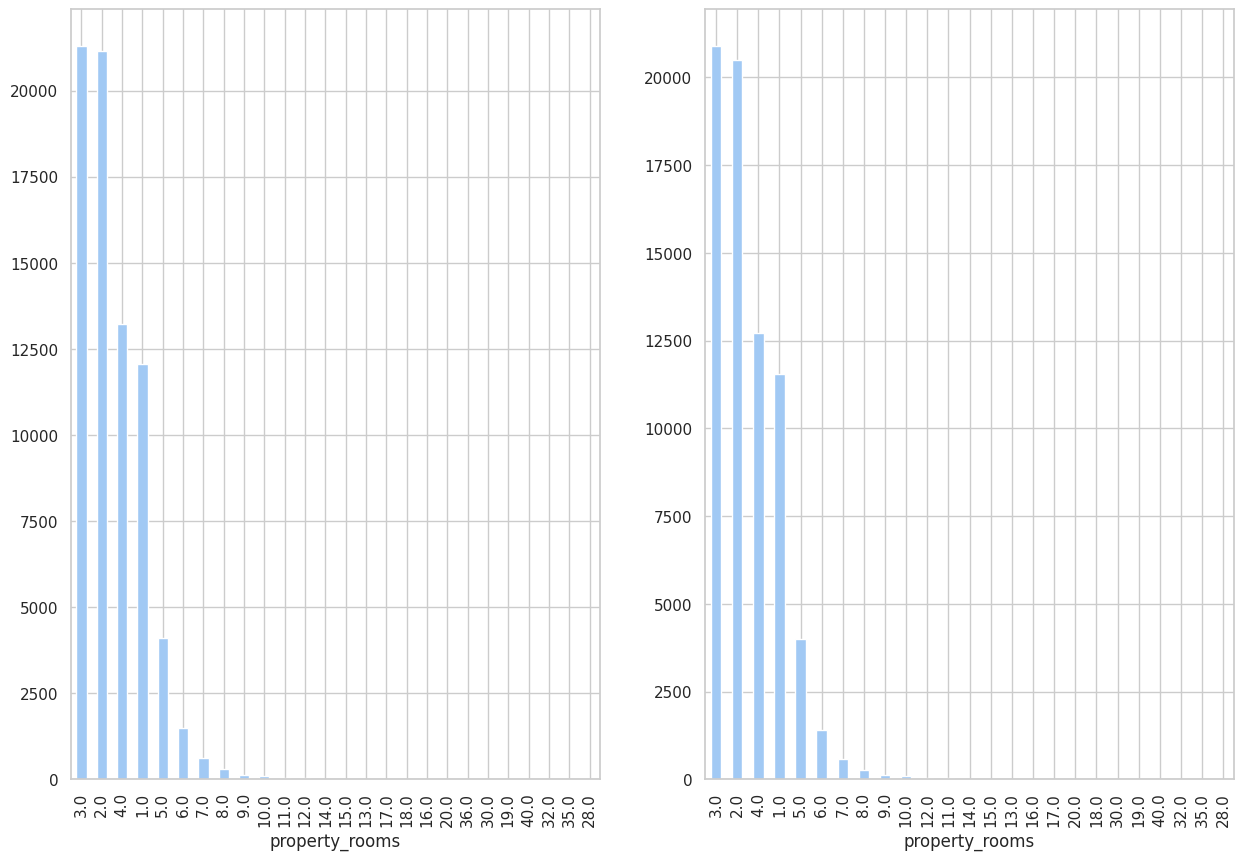

In [932]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [933]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

property_rooms  cantidad
0             3.0     21300
1             2.0     21166
2             4.0     13226
3             1.0     12070
4             5.0      4113

In [934]:
post_rooms = obtener_cantidad_variables(ds_train,'property_rooms')
post_rooms.head()

property_rooms  cantidad
0             3.0     20894
1             2.0     20480
2             4.0     12720
3             1.0     11544
4             5.0      3999

In [935]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

406 registros se imputaron con el valor de 3.0 property_rooms
686 registros se imputaron con el valor de 2.0 property_rooms
506 registros se imputaron con el valor de 4.0 property_rooms
526 registros se imputaron con el valor de 1.0 property_rooms
114 registros se imputaron con el valor de 5.0 property_rooms
72 registros se imputaron con el valor de 6.0 property_rooms
23 registros se imputaron con el valor de 7.0 property_rooms
14 registros se imputaron con el valor de 8.0 property_rooms
7 registros se imputaron con el valor de 9.0 property_rooms
1 registros se imputaron con el valor de 10.0 property_rooms
4 registros se imputaron con el valor de 12.0 property_rooms
3 registros se imputaron con el valor de 11.0 property_rooms
1 registros se imputaron con el valor de 14.0 property_rooms
1 registros se imputaron con el valor de 15.0 property_rooms
2 registros se imputaron con el valor de 13.0 property_rooms
1 registros se imputaron con el valor de 16.0 property_rooms
1 registros se imput

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

#### Comparación property_surface_total

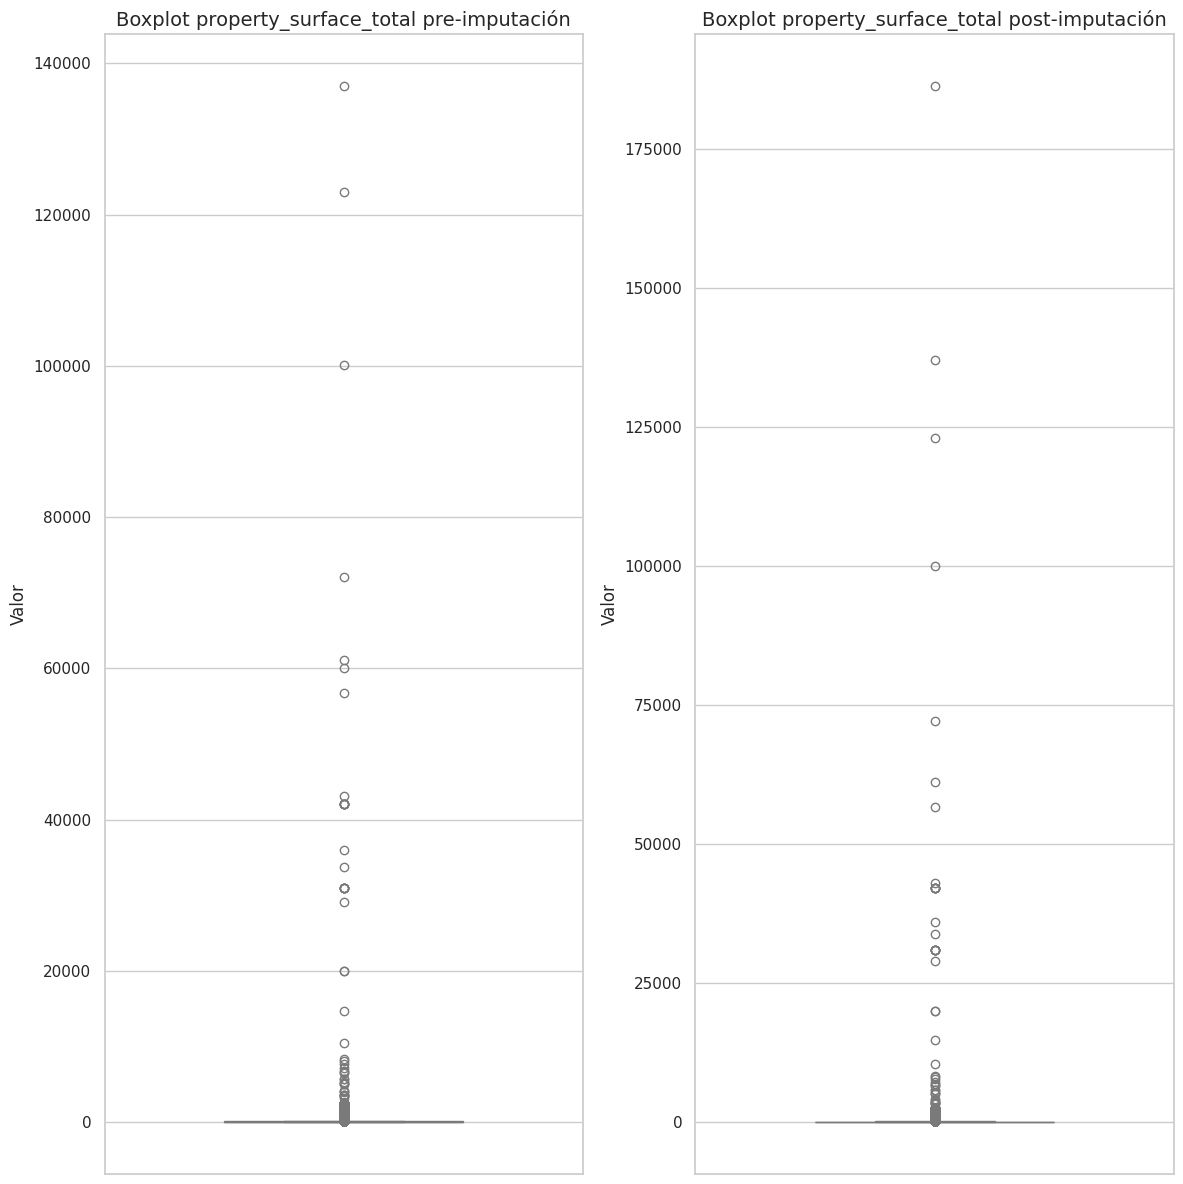

In [936]:
generar_distribucion("property_surface_total")

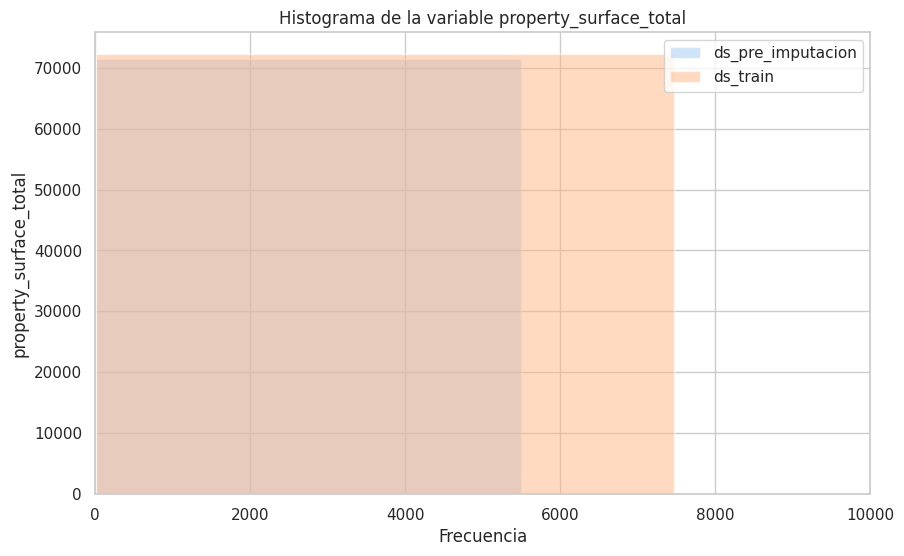

In [937]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_total'], bins=25, alpha=0.5, label='ds_train')

plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)

plt.legend()

plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [938]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

property_surface_total  cantidad
0                    50.0      1450
1                    40.0      1373
2                    42.0      1266
3                    45.0      1255
4                    35.0      1204

In [939]:
post_total = obtener_cantidad_variables(ds_train,'property_surface_total')
post_total.head()

property_surface_total  cantidad
0                    50.0      1473
1                    40.0      1360
2                    42.0      1261
3                    45.0      1241
4                    35.0      1176

In [940]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

23 registros se imputaron con el valor de 50.0 property_surface_total
13 registros se imputaron con el valor de 40.0 property_surface_total
5 registros se imputaron con el valor de 42.0 property_surface_total
14 registros se imputaron con el valor de 45.0 property_surface_total
28 registros se imputaron con el valor de 35.0 property_surface_total
21 registros se imputaron con el valor de 38.0 property_surface_total
21 registros se imputaron con el valor de 60.0 property_surface_total
16 registros se imputaron con el valor de 55.0 property_surface_total
6 registros se imputaron con el valor de 37.0 property_surface_total
3 registros se imputaron con el valor de 47.0 property_surface_total
18 registros se imputaron con el valor de 43.0 property_surface_total
11 registros se imputaron con el valor de 44.0 property_surface_total
0 registros se imputaron con el valor de 48.0 property_surface_total
15 registros se imputaron con el valor de 36.0 property_surface_total
5 registros se imputaron

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 33 m²


#### Comparación property_surface_covered

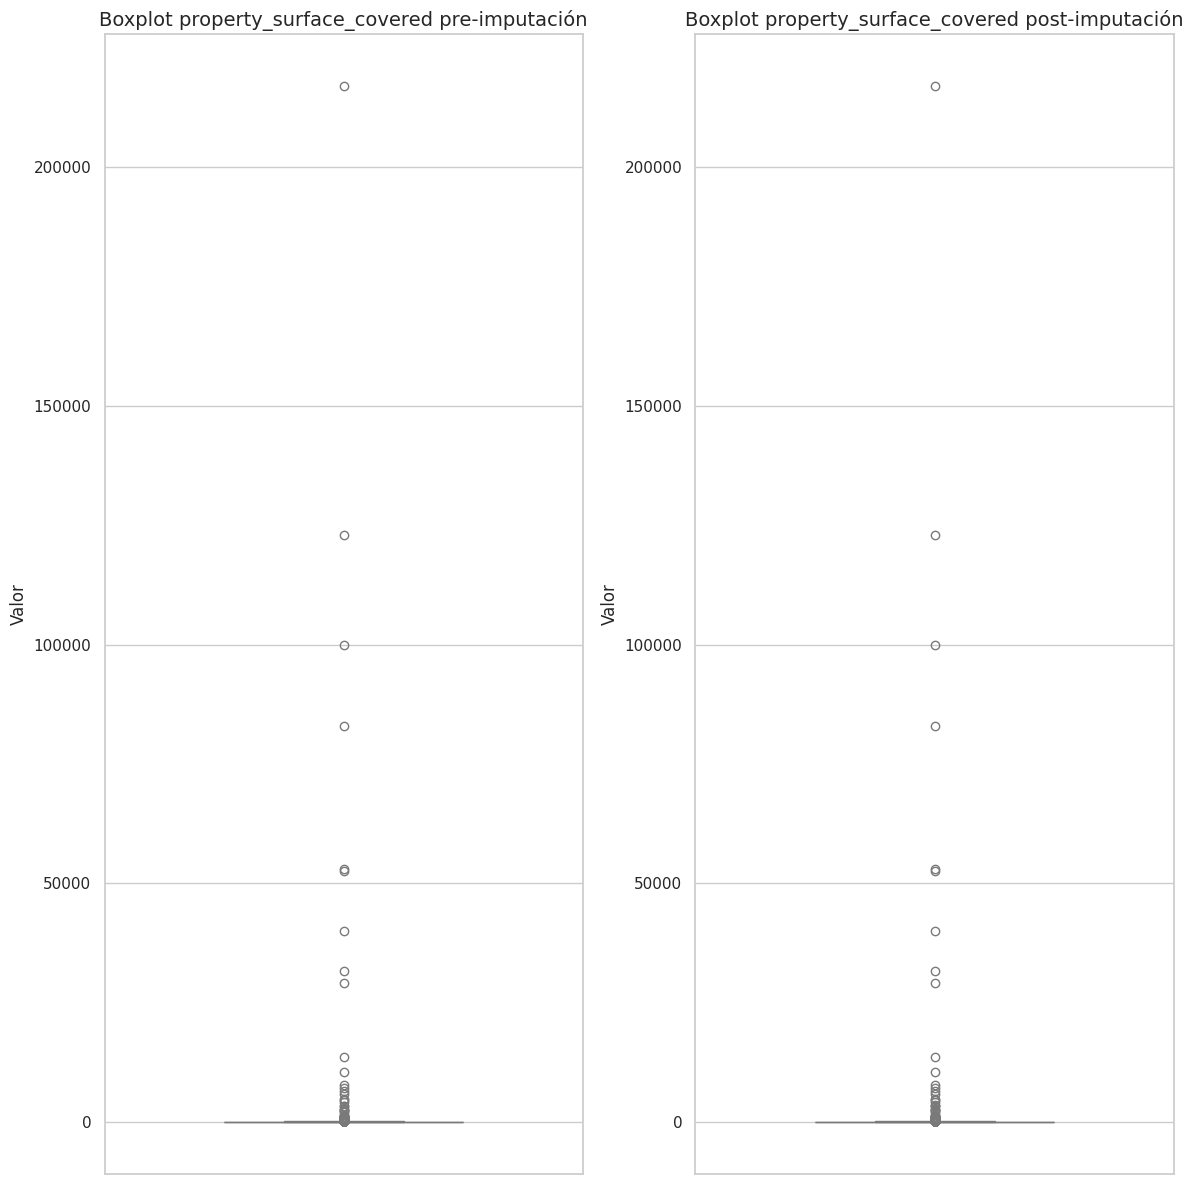

In [941]:
generar_distribucion("property_surface_covered")

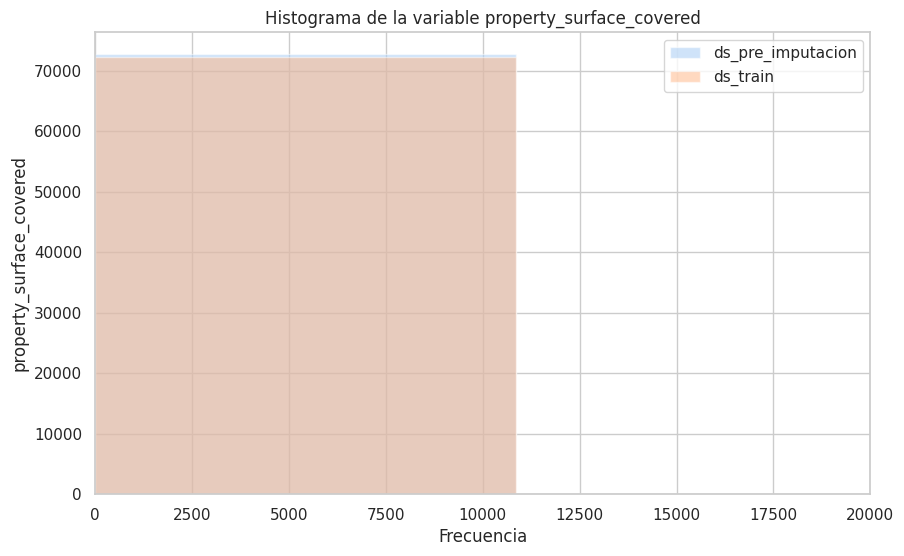

In [942]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_covered'], bins=20, alpha=0.5,  label='ds_train')


plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)

plt.legend()

plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable era la que estaba entre los menos valores nulos.

In [943]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1913
1                      38.0      1632
2                      50.0      1579
3                      45.0      1567
4                      35.0      1493

In [944]:
post_cubierto = obtener_cantidad_variables(ds_train,'property_surface_covered')
post_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1898
1                      38.0      1587
2                      50.0      1560
3                      45.0      1508
4                      35.0      1455

In [945]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

15 registros se imputaron con el valor de 40.0 property_surface_covered
45 registros se imputaron con el valor de 38.0 property_surface_covered
19 registros se imputaron con el valor de 50.0 property_surface_covered
59 registros se imputaron con el valor de 45.0 property_surface_covered
38 registros se imputaron con el valor de 35.0 property_surface_covered
15 registros se imputaron con el valor de 42.0 property_surface_covered
7 registros se imputaron con el valor de 60.0 property_surface_covered
10 registros se imputaron con el valor de 36.0 property_surface_covered
9 registros se imputaron con el valor de 30.0 property_surface_covered
7 registros se imputaron con el valor de 37.0 property_surface_covered
10 registros se imputaron con el valor de 32.0 property_surface_covered
27 registros se imputaron con el valor de 34.0 property_surface_covered
33 registros se imputaron con el valor de 33.0 property_surface_covered
43 registros se imputaron con el valor de 43.0 property_surface_cov

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 45 m²

#### Comparación latitud

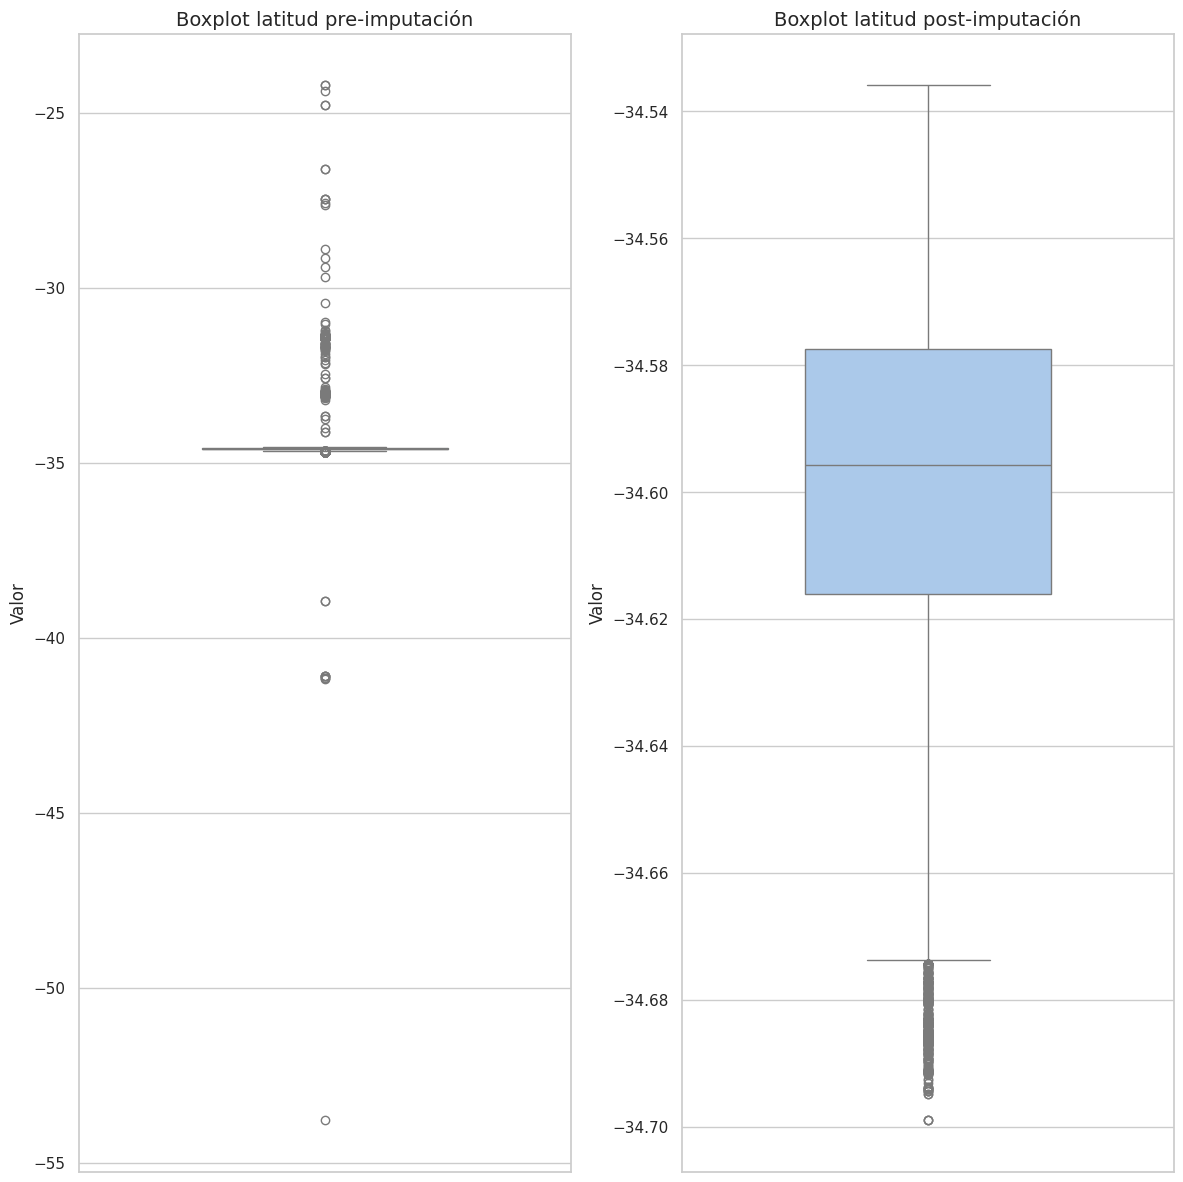

In [946]:
generar_distribucion("latitud")

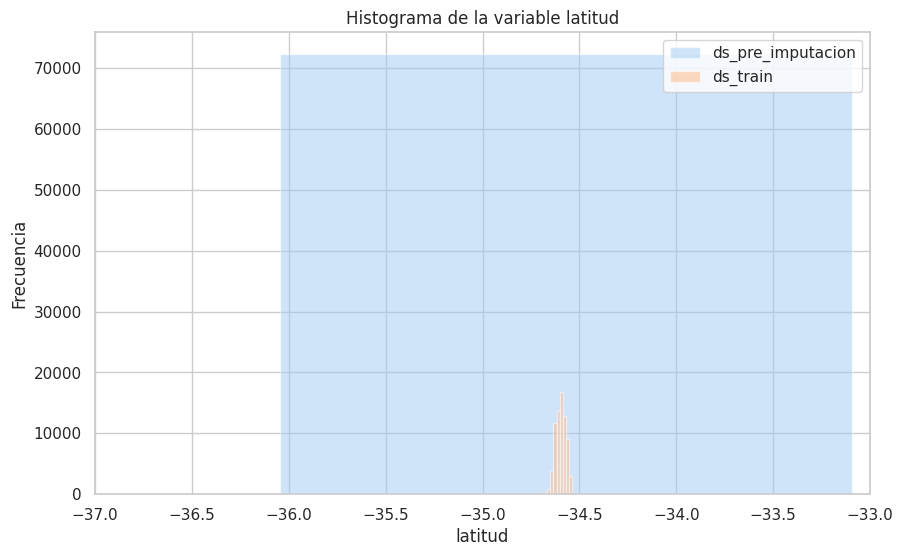

In [947]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['latitud'], bins=10, alpha=0.5, label='ds_train')

plt.xlim(-37, -33)

plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

plt.legend()

plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [948]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

latitud  cantidad
0     -34.541250       107
1     -34.619406       100
2     -34.604538        90
3     -34.541616        84
4     -34.582098        78
...          ...       ...
39379 -34.621109         1
39380 -34.550194         1
39381 -34.568745         1
39382 -34.588297         1
39383 -34.595472         1

[39384 rows x 2 columns]

In [949]:
post_latitud = obtener_cantidad_variables(ds_train,'latitud')
post_latitud

latitud  cantidad
0     -34.541250       107
1     -34.619406       100
2     -34.604538        90
3     -34.541616        84
4     -34.582098        78
...          ...       ...
39242 -34.634612         1
39243 -34.620595         1
39244 -34.621109         1
39245 -34.550194         1
39246 -34.595472         1

[39247 rows x 2 columns]

Parecieran ser iguales... pero lo hemos imputado

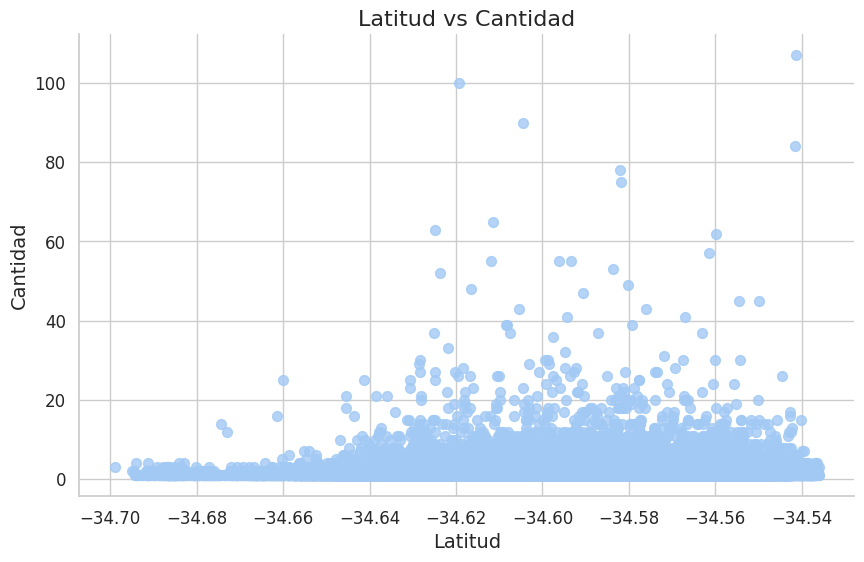

In [950]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_latitud['latitud'], post_latitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Latitud vs Cantidad", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [951]:
pre_latitud.equals(post_latitud)

False

In [952]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

39384
39247
diferencia: 137


#### Comparación longitud

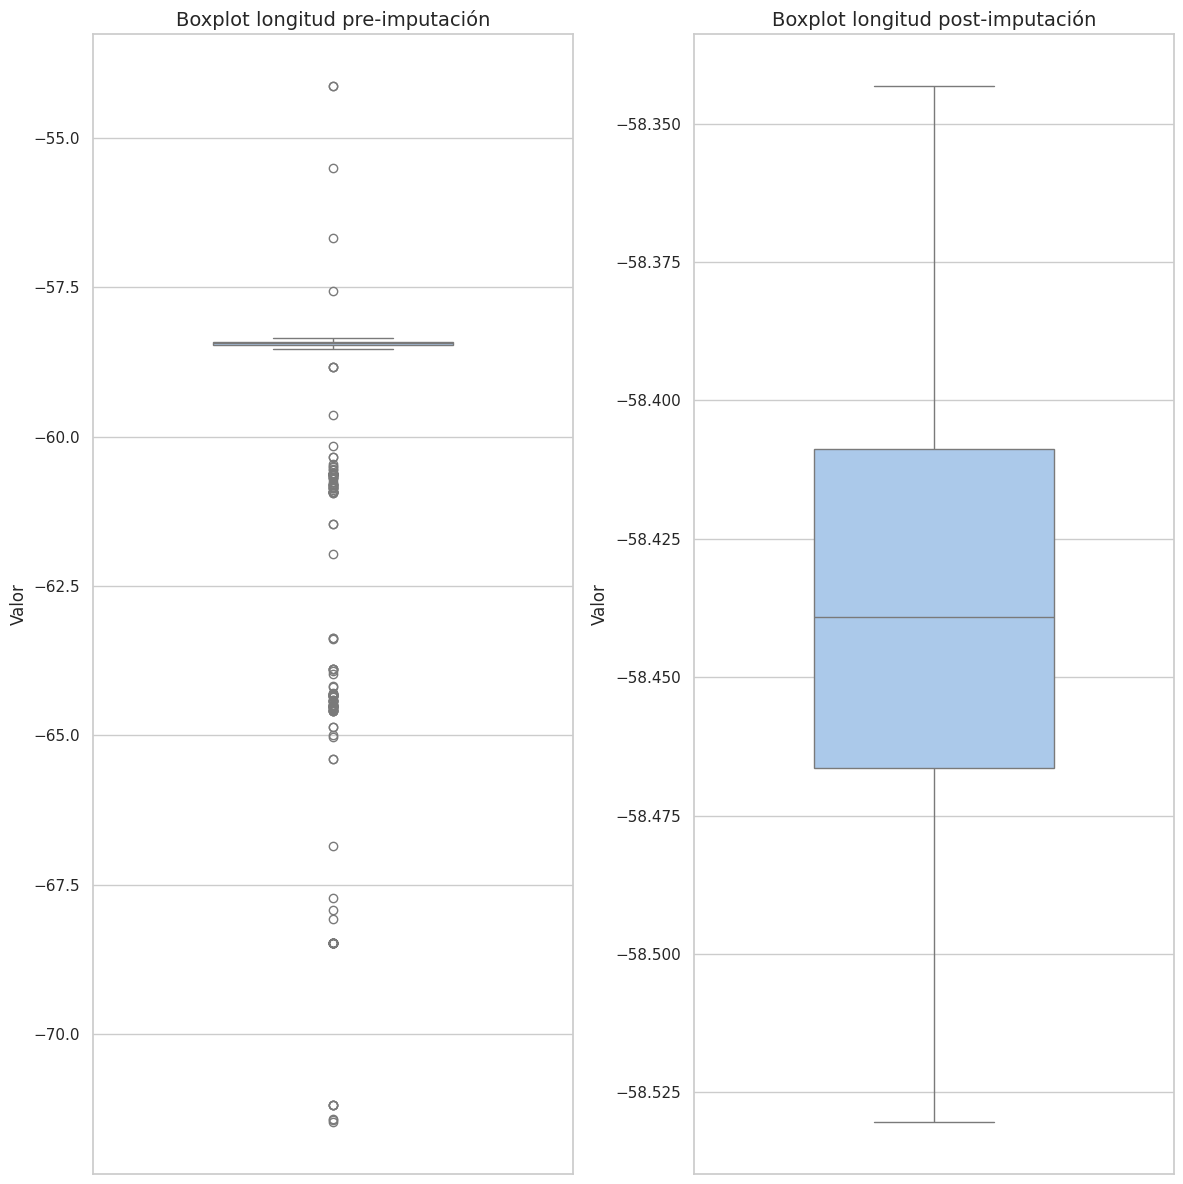

In [953]:
generar_distribucion("longitud")

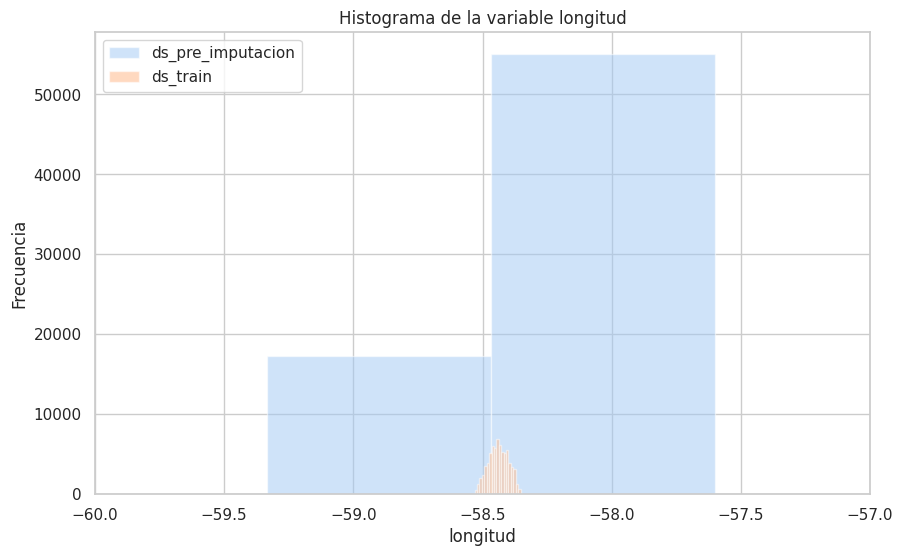

In [954]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['longitud'], bins=20, alpha=0.5, label='ds_train')


plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")

plt.xlim(-60, -57)

plt.legend()

plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.3 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [955]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

longitud  cantidad
0 -58.472966       107
1 -58.451999       100
2 -58.424956        90
3 -58.473377        84
4 -58.448859        78

In [956]:
post_longitud = obtener_cantidad_variables(ds_train,'longitud')
post_longitud.head()

longitud  cantidad
0 -58.472966       107
1 -58.451999       100
2 -58.424956        90
3 -58.473377        84
4 -58.448859        78

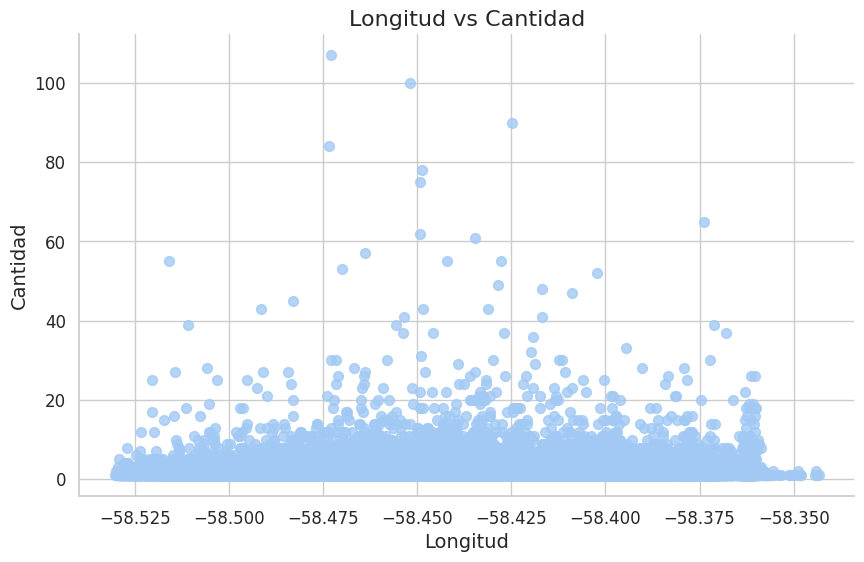

In [957]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_longitud['longitud'], post_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [958]:
pre_longitud.equals(post_longitud)

False

In [959]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

39150
39014
diferencia: 136


#### Comparación place_l3

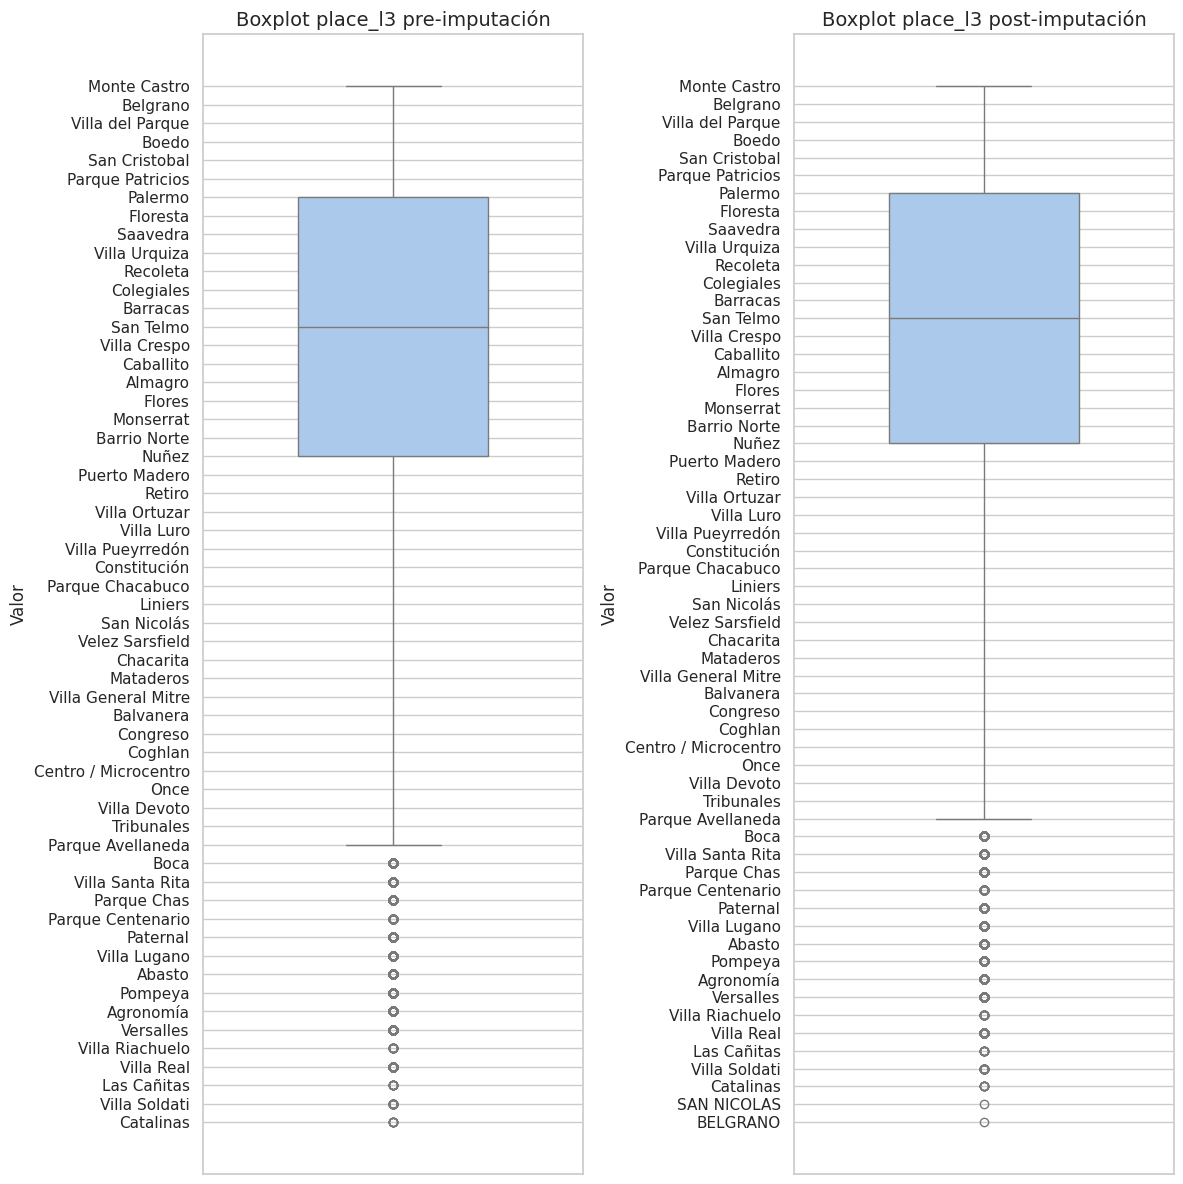

In [960]:
generar_distribucion("place_l3")

Como los datos nulos en la variable place_l3 era de 0.454913. No se observan grandes cambios en el gráfico.
Podemos notar que la media de Palermo se mantiene, lo mismo con Villa del Parque y Belgrano.

In [961]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

place_l3  cantidad
0        Palermo     11397
1       Belgrano      7189
2      Caballito      5722
3       Recoleta      5031
4  Villa Urquiza      3771

In [962]:
post_barrio = obtener_cantidad_variables(ds_train,'place_l3')
post_barrio.head()

place_l3  cantidad
0        Palermo     10672
1       Belgrano      6649
2      Caballito      5592
3       Recoleta      4849
4  Villa Urquiza      3653

In [963]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

725 registros se imputaron con el valor de Palermo place_l3
540 registros se imputaron con el valor de Belgrano place_l3
130 registros se imputaron con el valor de Caballito place_l3
182 registros se imputaron con el valor de Recoleta place_l3
118 registros se imputaron con el valor de Villa Urquiza place_l3
128 registros se imputaron con el valor de Almagro place_l3
180 registros se imputaron con el valor de Nuñez place_l3
90 registros se imputaron con el valor de Villa Crespo place_l3
94 registros se imputaron con el valor de Flores place_l3
147 registros se imputaron con el valor de Barrio Norte place_l3
55 registros se imputaron con el valor de Balvanera place_l3
6 registros se imputaron con el valor de Villa Devoto place_l3
10 registros se imputaron con el valor de Colegiales place_l3
5 registros se imputaron con el valor de Saavedra place_l3
8 registros se imputaron con el valor de Villa del Parque place_l3
55 registros se imputaron con el valor de Puerto Madero place_l3
10 regis

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

### *Prefacio*

Recordando lo visto en la sección de variables cualitativas en Exploración inicial.

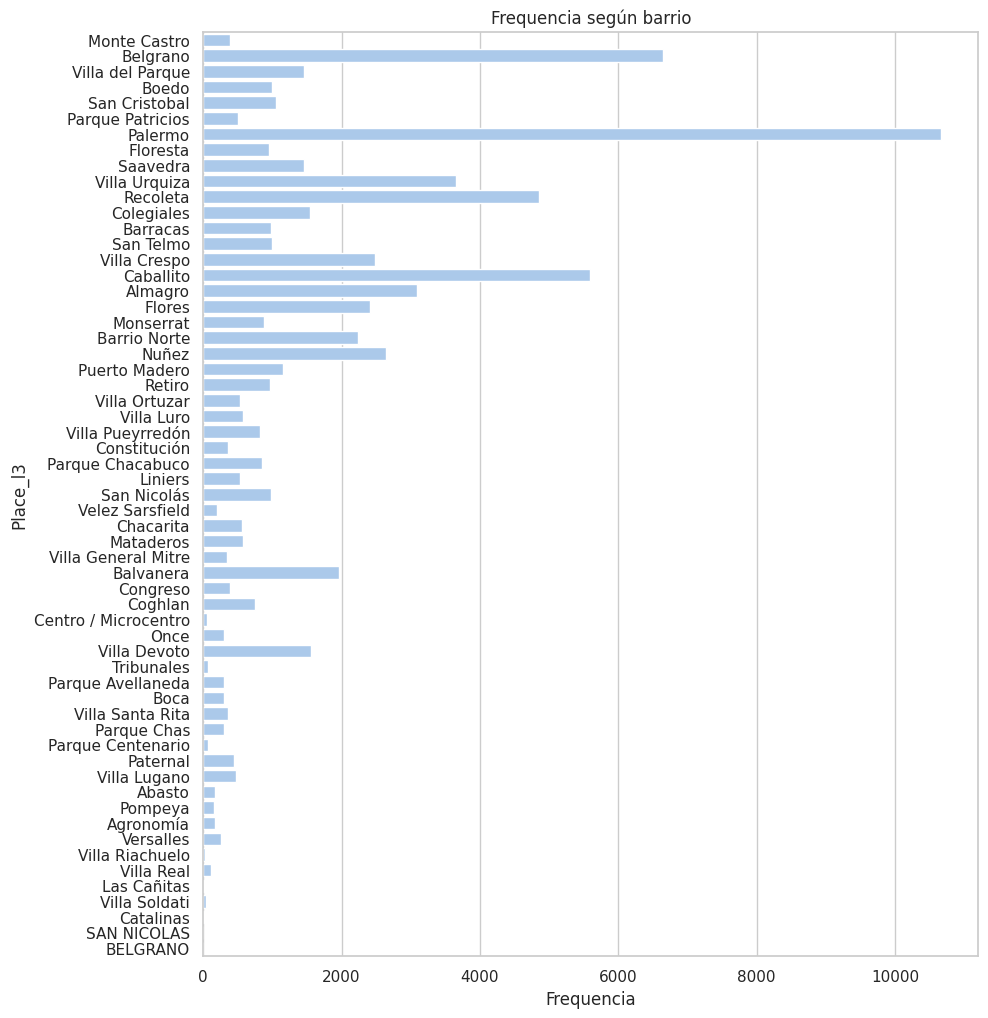

In [964]:
# Hacemos un gráfico de frecuencias de los barrios
plt.figure(figsize=(10, 12))
sns.countplot(y=ds_train.place_l3)
plt.xlabel('Frequencia')
plt.ylabel('Place_l3')
plt.title('Frequencia según barrio')
plt.show()

Vemos que Belgrano y San nicolas estan repetidos pero con mayuscula, arreglamos eso cambiando las mayusculas por minusculas.

In [965]:
# Cambiar mayus por minus
ds_train.loc[ds_train['place_l3'] == 'BELGRANO', 'place_l3'] = 'Belgrano'
ds_train.loc[ds_train['place_l3'] == 'SAN NICOLAS', 'place_l3'] = 'San Nicolás'

Las Cañitas, Catalinas, San Nicolas tienen una representación nula/casi nula.
Villa Soldati, Microcentro, Parque Centenario, Villa Riachuelo, Tribunales tienen una representación tan pequeña que tenemos que tener en cuenta que los registros pueden ser casos aislados/no representativos de la realidad de las ventas de inmuebles en el barrio.

In [966]:
# Hacemos una copia del dataset hasta el momento
ds_atipicos = ds_train.copy()

Funciones auxiliares para el análisis:



In [967]:
#Función para cálculo de limite superior e inferior de outliers según cuartiles
def limite_rango_iq(df, variable):
  # Cuartiles
  Q1 = np.quantile(df[variable], 0.25)
  Q3 = np.quantile(df[variable], 0.75)

  # Rango intercuartil
  IQR = Q3 - Q1

  # Limite inferior Outliers
  out_inf = Q1 - 1.5 * IQR

  # Limite superior Outliers
  out_sup = Q1 + 1.5 * IQR

  return out_inf, out_sup

# Funcion para cálculo de Z Score normal
def calculo_z_score(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

#Función para calculo de Z Score modificado
def calculo_z_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

# Grafico comparativo
def plot_comparativo(df_antes, df_despues, var):

  # Create subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot for df_antes
  sns.boxplot(y=df_antes[var], ax=axs[0])
  axs[0].set_title('Antes')

  # Plot for df_despues
  sns.boxplot(y=df_despues[var], ax=axs[1])
  axs[1].set_title('Después')

  # Show plots
  plt.tight_layout()
  plt.show()
  return

# Boxplot por barrio de la variable a evaluar
def plot_por_barrio(df, var):
  # Lista de barrios
  barrios = ['Coghlan','Colegiales','Abasto','Nuñez','Constitución',
             'Boedo', 'San Nicolás', 'Retiro', 'Liniers', 'Almagro',
             'Boca', 'Palermo', 'Balvanera','Barracas', 'Caballito',
             'Villa Ortuzar', 'Villa Luro', 'Puerto Madero', 'Pompeya', 'Saavedra',
             'Parque Chacabuco', 'Belgrano', 'Recoleta', 'Floresta', 'Monserrat',
             'Villa del Parque', 'San Telmo', 'Villa Crespo', 'Tribunales', 'Once',
             'Barrio Norte', 'Villa Lugano', 'Congreso', 'Villa Urquiza', 'Mataderos',
             'Villa Devoto', 'Recoleta', 'San Cristobal', 'Villa Pueyrredon', 'Congreso']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, barrio in enumerate(barrios):
      filtered_data = df[df['place_l3'] == barrio]

      sns.boxplot(y=filtered_data[var], ax=axs[i])

      axs[i].set_title(f'{var} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return



### Análisis univariado

Vamos a intentar identificar los outliers univariados utilizando los IQR y el Z Score.

#### *Análisis según cantidad de habitaciones(property_bedrooms)*

<Axes: ylabel='property_bedrooms'>

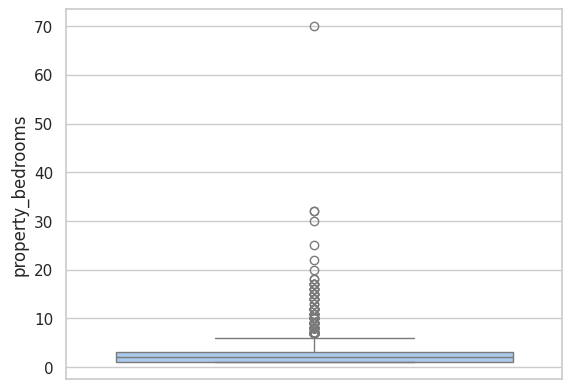

In [968]:
sns.boxplot(y=ds_train.property_bedrooms)

In [969]:
limite_rango_iq(ds_train, 'property_bedrooms')

(-2.0, 4.0)

Primero analizamos el outlier más notorio y verificamos si es un valor posible.

In [970]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 40]
outlier

id  start_date    end_date created_on    latitud  \
94998  4TbEkLoqy/0c3zakd66/FQ==  2021-09-24  2022-01-27 2021-09-24 -34.646632   

        longitud    place_l3 property_type  property_rooms  property_bedrooms  \
94998 -58.497902  Villa Luro  Departamento             3.0               70.0   

       property_surface_total  property_surface_covered  property_price  
94998                  1269.0                      70.0        135000.0

Es un departamento de 3 ambientes con 70 habitaciones, lo cual no es posible. Tampoco podemos asumir que es un error de tipeo. A su vez, la superficie total es exagerada en comparación de la superficie cubierta y el precio de la propiedad.  Vamos a eliminar el outlier y visualizar nuevamente el código.  

<Axes: ylabel='property_bedrooms'>

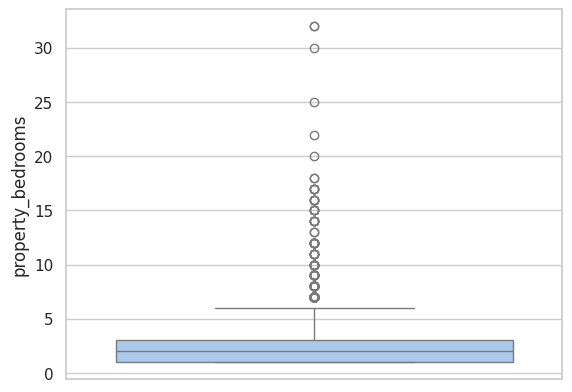

In [971]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_bedrooms'] > 40].index
ds_train.drop(id_outlier,inplace=True)

# Visualizamos
sns.boxplot(y=ds_train.property_bedrooms)

Existen muchos valores atípicos por sobre el umbral marcado por los cuartiles, pero teniendo en cuenta que estamos trabajando con casas, PH y departamentos unicamente, revisaremos las anomalías mayores a 15, a partir de donde no hay muchas ocurrencias.



In [972]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 15]
outlier

id  start_date    end_date created_on  \
49960   O/JMW/VVo7OmWF7SkXtBuA==  2021-10-16  2021-12-24 2021-10-16   
402448  9OrT+9jZlW4rMGyZYsmNPA==  2021-09-07  2022-02-09 2021-09-07   
346602  yzI9zylc11wllHX16av6jA==  2021-09-30  2021-11-02 2021-09-30   
208593  CtbHDgBLf3+kTc20y2iVhw==  2021-11-29  2022-01-14 2021-11-29   
332857  760pAR/aW7whZAZRLML/ZA==  2021-09-17  2022-02-25 2021-09-17   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
90004   TEs1aRnhJPwR0jRMq/Vzdg==  2021-08-03  9999-12-31 2021-08-03   
354668  +SPkA/Y4DHEHf+HIppYFKg==  2021-03-31  2021-04-16 2021-03-31   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   
32758   KA441xdi8PtuWBvjcAbGOQ==  2021-02-08  2021-03-01 2021-02-08   
285222  WHu8kgA8Vu692UM8Dz3gnA==  2021-02-24  2022-02-09 2021-02-24   
307211  uqM9/WXFJkEJnXEQefcpRQ==  2021-09-19  2021-09-19 2021-09-19   
389282  +xTrflFUv4fEGjwpwhP68w==  2021-05-05  2021-06-05 2021-05-05   
366101  8o3ZwoXgOddHoex/irib7g==  2021-04-10  2021-06-05 2021-04-10   
115403  VuF9cBcZ03aoEcEWAsWGjA==  2021-12-07  2022-01-27 2021-12-07   
362676  Gj3g5KCtRbYcwZIuh/wJGg==  2021-01-16  2021-08-06 2021-01-16   

          latitud   longitud          place_l3 property_type  property_rooms  \
49960  -34.630186 -58.389156  Parque Patricios  Departamento             1.0   
402448 -34.611413 -58.389221         Monserrat          Casa            17.0   
346602 -34.632537 -58.360577              Boca  Departamento            19.0   
208593 -34.629796 -58.363928              Boca            PH            18.0   
332857 -34.611905 -58.382384         Monserrat  Departamento            18.0   
86014  -34.591110 -58.400685          Recoleta  Departamento             4.0   
140832 -34.588454 -58.385257          Recoleta  Departamento             5.0   
36421  -34.576061 -58.421289           Palermo  Departamento             3.0   
90004  -34.633236 -58.480313          Floresta            PH            32.0   
354668 -34.611905 -58.382384         Monserrat            PH            15.0   
150885 -34.642037 -58.438995  Parque Chacabuco  Departamento            35.0   
32758  -34.632698 -58.360514              Boca            PH            19.0   
285222 -34.638432 -58.369712          Barracas            PH            20.0   
307211 -34.611905 -58.382384         Monserrat            PH            15.0   
389282 -34.570959 -58.458106          Belgrano          Casa            28.0   
366101 -34.648922 -58.380522          Barracas          Casa            18.0   
115403 -34.598070 -58.444686      Villa Crespo            PH            17.0   
362676 -34.618485 -58.377993         San Telmo          Casa            16.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
49960                32.0                    32.0                      32.0   
402448               16.0                   585.0                     458.0   
346602               18.0                   372.0                     318.0   
208593               17.0                   386.0                     323.0   
332857               17.0                   554.0                     334.0   
86014                30.0                   148.0                     138.0   
140832               22.0                   511.0                     144.0   
36421                20.0                   127.0                     117.0   
90004                32.0                   535.0                     435.0   
354668               16.0                   587.0                     276.0   
150885               25.0                    37.0                      33.0   
32758                18.0                   372.0                     318.0   
285222               17.0                   807.0                     470.0   
307211               16.0                   587.0    

Tenemos 230 anomalías. Los casos donde el número de ambientes es razonable, parece error de tipeo. Lo corregimos

In [973]:
condition = (ds_train['property_bedrooms'] > 15) & (ds_train['property_rooms'] < 10)
ds_train.loc[condition, 'property_surface_covered'] /= 10

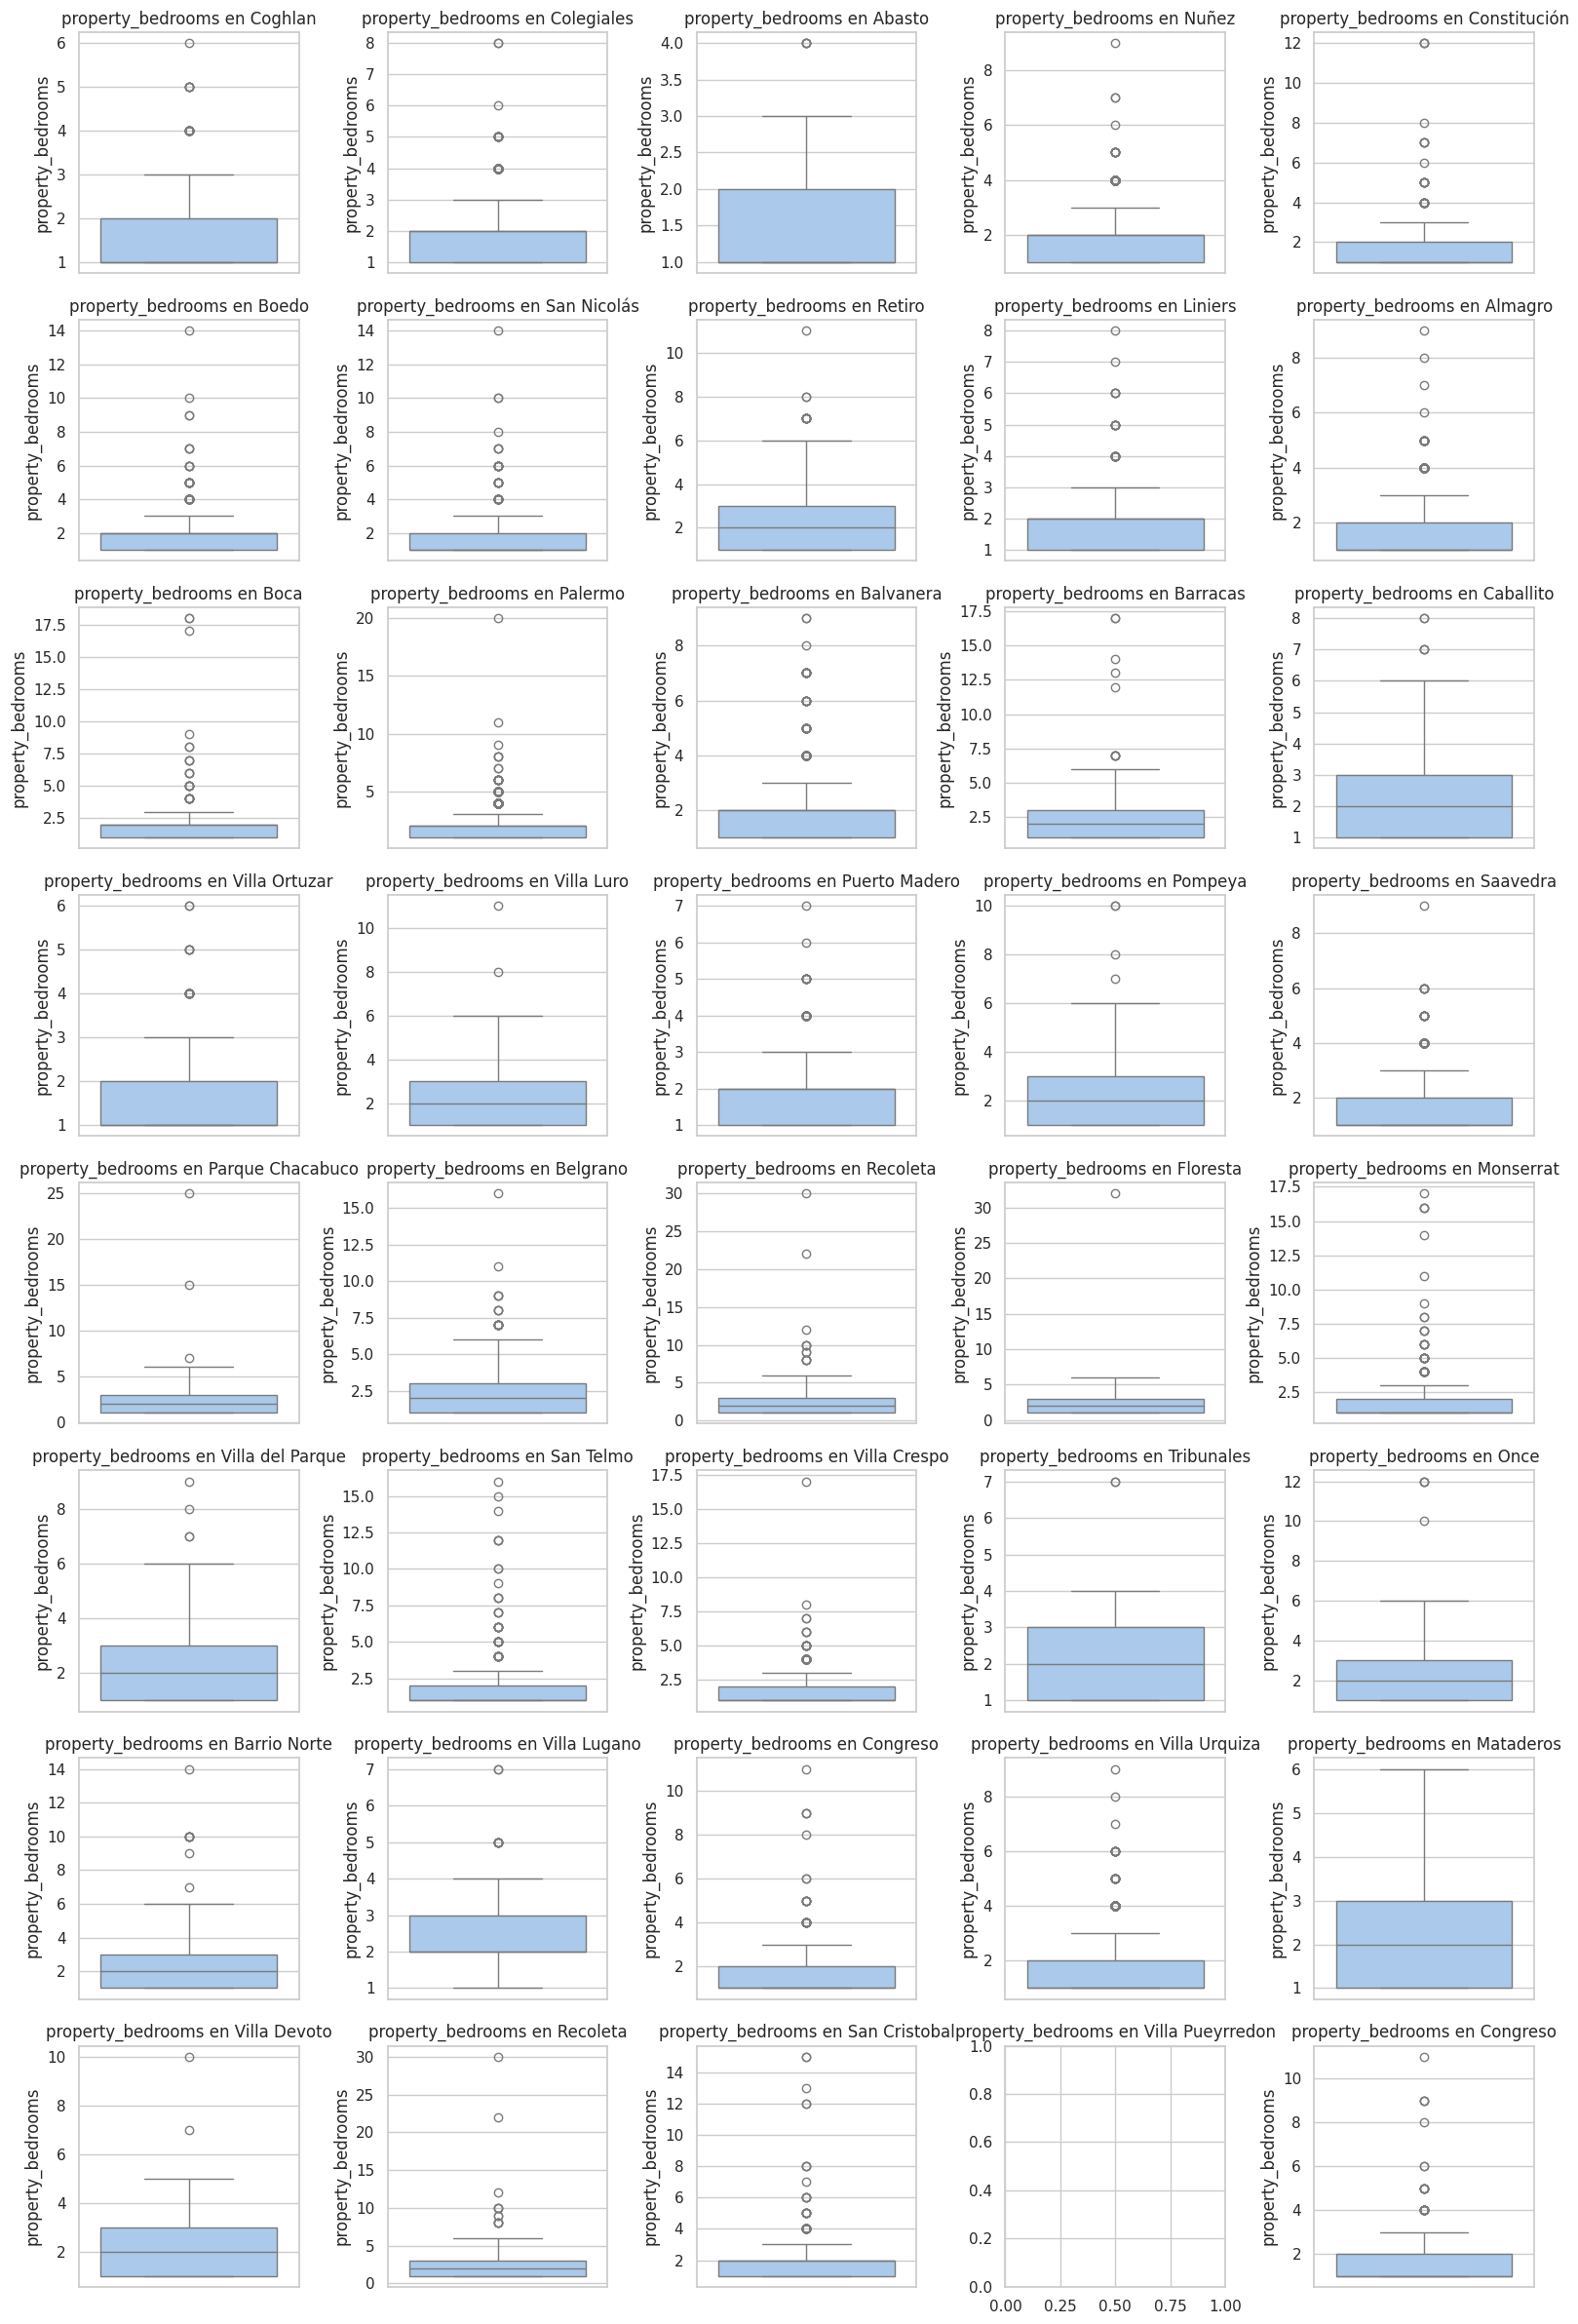

In [974]:
plot_por_barrio(ds_train, 'property_bedrooms')

Analizando los boxplot de la cantidad de habitaciones pero dividido según el barrio en el que se encuentra la propiedad, podemos ver aún teniendo en cuenta las variaciones, que aquellos casos de casas con más de 8 habitaciones son outliers extremos y decidimos normalizarlas utilizando una transformación logaritmica.

Nota: el limite intercuartil en general para la zona de CABA era 4, pero como vemos en barrios como Caballito esto se encuentra totalmente dentro de la norma.

In [975]:
ds_train.loc[ds_train['property_bedrooms'] > 7.0, 'property_bedrooms'] = np.log(ds_train['property_bedrooms'])

In [976]:
ds_train[ds_train['property_bedrooms'] > 6]

id  start_date    end_date created_on  \
245430  sw6Y2UwVsN+YOQz1D2MtCw==  2021-10-08  2022-02-09 2021-10-08   
400512  PzPchvZOPeXUFJaNFncqYg==  2021-06-17  2021-06-19 2021-06-17   
301648  mtpUHpAUZ4hE/PR4Bevnxw==  2021-08-10  2021-09-15 2021-08-10   
280738  myhAqyWgEy4mVpk5Jiwfyw==  2021-12-29  2022-02-09 2021-12-29   
342818  mqoxNDn8Gn/UkxbHPo7iOA==  2021-08-11  2021-09-01 2021-08-11   
...                          ...         ...         ...        ...   
86196   Dk7qNb11sh6gSEmk5qB4Bw==  2021-03-26  2021-06-05 2021-03-26   
398724  t0mG+MlvoUEuQxyELQvmgg==  2021-02-13  2021-07-26 2021-02-13   
342982  9k8Av+CJZI20KktSfTRtqg==  2021-08-11  2022-02-09 2021-08-11   
126403  ETzg09MPRQDliI9p8PzeBg==  2021-10-05  2022-02-22 2021-10-05   
198127  la5vVFPvjtlJv3F690Sn6A==  2021-02-14  2021-03-01 2021-02-14   

          latitud   longitud          place_l3 property_type  property_rooms  \
245430 -34.553050 -58.448411          Belgrano          Casa             8.0   
400512 -34.635382 -58.355539              Boca            PH             8.0   
301648 -34.593316 -58.377201            Retiro  Departamento             9.0   
280738 -34.629030 -58.456957            Flores          Casa             8.0   
342818 -34.616128 -58.394715         Balvanera          Casa             8.0   
...           ...        ...               ...           ...             ...   
86196  -34.617091 -58.373067         San Telmo            PH            10.0   
398724 -34.604668 -58.396573         Balvanera  Departamento             8.0   
342982 -34.644841 -58.407189  Parque Patricios          Casa             8.0   
126403 -34.564988 -58.444710          Belgrano  Departamento             5.0   
198127 -34.625901 -58.465396            Flores            PH            10.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
245430                7.0                   415.0                     415.0   
400512                7.0                   395.0                     319.0   
301648                7.0                   380.0                     350.0   
280738                7.0                   637.0                     637.0   
342818                7.0                   164.0                     143.0   
...                   ...                     ...                       ...   
86196                 7.0                   353.0                     250.0   
398724                7.0                   247.0                     232.0   
342982                7.0                   337.0                     200.0   
126403                7.0                   282.0                     282.0   
198127                7.0                   386.0                     231.0   

        property_price  
245430        820000.0  
400512        145000.0  
301648        650000.0  
280738       1100000.0  
342818        230000.0  
...                ...  
86196         460000.0  
398724        360000.0  
342982        230000.0  
126403       1300000.0  
198127        280000.0  

[92 rows x 13 columns]

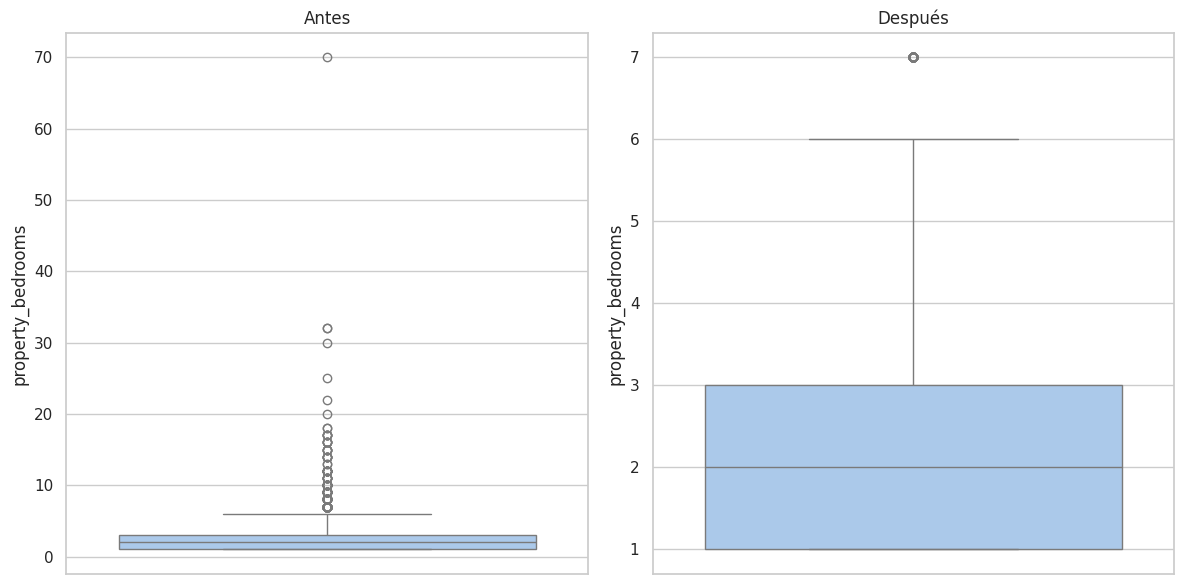

In [977]:
plot_comparativo(ds_atipicos, ds_train, 'property_bedrooms')

Podemos ver que se han solucionado la mayoría de las anomalías. Dejaremos las restantes (85 registros) para el análisis multivariado.

#### *Análisis según cantidad de ambientes (property_rooms)*

<Axes: ylabel='property_rooms'>

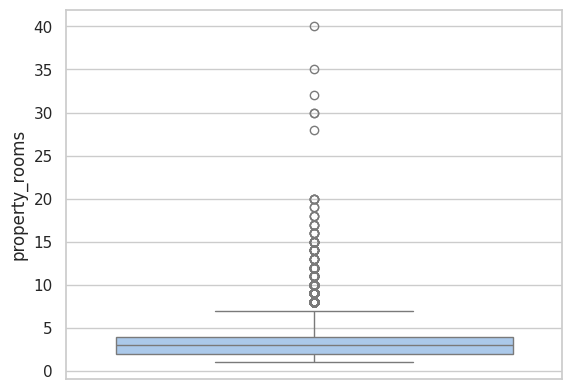

In [978]:
sns.boxplot(y=ds_train.property_rooms)

In [979]:
limite_rango_iq(ds_train, 'property_rooms')

(-1.0, 5.0)

El limite intercuartil superior es 5.0. Vemos que si bien hay muchos outliers por sobre el limite de 5 ambientes, esto se acentúa una vez que se superan los 20 ambientes.



In [980]:
# Observación anómala
outlier = ds_train[ds_train['property_rooms'] > 20]
outlier

id  start_date    end_date created_on  \
21009   bmop3OsDu5kJmbAVgJ5wzA==  2021-03-15  2021-06-05 2021-03-15   
356618  +e6yeZZqYElYRYq4/cd9qg==  2021-11-18  2021-12-02 2021-11-18   
52157   HwHiC1DJIxRAjUAOmujXsg==  2021-02-07  2021-06-15 2021-02-07   
90004   TEs1aRnhJPwR0jRMq/Vzdg==  2021-08-03  9999-12-31 2021-08-03   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   
389282  +xTrflFUv4fEGjwpwhP68w==  2021-05-05  2021-06-05 2021-05-05   

          latitud   longitud           place_l3 property_type  property_rooms  \
21009  -34.616391 -58.456038          Caballito  Departamento            30.0   
356618 -34.588742 -58.422459            Palermo  Departamento            40.0   
52157  -34.649872 -58.483012  Parque Avellaneda            PH            30.0   
90004  -34.633236 -58.480313           Floresta            PH            32.0   
150885 -34.642037 -58.438995   Parque Chacabuco  Departamento            35.0   
389282 -34.570959 -58.458106           Belgrano          Casa            28.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
21009            2.000000                    79.0                      79.0   
356618           3.000000                    75.0                      68.0   
52157            2.000000                    72.0                      60.0   
90004            3.465736                   535.0                     435.0   
150885           3.218876                    37.0                      33.0   
389282           2.772589                   845.0                     845.0   

        property_price  
21009         230000.0  
356618        145000.0  
52157         123500.0  
90004         300000.0  
150885         67000.0  
389282        950000.0

Si bien los datos de habitaciones y ambientes no son posibles, por ahora no serán borrados ya que el resto (superficie cubierta, precio) parecen coherentes con el resto del dataset y pueden ser útiles.

Controlaremos según barrio.

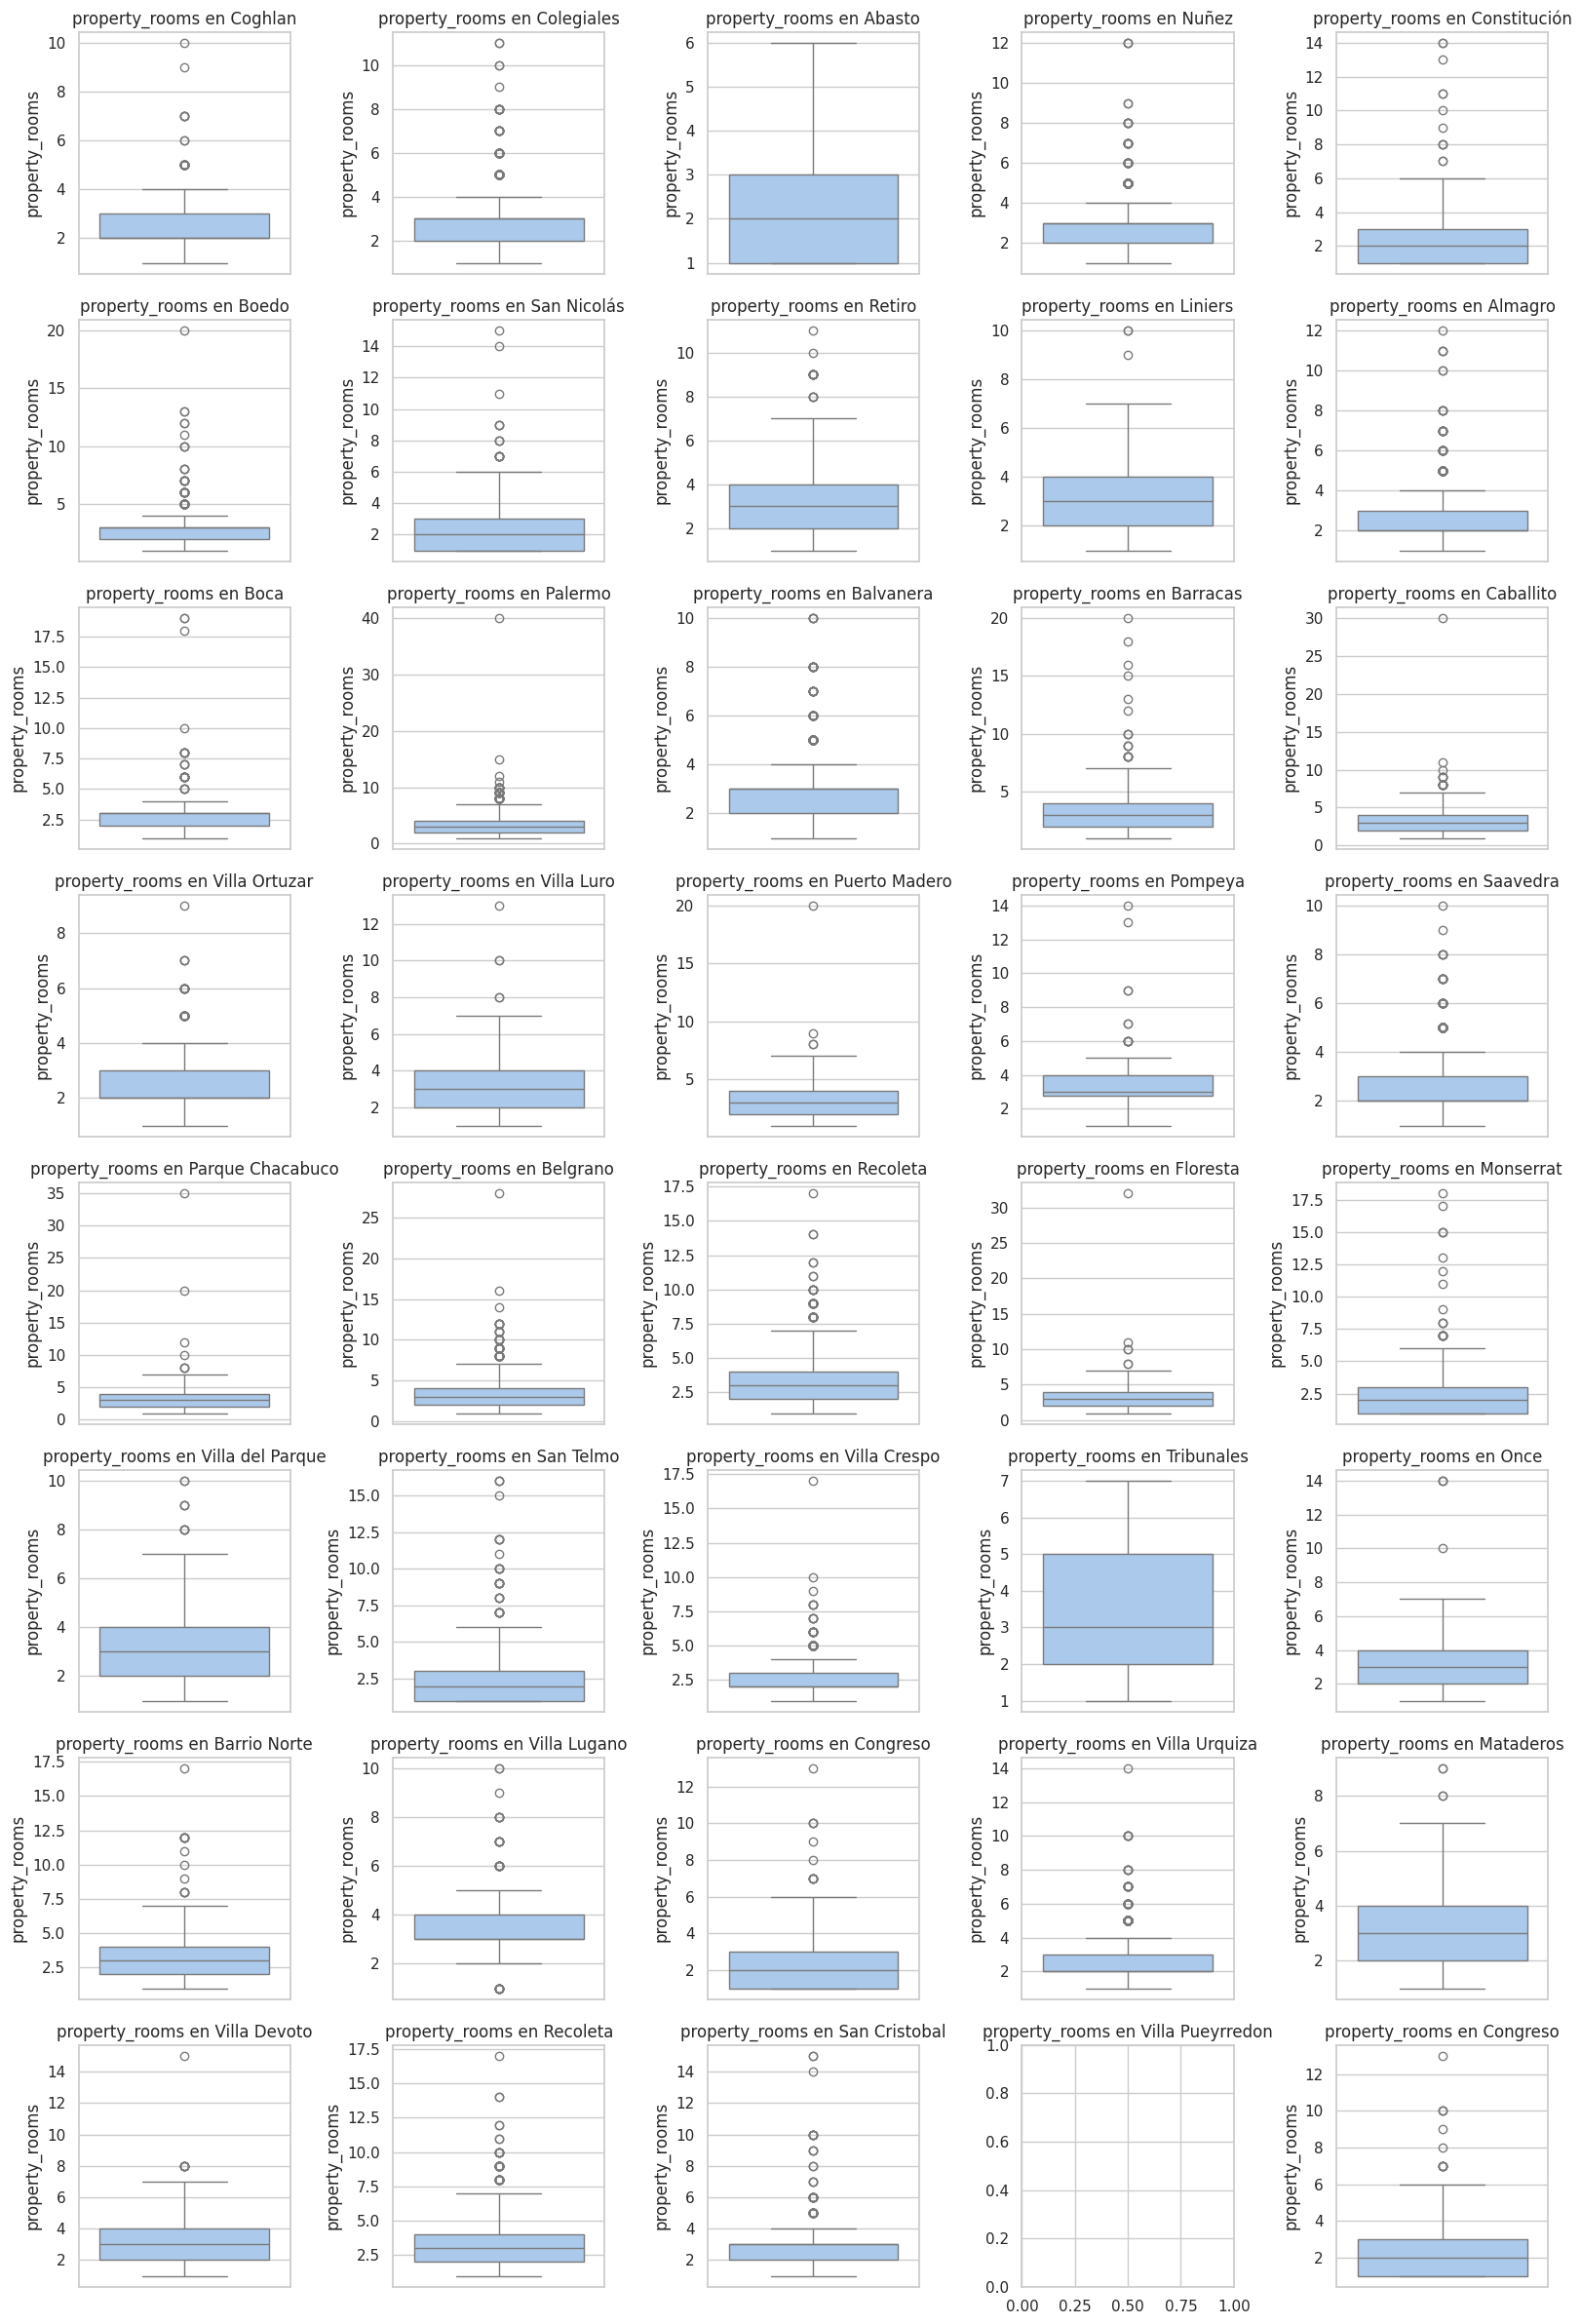

In [981]:
plot_por_barrio(ds_train, 'property_rooms')

Si bien nuestro límite intercuartil era de 5.0 vemos una tendencia un poco superior al ver los boxplot por barrio, así que realizaremos una corrección en aquellos registros atípicos que superen los 10 ambientes.

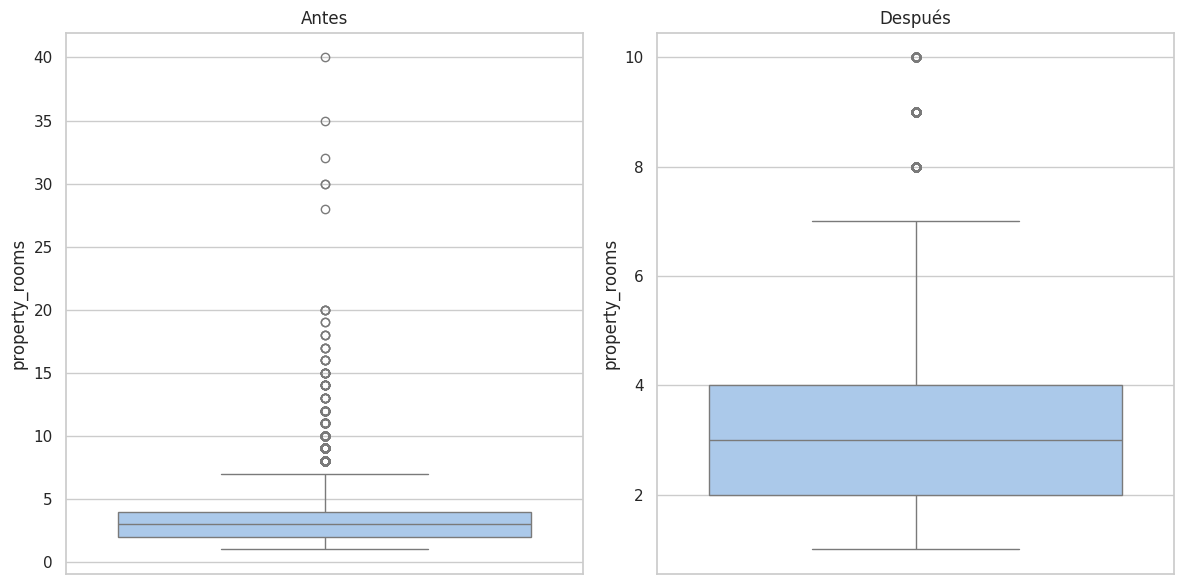

In [982]:
#Normalizacion logaritmica
ds_train.loc[ds_train['property_rooms'] > 10.0, 'property_rooms'] = np.log(ds_train['property_rooms'])

#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_rooms')

In [983]:
ds_train[(ds_train['property_rooms'] > 7.0)]

id  start_date    end_date created_on  \
269052  JfCitdXHFyPTdXY6C2ZSKw==  2021-01-19  2021-08-25 2021-01-19   
35772   YlLn73RCQP4pM51jaWJtNg==  2021-02-08  2021-03-01 2021-02-08   
260756  VDL8Zp27hprweAO9PzcN7w==  2021-04-14  2021-04-15 2021-04-14   
129078  HGXz4DykQOb/Bh4pIXqz5w==  2021-07-01  9999-12-31 2021-07-01   
147972  hFpUduGIlN7suuLIgilOdg==  2021-08-19  2022-01-27 2021-08-19   
...                          ...         ...         ...        ...   
282733  wkzFNIRXgczk5RddtufCBA==  2021-09-16  2021-12-04 2021-09-16   
407515  EC3gWXzl/tn5cLyAjXtV/g==  2021-03-05  2021-03-06 2021-03-05   
13826   kcbXwmqpBOT/nBRqvNo63Q==  2021-03-01  2021-03-05 2021-03-01   
419749  euijnt/LUZcSs2ybg+z+Jg==  2021-12-01  2022-01-27 2021-12-01   
439713  WjSPOpNqWFCGBOdoVcvPQQ==  2021-07-20  2022-02-17 2021-07-20   

          latitud   longitud          place_l3 property_type  property_rooms  \
269052 -34.575012 -58.457444        Colegiales          Casa            10.0   
35772  -34.639048 -58.431920  Parque Chacabuco          Casa             8.0   
260756 -34.592703 -58.388273          Recoleta  Departamento             8.0   
129078 -34.597318 -58.389639          Recoleta  Departamento             9.0   
147972 -34.605473 -58.387790       San Nicolás  Departamento             9.0   
...           ...        ...               ...           ...             ...   
282733 -34.590335 -58.390134          Recoleta  Departamento             9.0   
407515 -34.624097 -58.514166      Monte Castro          Casa             8.0   
13826  -34.624306 -58.513679      Monte Castro          Casa             8.0   
419749 -34.577053 -58.459783        Colegiales            PH             8.0   
439713 -34.616682 -58.370246         San Telmo            PH             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
269052           4.000000                   605.0                     600.0   
35772            5.000000                   240.0                     358.0   
260756           3.000000                   314.0                     314.0   
129078           2.079442                   160.0                     160.0   
147972           2.079442                   180.0                     156.0   
...                   ...                     ...                       ...   
282733           6.000000                   420.0                     411.0   
407515           4.000000                   270.0                     230.0   
13826            3.000000                   230.0                     230.0   
419749           4.000000                   340.0                     240.0   
439713           6.000000                   247.0                     177.0   

        property_price  
269052        650000.0  
35772         420000.0  
260756        980000.0  
129078        315000.0  
147972        175000.0  
...                ...  
282733       1350000.0  
407515        395000.0  
13826         395000.0  
419749        560000.0  
439713        320000.0  

[488 rows x 13 columns]

Tenemos 482 valores por sobre el máximo marcado por el bigote en el boxplot actual y que pueden ser considerados outliers. Reveeremos estos valores en otros análisis.

#### *Análisis según precio de la propiedad (property_price)*

<Axes: ylabel='property_price'>

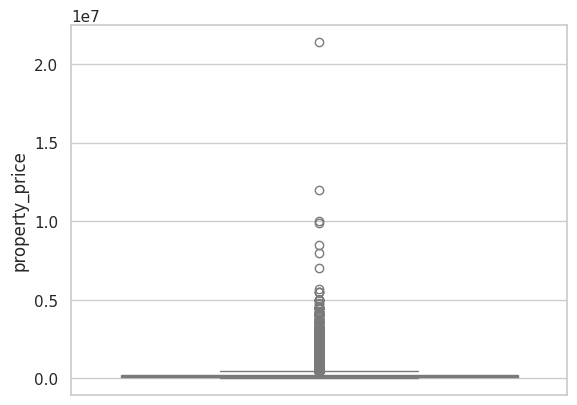

In [984]:
sns.boxplot(y=ds_train.property_price)

In [985]:
limite_rango_iq(ds_train, 'property_price')

(-115000.0, 305000.0)

Primero analizamos las anomalías más extremas, valores mayores o iguales a 8M.

In [986]:
# Observación anómala
outlier = ds_train[ds_train['property_price'] >= 8000000]
outlier

id  start_date    end_date created_on  \
60073   uoM9HDKq3jZKQKgHXTIGkg==  2021-01-25  2022-05-13 2021-01-25   
248285  I3+CMvLB+tmeXtDg3XmSBA==  2021-09-13  2021-09-16 2021-09-13   
332190  PkbD1ixa/IWHlTjwozccRQ==  2021-09-17  2022-03-09 2021-09-17   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
156777  8ChrVZoOYyEqAJMIP/pXoQ==  2021-02-17  2021-02-19 2021-02-17   
85725   pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26   

          latitud   longitud     place_l3 property_type  property_rooms  \
60073  -34.616044 -58.458621    Caballito  Departamento             3.0   
248285 -34.596801 -58.383768     Recoleta  Departamento             8.0   
332190 -34.593634 -58.377164       Retiro          Casa            10.0   
1140   -34.605781 -58.376705  San Nicolás  Departamento             4.0   
156777 -34.608300 -58.371200    Monserrat          Casa             3.0   
85725  -34.572494 -58.462433     Belgrano          Casa             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
60073            2.000000                    68.0                      64.0   
248285           2.000000                   900.0                     150.0   
332190           2.079442                  1166.0                    1485.0   
1140             2.000000                 10500.0                   10500.0   
156777           2.000000                   225.0                      93.0   
85725            4.000000                  3197.0                    3367.0   

        property_price  
60073       21400000.0  
248285       8000000.0  
332190      10000000.0  
1140         9900000.0  
156777       8500000.0  
85725       12000000.0

Buscando propiedades actualmente en venta en barrios y tamaños similares, parecería haber un error. Sin embargo, incluso haciendo un reducción de un decimo (valores más coherentes para esos varrios y tamaños de casas), estaríamos por sobre el límite intercuartil, asi que por ahora no haremos transformaciones.

Analicemos según barrio:

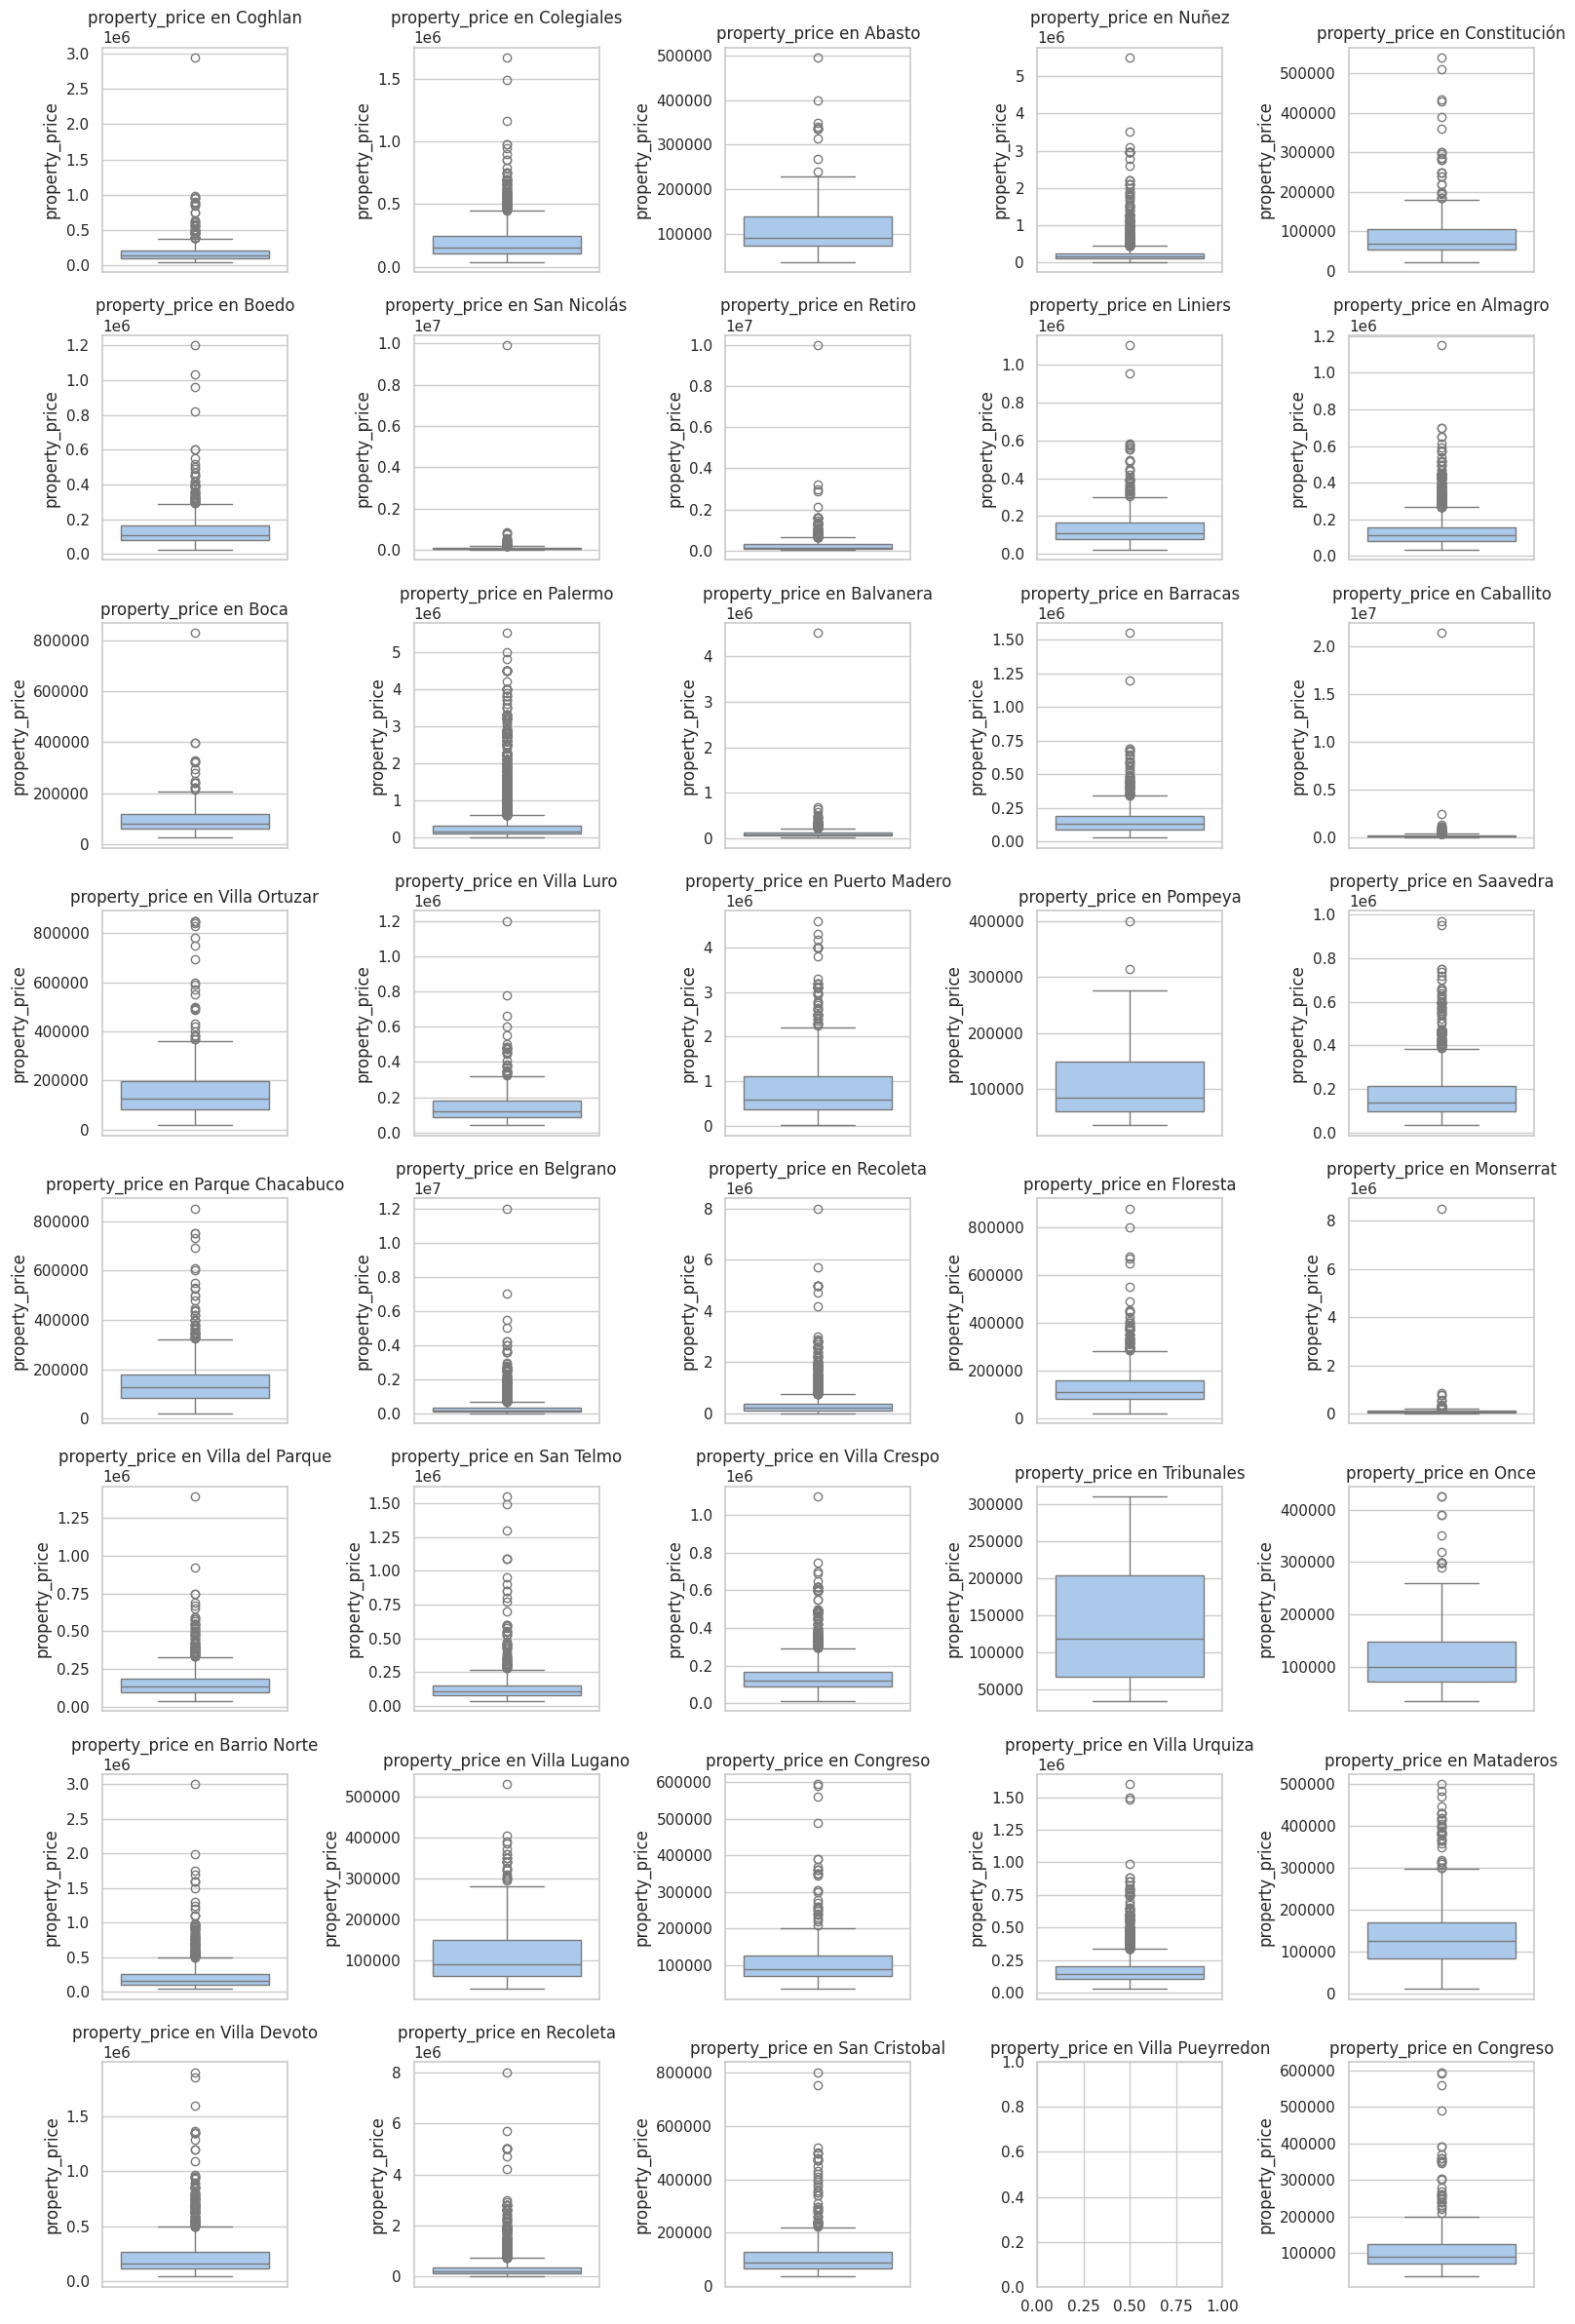

In [987]:
plot_por_barrio(ds_train, 'property_price')

Hasta el momento, este el analisis según barrio menos homogéneo. Si tomamos el limite superior intercuartil general (305m), se distorcionarían totalmente los datos de barrios como Palermo y Puerto Madero. Teniendo en cuenta lo relevante que es éste dato a la hora de que se establezca el precio de una propiedad, solo trabajaremos con los outliers que sean extremos en el contexto de cada barrio (analisis multivariado).

*Análisis según superficie cubierta (property_surface_covered)*

<Axes: ylabel='property_surface_covered'>

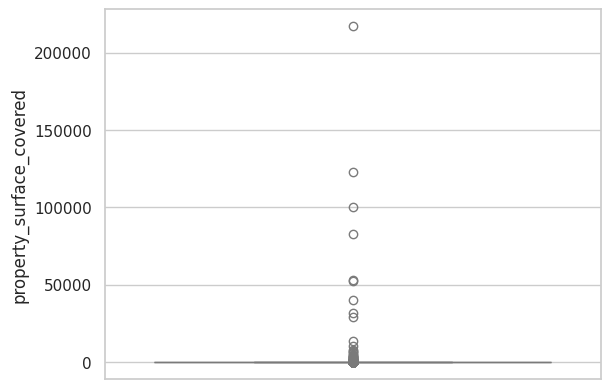

In [988]:
sns.boxplot(y=ds_train.property_surface_covered)

In [989]:
limite_rango_iq(ds_train, 'property_surface_covered')

(-32.0, 112.0)

In [990]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_covered'] <= 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [991]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_covered'].idxmin()
ds_train.loc[min_surface_index]

id                          NWN70rV/q2EBRj8mtV3Wxg==
start_date                                2021-01-12
end_date                                  2021-03-10
created_on                       2021-01-12 00:00:00
latitud                                   -34.570428
longitud                                  -58.477361
place_l3                               Villa Urquiza
property_type                                     PH
property_rooms                                   3.0
property_bedrooms                                2.0
property_surface_total                          40.0
property_surface_covered                         1.0
property_price                              215000.0
Name: 41944, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [992]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
158933  aSY0avf1JrLFubwhKOvZ+w==  2021-11-13  9999-12-31 2021-11-13   
53685   8uNgRjGK524+28yh99HH+A==  2021-09-22  2021-11-17 2021-09-22   
41944   NWN70rV/q2EBRj8mtV3Wxg==  2021-01-12  2021-03-10 2021-01-12   
55406   K6rVUOoLxClPVe6v6HIaFQ==  2021-01-11  9999-12-31 2021-01-11   
329672  SVZSg0hvus5NffUp5/o7yQ==  2021-08-12  2022-01-27 2021-08-12   
...                          ...         ...         ...        ...   
115235  vqGqcNhgsLKgLEaBsJWjXQ==  2021-12-07  2022-01-27 2021-12-07   
16727   bdoHCnqNuHsa+Tg0OH0/Yw==  2021-06-10  2021-08-19 2021-06-10   
264562  KhfTzWKoDZKLpt6eKYD2LA==  2021-02-26  2021-06-05 2021-02-26   
441137  1OTcQOtXSIHcpww5/XnJ5Q==  2021-07-20  2021-09-24 2021-07-20   
209180  LPtQmBX+zNf+bDv8xl1/yA==  2021-11-29  2022-01-27 2021-11-29   

          latitud   longitud       place_l3 property_type  property_rooms  \
158933 -34.623107 -58.394853  San Cristobal  Departamento             1.0   
53685  -34.554605 -58.437322       Belgrano  Departamento             1.0   
41944  -34.570428 -58.477361  Villa Urquiza            PH             3.0   
55406  -34.616000 -58.374853      San Telmo  Departamento             1.0   
329672 -34.585069 -58.420146        Palermo  Departamento             1.0   
...           ...        ...            ...           ...             ...   
115235 -34.587005 -58.450170      Chacarita  Departamento             1.0   
16727  -34.595644 -58.416938        Almagro  Departamento             1.0   
264562 -34.599300 -58.434304   Villa Crespo  Departamento             1.0   
441137 -34.603593 -58.376756    San Nicolás  Departamento             1.0   
209180 -34.573630 -58.432361        Palermo  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
158933                1.0                    39.0                       4.0   
53685                 1.0                    40.0                       5.0   
41944                 2.0                    40.0                       1.0   
55406                 1.0                    38.0                       4.0   
329672                1.0                    24.0                       1.0   
...                   ...                     ...                       ...   
115235                1.0                    33.0                       1.0   
16727                 1.0                    31.0                       1.0   
264562                1.0                    37.0                       3.0   
441137                1.0                    20.0                       1.0   
209180                1.0                    24.0                       1.0   

        property_price  
158933         74000.0  
53685         115000.0  
41944         215000.0  
55406          72000.0  
329672         60000.0  
...                ...  
115235         85000.0  
16727          82000.0  
264562        108000.0  
441137         39000.0  
209180         89000.0  

[487 rows x 13 columns]

Tenemos 484 registros de propiedades que tienen menos de 15m^2 cubiertos, y si bien según código urbanistico de la Ciudad de Buenos Aires no permite departamentos tan pequeños, sabemos que eso puede infringirse. Bajo estos supuestos, y viendo los registros que aparecen, vamos a reemplazar aquellos con superficies demasiado pequeñas (menores a 10m^2) por la superficie total.

In [993]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_covered'] = ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_total']

In [994]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
410024  ZCM+3YdmvreGkH7NL6VHGA==  2021-03-19  2021-06-05 2021-03-19   
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
92654   zt51kd/217iX/xx8cRl3oQ==  2021-08-03  9999-12-31 2021-08-03   
390456  D1YXlNA2VtgRssG/F5GqYQ==  2021-05-05  2021-06-05 2021-05-05   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
264261  o2Pf0aO+jXXSAYM9qcEmzA==  2021-02-26  9999-12-31 2021-02-26   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
17892   QsHoM/bm2HdBBEwnWY+RgA==  2021-08-28  2022-01-27 2021-08-28   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
272255  SYaRVm6FpvDHUvyQF7k11w==  2021-06-19  2021-08-27 2021-06-19   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
256405  ogCDRHXTMAni1s5mbB8inA==  2021-11-03  2021-11-09 2021-11-03   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
95088   Q5u5v/WYM0C1/XVg1Db86Q==  2021-09-24  2022-03-09 2021-09-24   
401698  BIT3OESAkwXpejzzcVCMiA==  2021-06-17  2021-08-03 2021-06-17   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
295855  YLrVFJt3421Rss33A6OVAA==  2021-07-23  9999-12-31 2021-07-23   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
129239  mrYs9YBzhLRsHBkNWDHBvQ==  2021-07-01  2021-11-25 2021-07-01   
66841   G+GKcWUzDUZgWgNbR0qvvQ==  2021-11-24  2022-01-27 2021-11-24   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   

          latitud   longitud          place_l3 property_type  property_rooms  \
410024 -34.618153 -58.362615     Puerto Madero  Departamento             1.0   
76920  -34.625870 -58.384003      Constitución  Departamento             1.0   
178234 -34.609567 -58.384745         Monserrat  Departamento             1.0   
92654  -34.592771 -58.379036          Recoleta  Departamento             1.0   
390456 -34.597768 -58.493337  Villa del Parque  Departamento             1.0   
38433  -34.600832 -58.390383        Tribunales  Departamento             1.0   
264261 -34.627828 -58.490255          Floresta  Departamento             1.0   
86014  -34.591110 -58.400685          Recoleta  Departamento             4.0   
72233  -34.597934 -58.376981            Retiro  Departamento             1.0   
17892  -34.621756 -58.444437         Caballito  Departamento             1.0   
168108 -34.606525 -58.430740         Caballito  Departamento             3.0   
272255 -34.621756 -58.444437         Caballito  Departamento             1.0   
225485 -34.597825 -58.376983            Retiro  Departamento             1.0   
140832 -34.588454 -58.385257          Recoleta  Departamento             5.0   
256405 -34.579846 -58.453041           Palermo  Departamento             1.0   
299    -34.597934 -58.376981            Retiro  Departamento             1.0   
36421  -34.576061 -58.421289           Palermo  Departamento             3.0   
95088  -34.588030 -58.414562      Barrio Norte  Departamento             1.0   
401698 -34.592771 -58.379036          Recoleta  Departamento             1.0   
216786 -34.621967 -58.372598         San Telmo  Departamento             1.0   
295855 -34.579351 -58.454196        Colegiales  Departamento             1.0   
333830 -34.600456 -58.376960            Retiro  Departamento             1.0   
129239 -34.594277 -58.504012      Villa Devoto  Departamento             1.0   
66841  -34.594277 -58.504012      Villa Devoto  Departamento             1.0   
168082 -34.606525 -58.430740         Caballito  Departamento             3.0   
168064 -34.606525 -58.430740    

Ahora nos quedan 20 registros unicamente.

In [995]:
ds_train[ds_train['property_surface_covered'] > 15000]

id  start_date    end_date created_on  \
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
199905  EDZUWORq83zRgdk9Zqlv+A==  2021-07-25  9999-12-31 2021-07-25   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   

          latitud   longitud          place_l3 property_type  property_rooms  \
72521  -34.600113 -58.403649         Balvanera  Departamento        2.000000   
352883 -34.550093 -58.483034          Saavedra  Departamento        1.000000   
199905 -34.604362 -58.392366      Barrio Norte  Departamento        4.000000   
72316  -34.578917 -58.429373           Palermo  Departamento        2.000000   
1932   -34.637026 -58.426283  Parque Chacabuco          Casa        2.995732   
106598 -34.587320 -58.401556      Barrio Norte  Departamento        2.000000   
372779 -34.555278 -58.459786          Belgrano  Departamento        4.000000   
405324 -34.569963 -58.481658     Villa Urquiza            PH        4.000000   
117835 -34.550093 -58.483034          Saavedra  Departamento        2.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
72521             1.00000                 33800.0                   31670.0   
352883            1.00000                 29064.0                   29064.0   
199905            3.00000                    83.0                   83000.0   
72316             1.00000                 61130.0                   53030.0   
1932              2.70805                186292.0                  217000.0   
106598            1.00000                 56740.0                   52540.0   
372779            3.00000                100068.0                  100051.0   
405324            3.00000                123000.0                  123000.0   
117835            1.00000                 43086.0                   40038.0   

        property_price  
72521          66000.0  
352883         87400.0  
199905        155000.0  
72316         225000.0  
1932          250000.0  
106598        175000.0  
372779        420000.0  
405324        165000.0  
117835        114000.0

Los casos de propiedades con superficie cubierta mayor a 15000, parecen ser errores de escala que pueden solucionarse facilmente.

In [996]:
condition = ds_train['property_surface_covered'] > 15000
ds_train.loc[condition, 'property_surface_covered'] /= 1000

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 15000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [997]:
ds_train[ds_train['property_surface_covered'] > 4000]

id  start_date    end_date created_on  \
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
314541  /lzClyxH96pdJl/JI2ofKg==  2021-01-06  2021-01-09 2021-01-06   
398069  Z41Yr6x3GUjyoxu+Afv4og==  2021-02-13  2021-03-18 2021-02-13   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
94789   jXPtdq0ibrnXyePLhTi27g==  2021-09-24  2021-09-26 2021-09-24   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   

          latitud   longitud       place_l3 property_type  property_rooms  \
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
314541 -34.555086 -58.459669       Belgrano  Departamento             1.0   
398069 -34.558309 -58.459923       Belgrano  Departamento             2.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   
1140   -34.605781 -58.376705    San Nicolás  Departamento             4.0   
459841 -34.627876 -58.437996      Caballito  Departamento             3.0   
94789  -34.614279 -58.361092      Caballito  Departamento             2.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
459842                2.0                  8136.0                    6472.0   
264624                4.0                 14744.0                   13717.0   
314541                1.0                  5741.0                    4276.0   
398069                1.0                  6470.0                    4664.0   
459849                2.0                  7720.0                    5970.0   
1140                  2.0                 10500.0                   10500.0   
459841                2.0                  7153.0                    7153.0   
94789                 1.0                  5312.0                    4809.0   
405272                3.0                  8306.0                    7755.0   

        property_price  
459842        203550.0  
264624        330000.0  
314541         85144.0  
398069        149900.0  
459849        167894.0  
1140         9900000.0  
459841        177807.0  
94789         145000.0  
405272        129000.0

Mismo que con las propiedades con superficie cubierta mayor a 5000, parece ser un problema de escala.

In [998]:
condition = ds_train['property_surface_covered'] > 4000
ds_train.loc[condition, 'property_surface_covered'] /= 100

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 4000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [999]:
ds_train[ds_train['property_surface_covered'] > 1100]

id  start_date    end_date created_on  \
187888  Fm8kbPskFOK8xGRsNuCvWQ==  2021-06-05  2021-06-13 2021-06-05   
438160  mzH1lMHi7l9z9MTU0eMRVg==  2021-10-27  2022-01-04 2021-10-27   
332190  PkbD1ixa/IWHlTjwozccRQ==  2021-09-17  2022-03-09 2021-09-17   
409283  mpNfyaVZmVoa5okuzXnf+w==  2021-03-19  2021-06-05 2021-03-19   
263173  YBglCjqyN6JqZ19HsNlLcQ==  2021-02-26  2021-03-27 2021-02-26   
165965  NzYulXk9Ddrc+qQoqAAGRw==  2021-04-30  2021-06-05 2021-04-30   
177140  KVFit7mVm+epRM497KAchw==  2021-03-23  2021-06-05 2021-03-23   
293109  tB9+CF2yPvyRqYvdI5wVqg==  2021-02-23  2021-06-25 2021-02-23   
177181  q6PytfvCIgQ9xOWk3o+m1A==  2021-03-23  2021-06-05 2021-03-23   
85725   pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26   

          latitud   longitud          place_l3 property_type  property_rooms  \
187888 -34.606771 -58.502277  Villa del Parque  Departamento        2.000000   
438160 -34.630704 -58.400901  Parque Patricios  Departamento        1.000000   
332190 -34.593634 -58.377164            Retiro          Casa       10.000000   
409283 -34.599678 -58.436474           Palermo  Departamento        3.000000   
263173 -34.557749 -58.471384          Belgrano          Casa        8.000000   
165965 -34.557754 -58.471497           Coghlan          Casa        3.000000   
177140 -34.627279 -58.373637          Barracas          Casa        2.772589   
293109 -34.603310 -58.419520           Almagro  Departamento        3.000000   
177181 -34.626697 -58.373873         San Telmo          Casa        2.772589   
85725  -34.572494 -58.462433          Belgrano          Casa        5.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
187888           1.000000                  3425.0                    3425.0   
438160           1.000000                    31.0                    2700.0   
332190           2.079442                  1166.0                    1485.0   
409283           2.000000                  1306.0                    1481.0   
263173           2.079442                  2204.0                    2204.0   
165965           2.000000                  2266.0                    2266.0   
177140           2.639057                  2500.0                    2500.0   
293109           2.000000                  5239.0                    3509.0   
177181           2.639057                  2500.0                    2500.0   
85725            4.000000                  3197.0                    3367.0   

        property_price  
187888         75000.0  
438160         71500.0  
332190      10000000.0  
409283       2800000.0  
263173       1400000.0  
165965       2950000.0  
177140       1550000.0  
293109        119000.0  
177181       1550000.0  
85725       12000000.0

Entre las anomalías que persisten parecería haber un caso de error de escala. A su vez, en los casos donde las habitaciones son regulares (<=5.0) haremos una corrección logaritmica.

In [1000]:
# Corección de error de tipeo/escala
ds_train.loc[ds_train['id'] == 'mzH1lMHi7l9z9MTU0eMRVg==', 'property_surface_covered'] /= 100
# Corrección logaritmica
ds_train.loc[(ds_train['property_bedrooms'] <= 5.0) & (ds_train['property_surface_covered'] > 1100), 'property_surface_covered'] = np.log(ds_train['property_surface_covered'])



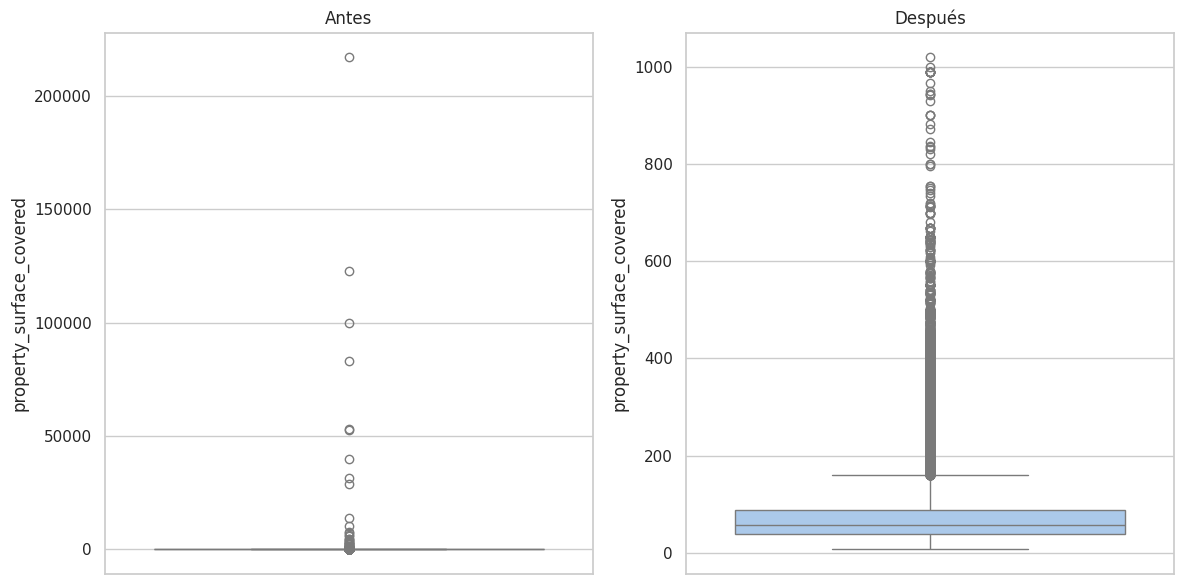

In [1001]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_covered')

In [1002]:
ds_train[(ds_train['property_surface_covered'] > 2000)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

Por ahora respetaremos éste valor atipico por ser un dato coherente. Se analizará más tarde.

#### *Análisis según superficie total (property_surface_total)*



<Axes: ylabel='property_surface_total'>

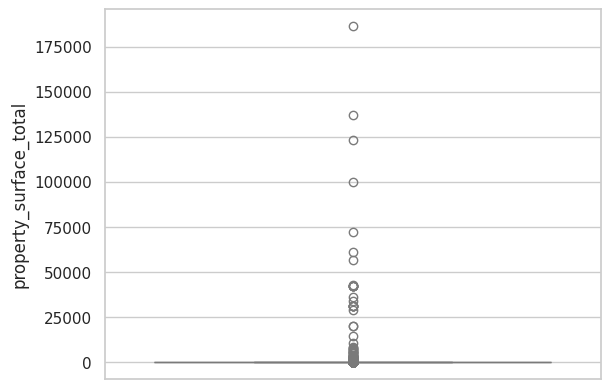

In [1003]:
sns.boxplot(y=ds_train.property_surface_total)

In [1004]:
limite_rango_iq(ds_train, 'property_surface_total')

(-46.5, 136.5)

In [1005]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_total'] < 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1006]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_total'].idxmin()
ds_train.loc[min_surface_index]

id                          4jwFTdGy7N11fF14hLplcw==
start_date                                2021-05-17
end_date                                  2021-06-05
created_on                       2021-05-17 00:00:00
latitud                                   -34.571979
longitud                                  -58.446945
place_l3                                    Belgrano
property_type                           Departamento
property_rooms                                   3.0
property_bedrooms                                2.0
property_surface_total                          10.0
property_surface_covered                        65.0
property_price                              172216.0
Name: 32068, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [1007]:
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
32068   4jwFTdGy7N11fF14hLplcw==  2021-05-17  2021-06-05 2021-05-17   
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
168118  gsbwHqWC2NW1ywgCJd0xaQ==  2021-04-30  2021-06-03 2021-04-30   
334734  YHwlmP7ig5lyXrqU3Othlw==  2021-12-28  2022-01-27 2021-12-28   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
180380  i16eZUm9vHNMrQMT82+9hQ==  2021-02-16  2021-12-09 2021-02-16   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
21153   us/N38vEYZarzdFzep5a9A==  2021-03-15  2021-03-25 2021-03-15   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
154950  /4B1aoAn2OzWObpjXevrmg==  2021-02-03  2022-09-01 2021-02-03   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   

          latitud   longitud       place_l3 property_type  property_rooms  \
32068  -34.571979 -58.446945       Belgrano  Departamento             3.0   
76920  -34.625870 -58.384003   Constitución  Departamento             1.0   
178234 -34.609567 -58.384745      Monserrat  Departamento             1.0   
168118 -34.606525 -58.430740      Caballito  Departamento             3.0   
334734 -34.563734 -58.483824  Villa Urquiza  Departamento             2.0   
38433  -34.600832 -58.390383     Tribunales  Departamento             1.0   
72233  -34.597934 -58.376981         Retiro  Departamento             1.0   
168108 -34.606525 -58.430740      Caballito  Departamento             3.0   
225485 -34.597825 -58.376983         Retiro  Departamento             1.0   
180380 -34.634265 -58.505317     Villa Luro  Departamento             3.0   
299    -34.597934 -58.376981         Retiro  Departamento             1.0   
21153  -34.633819 -58.504568     Villa Luro  Departamento             3.0   
216786 -34.621967 -58.372598      San Telmo  Departamento             1.0   
154950 -34.637580 -58.500624     Villa Luro  Departamento             1.0   
333830 -34.600456 -58.376960         Retiro  Departamento             1.0   
168082 -34.606525 -58.430740      Caballito  Departamento             3.0   
168064 -34.606525 -58.430740      Caballito  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
32068                 2.0                    10.0                      65.0   
76920                 1.0                    14.0                      14.0   
178234                1.0                    13.0                      13.0   
168118                2.0                    12.0                      20.0   
334734                1.0                    10.0                      60.0   
38433                 1.0                    10.0                      10.0   
72233                 1.0                    14.0                      14.0   
168108                2.0                    12.0                      12.0   
225485                1.0                    13.0                      13.0   
180380                2.0                    10.0                      24.0   
299                   1.0                    14.0                      14.0   
21153                 2.0                    10.0                      24.0   
216786                1.0                    14.0                      14.0   
154950                1.0                    12.0                      24.0   
333830                1.0                    14.0                      14.0   
168082                2.0                    12.0                      12.0   
168064               

Por las razones ya expuestas y teniendo en cuenta que son todos departamentos, decidimos reemplazar los datos de superficie total por los de superficie cubierta.

In [1008]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_total'] = ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_covered']

In [1009]:
# Revisamos y solo quedan aquellos casos donde la superficie cubierta también era menor a 15.
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
178234  3PIuolUQmDVlxT4sWCPe0w==  2021-03-23  2021-06-02 2021-03-23   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   

          latitud   longitud      place_l3 property_type  property_rooms  \
76920  -34.625870 -58.384003  Constitución  Departamento             1.0   
178234 -34.609567 -58.384745     Monserrat  Departamento             1.0   
38433  -34.600832 -58.390383    Tribunales  Departamento             1.0   
72233  -34.597934 -58.376981        Retiro  Departamento             1.0   
168108 -34.606525 -58.430740     Caballito  Departamento             3.0   
225485 -34.597825 -58.376983        Retiro  Departamento             1.0   
299    -34.597934 -58.376981        Retiro  Departamento             1.0   
216786 -34.621967 -58.372598     San Telmo  Departamento             1.0   
333830 -34.600456 -58.376960        Retiro  Departamento             1.0   
168082 -34.606525 -58.430740     Caballito  Departamento             3.0   
168064 -34.606525 -58.430740     Caballito  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
76920                 1.0                    14.0                      14.0   
178234                1.0                    13.0                      13.0   
38433                 1.0                    10.0                      10.0   
72233                 1.0                    14.0                      14.0   
168108                2.0                    12.0                      12.0   
225485                1.0                    13.0                      13.0   
299                   1.0                    14.0                      14.0   
216786                1.0                    14.0                      14.0   
333830                1.0                    14.0                      14.0   
168082                2.0                    12.0                      12.0   
168064                2.0                    12.0                      12.0   

        property_price  
76920          24500.0  
178234         55000.0  
38433          35000.0  
72233          45200.0  
168108         23000.0  
225485         38900.0  
299            45200.0  
216786         38000.0  
333830         37300.0  
168082         22000.0  
168064         20000.0

In [1010]:
ds_train[ds_train['property_surface_total'] > 100000]

id  start_date    end_date created_on  \
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
129214  tJ7TjXeyIl+4KPkaPqyAYA==  2021-07-01  9999-12-31 2021-07-01   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   

          latitud   longitud          place_l3 property_type  property_rooms  \
1932   -34.637026 -58.426283  Parque Chacabuco          Casa        2.995732   
129214 -34.599421 -58.386867      Barrio Norte  Departamento        5.000000   
372779 -34.555278 -58.459786          Belgrano  Departamento        4.000000   
405324 -34.569963 -58.481658     Villa Urquiza            PH        4.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
1932              2.70805                186292.0                   217.000   
129214            3.00000                137000.0                   135.000   
372779            3.00000                100068.0                   100.051   
405324            3.00000                123000.0                   123.000   

        property_price  
1932          250000.0  
129214        390000.0  
372779        420000.0  
405324        165000.0

En el caso de la propiedad de Parque Chacabuco, ninguno de los datos tiene coherencia al mirarlos en conjunto: una casa de 22.75 ambientes, y 17.23 habitaciones, con una superficie cubierta de 217.0 y total de 177198m^2. Tendriamos que imputar todos estos datos lo cual no tendría sentido, nos quedariamos con poco material real.

En los otros dos casos, parece ser más un error de escala asi que lo normalizamos.

In [1011]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_surface_total'] > 170000].index
ds_train.drop(id_outlier,inplace=True)

In [1012]:
# Modificamos los otros
condition = ds_train['property_surface_total'] > 100000
ds_train.loc[condition, 'property_surface_total'] /= 1000

ds_train[ds_train['property_surface_total'] > 100000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1013]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
353009  f7xAHgUi1ruXPA9JxKGK6g==  2021-06-25  2021-08-10 2021-06-25   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
362741  G7sKDYpvhrBrps0xzAQrmQ==  2021-01-16  2021-04-14 2021-01-16   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
237392  wGXDCrWhpDX+JQBrC+7jpA==  2021-02-27  2021-03-03 2021-02-27   
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   
126869  MYZD6oNPlLhMzVLoEbL9jw==  2021-10-05  2021-11-04 2021-10-05   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
304492  Psg4w1RO9GxZAski6P2B8g==  2021-04-15  2021-06-05 2021-04-15   
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   
370920  HVcSoFtn8OjGl2rbv0GsBw==  2021-04-24  2021-06-05 2021-04-24   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   

          latitud   longitud       place_l3 property_type  property_rooms  \
353009 -34.579163 -58.455725     Colegiales  Departamento             1.0   
370932 -34.571747 -58.422612        Palermo  Departamento             4.0   
362741 -34.579163 -58.455725     Colegiales  Departamento             1.0   
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
72521  -34.600113 -58.403649      Balvanera  Departamento             2.0   
300394 -34.579163 -58.455725     Colegiales  Departamento             1.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
352883 -34.550093 -58.483034       Saavedra  Departamento             1.0   
237392 -34.628721 -58.421383          Boedo            PH             4.0   
275253 -34.579163 -58.455725     Colegiales  Departamento             1.0   
370922 -34.571747 -58.422612        Palermo  Departamento             5.0   
370921 -34.571747 -58.422612        Palermo  Departamento             5.0   
84073  -34.588175 -58.396261       Recoleta  Departamento             1.0   
370919 -34.571747 -58.422612        Palermo  Departamento             5.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   
126869 -34.579163 -58.455725     Colegiales  Departamento             1.0   
1140   -34.605781 -58.376705    San Nicolás  Departamento             4.0   
304492 -34.579163 -58.455725     Colegiales  Departamento             1.0   
459841 -34.627876 -58.437996      Caballito  Departamento             3.0   
324541 -34.628721 -58.421383          Boedo            PH             4.0   
72316  -34.578917 -58.429373        Palermo  Departamento             2.0   
106598 -34.587320 -58.401556   Barrio Norte  Departamento             2.0   
219021 -34.636532 -58.376406       Barracas  Departamento             4.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   
117835 -34.550093 -58.483034       Saavedra  Departamento             2.0   
370920 -34.571747 -58.422612        Pal

Se ve una tendencia entre la superficie total y la superficie cubierta que indicaría un error de escala. Vamos a corregirlo.

In [1014]:
# Buscamos las filas donde property_surface_total / 100 == property_surface_covered y hacemos una máscara.
mask = ds_train['property_surface_total'] / 100 == ds_train['property_surface_covered']

# Reemplazamos property_surface_total con property_surface_covered en esos casos
ds_train.loc[mask, 'property_surface_total'] = ds_train.loc[mask, 'property_surface_covered']

In [1015]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
353009  f7xAHgUi1ruXPA9JxKGK6g==  2021-06-25  2021-08-10 2021-06-25   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
362741  G7sKDYpvhrBrps0xzAQrmQ==  2021-01-16  2021-04-14 2021-01-16   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
237392  wGXDCrWhpDX+JQBrC+7jpA==  2021-02-27  2021-03-03 2021-02-27   
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   
126869  MYZD6oNPlLhMzVLoEbL9jw==  2021-10-05  2021-11-04 2021-10-05   
304492  Psg4w1RO9GxZAski6P2B8g==  2021-04-15  2021-06-05 2021-04-15   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
117835  vyRPw0ch6cIj9Ki5yPUneA==  2021-08-18  2021-08-23 2021-08-18   
370920  HVcSoFtn8OjGl2rbv0GsBw==  2021-04-24  2021-06-05 2021-04-24   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   

          latitud   longitud       place_l3 property_type  property_rooms  \
353009 -34.579163 -58.455725     Colegiales  Departamento             1.0   
370932 -34.571747 -58.422612        Palermo  Departamento             4.0   
362741 -34.579163 -58.455725     Colegiales  Departamento             1.0   
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
72521  -34.600113 -58.403649      Balvanera  Departamento             2.0   
300394 -34.579163 -58.455725     Colegiales  Departamento             1.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
352883 -34.550093 -58.483034       Saavedra  Departamento             1.0   
237392 -34.628721 -58.421383          Boedo            PH             4.0   
275253 -34.579163 -58.455725     Colegiales  Departamento             1.0   
370922 -34.571747 -58.422612        Palermo  Departamento             5.0   
370921 -34.571747 -58.422612        Palermo  Departamento             5.0   
84073  -34.588175 -58.396261       Recoleta  Departamento             1.0   
370919 -34.571747 -58.422612        Palermo  Departamento             5.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   
126869 -34.579163 -58.455725     Colegiales  Departamento             1.0   
304492 -34.579163 -58.455725     Colegiales  Departamento             1.0   
324541 -34.628721 -58.421383          Boedo            PH             4.0   
72316  -34.578917 -58.429373        Palermo  Departamento             2.0   
106598 -34.587320 -58.401556   Barrio Norte  Departamento             2.0   
219021 -34.636532 -58.376406       Barracas  Departamento             4.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   
117835 -34.550093 -58.483034       Saavedra  Departamento             2.0   
370920 -34.571747 -58.422612        Palermo  Departamento             5.0   
370917 -34.571747 -58.422612        Palermo  Departamento             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
353009                1.0                 31000.0                    26.000   
370932                

Algunos registros específicos parecen ser errores de tipeo/escala. Los corregimos manualmente y el resto serán corregidos logaritmicamente.

In [1016]:
# Corección de error de tipeo/escala
condition = (ds_train['property_surface_total'] == 31000) & (ds_train['property_surface_covered'] == 26)
condition2 = (ds_train['property_surface_total'] == 42110.0) & (ds_train['property_surface_covered'] == 307)
ds_train.loc[condition, 'property_surface_total'] /= 1000
ds_train.loc[condition2, 'property_surface_total'] /= 100


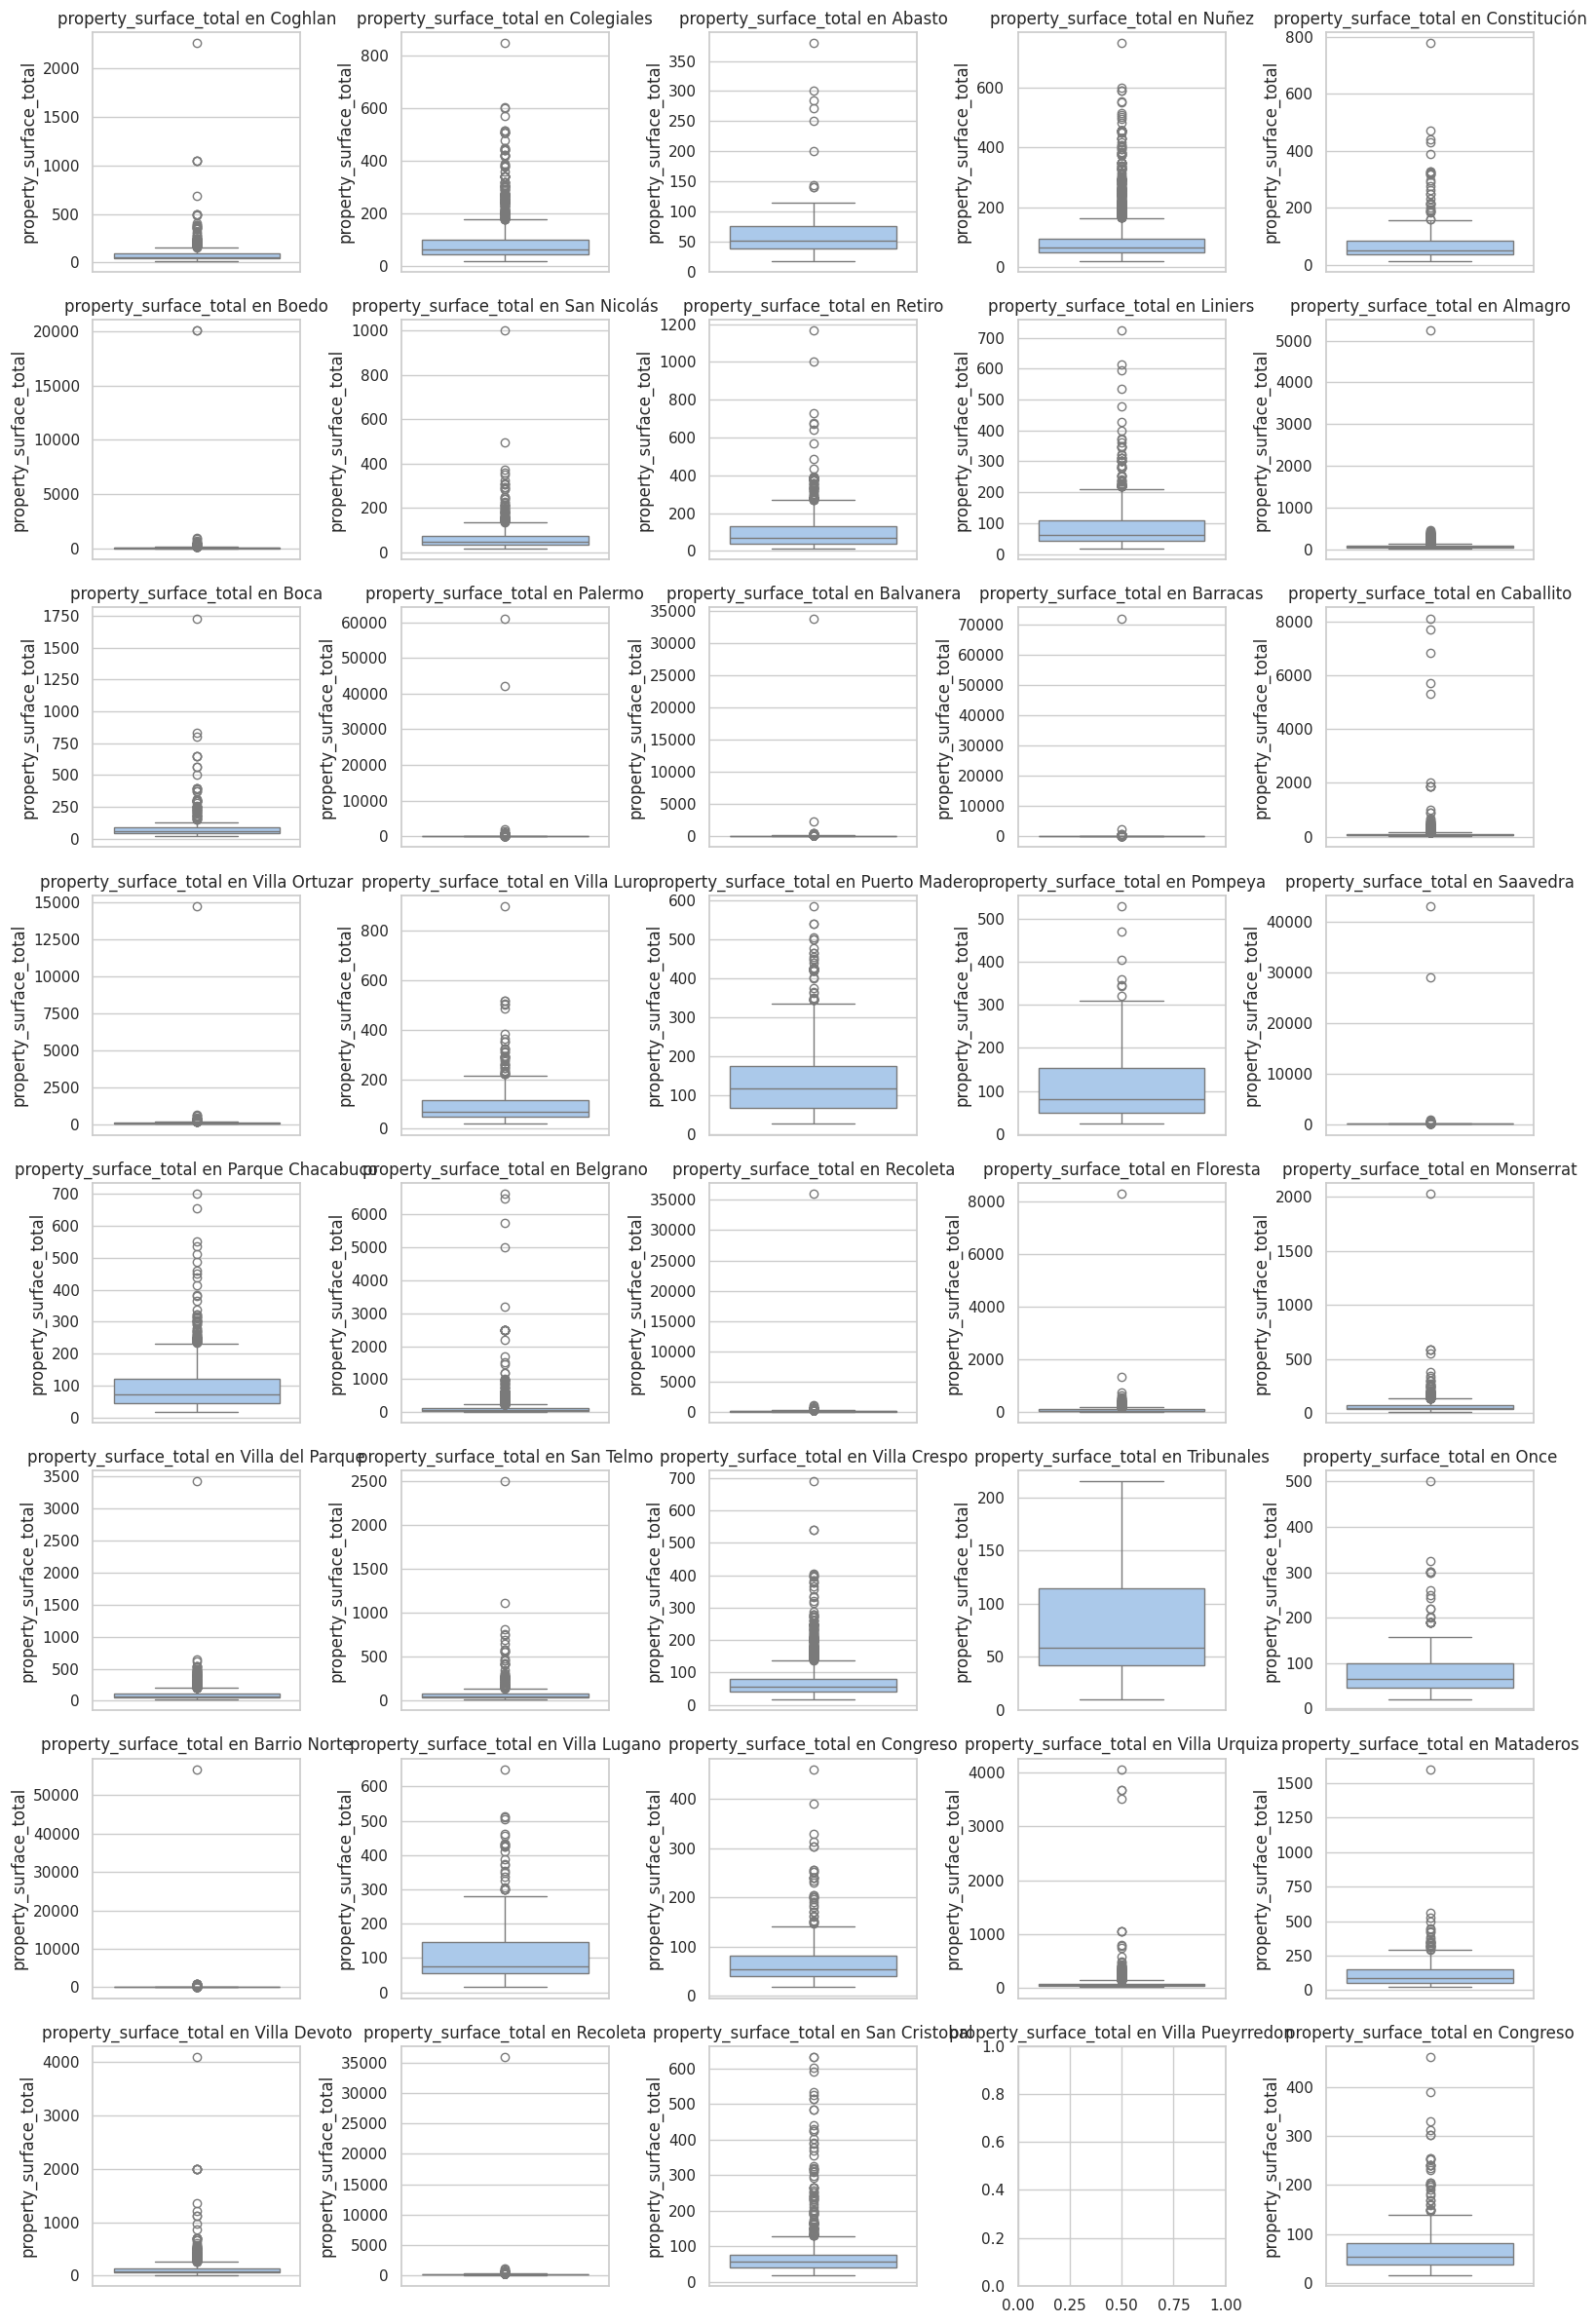

In [1017]:
plot_por_barrio(ds_train, 'property_surface_total')

Podemos ver en las comparaciones de los barrios que incluso en aquellos que tienen más variaciones de tamaño de superficie total, los valores por encima de 3000 son outliers extremos, asi que normalizaremos esos valores.

In [1018]:
# Corrección logaritmica
ds_train.loc[(ds_train['property_surface_total'] > 3000.0), 'property_surface_total'] = np.log(ds_train['property_surface_total'])

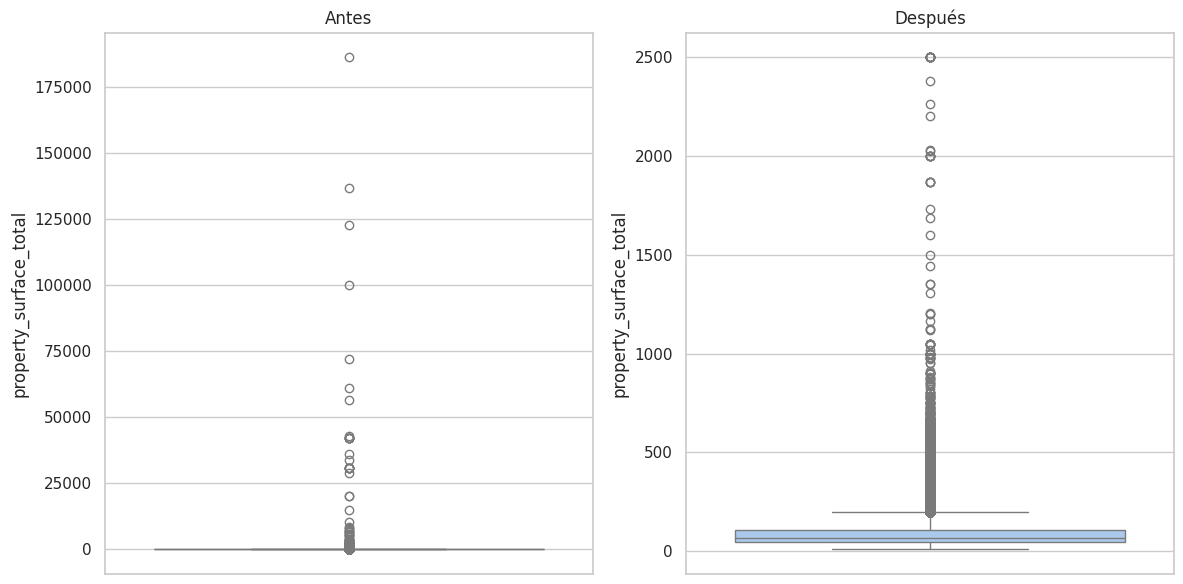

In [1019]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_total')

#### **Z-Score, normal y modificado**

In [1020]:
def plot_z(df, variable):
  plt.hist(df[variable])
  plt.title("Histograma Z-Score "+ variable)
  plt.xlabel("Z-Score "+variable)
  plt.tight_layout()
  plt.show()
  return

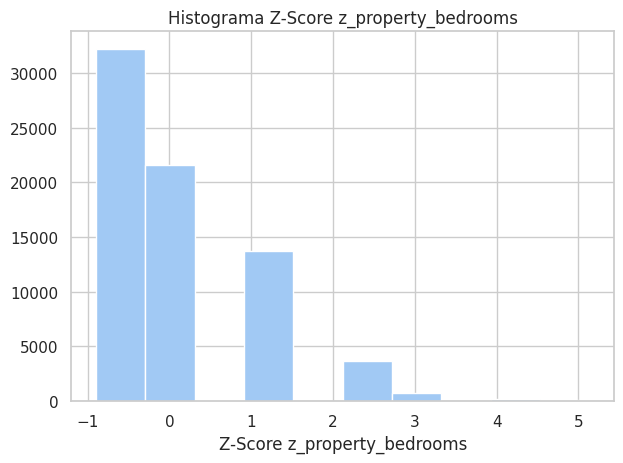

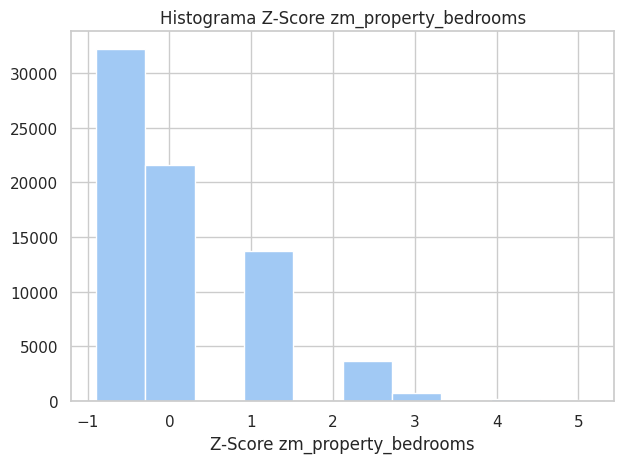

In [1021]:
# Z Score property_bedrooms
ds_train['z_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)
ds_train['zm_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)

plot_z(ds_train, 'z_property_bedrooms')
plot_z(ds_train, 'zm_property_bedrooms')


In [1022]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
193005  bhR0MdTQHbRO96eofs0jDQ==  2021-01-08  2021-06-18 2021-01-08   
211700  pSVy4z8XQCQ4UnajNwUhkA==  2021-03-22  2021-06-05 2021-03-22   
211187  La6PGp2B4KuUFjE5dcHxeA==  2021-11-16  2021-12-15 2021-11-16   
146361  xrT9pdhOLwZN0Q1J9N/UPg==  2021-08-19  2022-07-02 2021-08-19   
245430  sw6Y2UwVsN+YOQz1D2MtCw==  2021-10-08  2022-02-09 2021-10-08   
...                          ...         ...         ...        ...   
435004  LRiqymZEtyvNeISdcMo+Ag==  2021-08-25  2021-08-27 2021-08-25   
282733  wkzFNIRXgczk5RddtufCBA==  2021-09-16  2021-12-04 2021-09-16   
320181  QnQoowjHCfuOI7IlJqBnCw==  2021-09-03  2021-09-30 2021-09-03   
357524  uM0Sxr7RTX7EcKB4eGiVlg==  2021-06-29  2021-07-02 2021-06-29   
439713  WjSPOpNqWFCGBOdoVcvPQQ==  2021-07-20  2022-02-17 2021-07-20   

          latitud   longitud    place_l3 property_type  property_rooms  \
193005 -34.583042 -58.400016     Palermo  Departamento             9.0   
211700 -34.619453 -58.442084   Caballito            PH             9.0   
211187 -34.609945 -58.400360   Balvanera  Departamento             7.0   
146361 -34.621572 -58.521443  Villa Real            PH             6.0   
245430 -34.553050 -58.448411    Belgrano          Casa             8.0   
...           ...        ...         ...           ...             ...   
435004 -34.629113 -58.364345        Boca          Casa             7.0   
282733 -34.590335 -58.390134    Recoleta  Departamento             9.0   
320181 -34.625539 -58.464772      Flores            PH             7.0   
357524 -34.629218 -58.493361    Floresta          Casa             7.0   
439713 -34.616682 -58.370246   San Telmo            PH             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
193005                6.0                   323.0                     297.0   
211700                6.0                   360.0                     356.0   
211187                6.0                   318.0                     234.0   
146361                6.0                   151.0                     108.0   
245430                7.0                   415.0                     415.0   
...                   ...                     ...                       ...   
435004                6.0                   500.0                     400.0   
282733                6.0                   420.0                     411.0   
320181                6.0                   355.0                     255.0   
357524                6.0                   379.0                     222.0   
439713                6.0                   247.0                     177.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
193005       1150000.0             4.128550              4.128550  
211700        486000.0             4.128550              4.128550  
211187        305000.0             4.128550              4.128550  
146361        315000.0             4.128550              4.128550  
245430        820000.0             5.133635              5.133635  
...                ...                  ...                   ...  
435004        222000.0             4.128550              4.128550  
282733       1350000.0             4.128550              4.128550  
320181        165000.0             4.128550              4.128550  
357524        299000.0             4.128550              4.128550  
439713        320000.0             4.128550              4.128550  

[291 rows x 15 columns]

In [1023]:
ds_train[(ds_train['zm_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
193005  bhR0MdTQHbRO96eofs0jDQ==  2021-01-08  2021-06-18 2021-01-08   
211700  pSVy4z8XQCQ4UnajNwUhkA==  2021-03-22  2021-06-05 2021-03-22   
211187  La6PGp2B4KuUFjE5dcHxeA==  2021-11-16  2021-12-15 2021-11-16   
146361  xrT9pdhOLwZN0Q1J9N/UPg==  2021-08-19  2022-07-02 2021-08-19   
245430  sw6Y2UwVsN+YOQz1D2MtCw==  2021-10-08  2022-02-09 2021-10-08   
...                          ...         ...         ...        ...   
435004  LRiqymZEtyvNeISdcMo+Ag==  2021-08-25  2021-08-27 2021-08-25   
282733  wkzFNIRXgczk5RddtufCBA==  2021-09-16  2021-12-04 2021-09-16   
320181  QnQoowjHCfuOI7IlJqBnCw==  2021-09-03  2021-09-30 2021-09-03   
357524  uM0Sxr7RTX7EcKB4eGiVlg==  2021-06-29  2021-07-02 2021-06-29   
439713  WjSPOpNqWFCGBOdoVcvPQQ==  2021-07-20  2022-02-17 2021-07-20   

          latitud   longitud    place_l3 property_type  property_rooms  \
193005 -34.583042 -58.400016     Palermo  Departamento             9.0   
211700 -34.619453 -58.442084   Caballito            PH             9.0   
211187 -34.609945 -58.400360   Balvanera  Departamento             7.0   
146361 -34.621572 -58.521443  Villa Real            PH             6.0   
245430 -34.553050 -58.448411    Belgrano          Casa             8.0   
...           ...        ...         ...           ...             ...   
435004 -34.629113 -58.364345        Boca          Casa             7.0   
282733 -34.590335 -58.390134    Recoleta  Departamento             9.0   
320181 -34.625539 -58.464772      Flores            PH             7.0   
357524 -34.629218 -58.493361    Floresta          Casa             7.0   
439713 -34.616682 -58.370246   San Telmo            PH             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
193005                6.0                   323.0                     297.0   
211700                6.0                   360.0                     356.0   
211187                6.0                   318.0                     234.0   
146361                6.0                   151.0                     108.0   
245430                7.0                   415.0                     415.0   
...                   ...                     ...                       ...   
435004                6.0                   500.0                     400.0   
282733                6.0                   420.0                     411.0   
320181                6.0                   355.0                     255.0   
357524                6.0                   379.0                     222.0   
439713                6.0                   247.0                     177.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
193005       1150000.0             4.128550              4.128550  
211700        486000.0             4.128550              4.128550  
211187        305000.0             4.128550              4.128550  
146361        315000.0             4.128550              4.128550  
245430        820000.0             5.133635              5.133635  
...                ...                  ...                   ...  
435004        222000.0             4.128550              4.128550  
282733       1350000.0             4.128550              4.128550  
320181        165000.0             4.128550              4.128550  
357524        299000.0             4.128550              4.128550  
439713        320000.0             4.128550              4.128550  

[291 rows x 15 columns]

In [1024]:
ds_train[(ds_train['z_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

In [1025]:
ds_train[(ds_train['zm_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

Siguiendo el Z score, podemos ver que no existen outliers negativos, incluso usando un valor mínimo de -1. Usando la regla de oro de 3.5, podemos ver que si lo existen positivos y en una cantidad bastante significativa (270 registros). Vamos a ampliar ligeramente este factor.

In [1026]:
ds_train[(ds_train['z_property_bedrooms'] > 5)]

id  start_date    end_date created_on  \
245430  sw6Y2UwVsN+YOQz1D2MtCw==  2021-10-08  2022-02-09 2021-10-08   
400512  PzPchvZOPeXUFJaNFncqYg==  2021-06-17  2021-06-19 2021-06-17   
301648  mtpUHpAUZ4hE/PR4Bevnxw==  2021-08-10  2021-09-15 2021-08-10   
280738  myhAqyWgEy4mVpk5Jiwfyw==  2021-12-29  2022-02-09 2021-12-29   
342818  mqoxNDn8Gn/UkxbHPo7iOA==  2021-08-11  2021-09-01 2021-08-11   
...                          ...         ...         ...        ...   
86196   Dk7qNb11sh6gSEmk5qB4Bw==  2021-03-26  2021-06-05 2021-03-26   
398724  t0mG+MlvoUEuQxyELQvmgg==  2021-02-13  2021-07-26 2021-02-13   
342982  9k8Av+CJZI20KktSfTRtqg==  2021-08-11  2022-02-09 2021-08-11   
126403  ETzg09MPRQDliI9p8PzeBg==  2021-10-05  2022-02-22 2021-10-05   
198127  la5vVFPvjtlJv3F690Sn6A==  2021-02-14  2021-03-01 2021-02-14   

          latitud   longitud          place_l3 property_type  property_rooms  \
245430 -34.553050 -58.448411          Belgrano          Casa             8.0   
400512 -34.635382 -58.355539              Boca            PH             8.0   
301648 -34.593316 -58.377201            Retiro  Departamento             9.0   
280738 -34.629030 -58.456957            Flores          Casa             8.0   
342818 -34.616128 -58.394715         Balvanera          Casa             8.0   
...           ...        ...               ...           ...             ...   
86196  -34.617091 -58.373067         San Telmo            PH            10.0   
398724 -34.604668 -58.396573         Balvanera  Departamento             8.0   
342982 -34.644841 -58.407189  Parque Patricios          Casa             8.0   
126403 -34.564988 -58.444710          Belgrano  Departamento             5.0   
198127 -34.625901 -58.465396            Flores            PH            10.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
245430                7.0                   415.0                     415.0   
400512                7.0                   395.0                     319.0   
301648                7.0                   380.0                     350.0   
280738                7.0                   637.0                     637.0   
342818                7.0                   164.0                     143.0   
...                   ...                     ...                       ...   
86196                 7.0                   353.0                     250.0   
398724                7.0                   247.0                     232.0   
342982                7.0                   337.0                     200.0   
126403                7.0                   282.0                     282.0   
198127                7.0                   386.0                     231.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
245430        820000.0             5.133635              5.133635  
400512        145000.0             5.133635              5.133635  
301648        650000.0             5.133635              5.133635  
280738       1100000.0             5.133635              5.133635  
342818        230000.0             5.133635              5.133635  
...                ...                  ...                   ...  
86196         460000.0             5.133635              5.133635  
398724        360000.0             5.133635              5.133635  
342982        230000.0             5.133635              5.133635  
126403       1300000.0             5.133635              5.133635  
198127        280000.0             5.133635              5.133635  

[92 rows x 15 columns]

No podemos sacar ninguna conclusión de los registros, más allá de que solo tomando en cuenta esta variable son registros atípicos. Esperaremos al análisis multivariado para tomar decisiones al respecto de estos outliers.

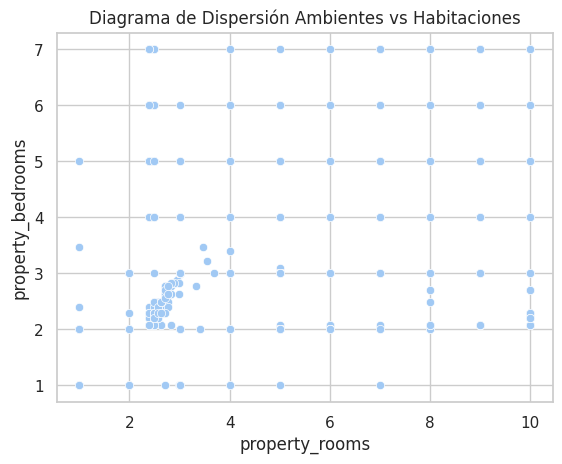

In [1027]:
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones")
plt.show()

En el analisis univariado solucionamos los outliers imposibles.  

In [1028]:
# Caso: más habitaciones que ambientes
condition= (ds_train['property_rooms'] < ds_train['property_bedrooms'])
ds_train[condition]

id  start_date    end_date created_on  \
115490  4SB68b9pUEe+GxRTEbEbDw==  2021-12-07  2022-01-27 2021-12-07   
115485  hrKv65SUn9Qf8dlGuPYhHw==  2021-12-07  2022-01-27 2021-12-07   
209620  ZexfxMwGXxTsKKO7oy1O8w==  2021-05-09  2021-10-13 2021-05-09   
115167  Z9zRCLIVKH/KIgKLvMsstw==  2021-12-07  2022-01-27 2021-12-07   
170460  hDvT3AtasnPkHjzJKm4NSA==  2021-07-28  2021-08-26 2021-07-28   
...                          ...         ...         ...        ...   
115478  iCWwiz2RVAkocqGsdwEv3Q==  2021-12-07  2022-01-27 2021-12-07   
54021   hGQM/Ul+C0II9otOEBQnsA==  2021-09-22  2022-02-09 2021-09-22   
443898  oj7pM0UnMdxUrnbcWlN6DQ==  2021-11-09  2022-01-27 2021-11-09   
126403  ETzg09MPRQDliI9p8PzeBg==  2021-10-05  2022-02-22 2021-10-05   
9661    TCEygKmMJpgJFlJwCiCxtA==  2021-05-18  2021-06-05 2021-05-18   

          latitud   longitud       place_l3 property_type  property_rooms  \
115490 -34.613037 -58.360984  Puerto Madero  Departamento        3.000000   
115485 -34.613261 -58.361513  Puerto Madero  Departamento        3.000000   
209620 -34.622016 -58.420410          Boedo          Casa        2.397895   
115167 -34.620586 -58.439740      Caballito            PH        2.000000   
170460 -34.621530 -58.361752  Puerto Madero  Departamento        3.000000   
...           ...        ...            ...           ...             ...   
115478 -34.613261 -58.361513  Puerto Madero  Departamento        3.000000   
54021  -34.605454 -58.506832   Villa Devoto  Departamento        4.000000   
443898 -34.562809 -58.476758       Congreso  Departamento        1.000000   
126403 -34.564988 -58.444710       Belgrano  Departamento        5.000000   
9661   -34.563353 -58.444035       Belgrano  Departamento        2.484907   

        property_bedrooms  property_surface_total  property_surface_covered  \
115490                4.0                   170.0                     166.0   
115485                4.0                   170.0                     166.0   
209620                5.0                   880.0                     600.0   
115167                3.0                   140.0                     140.0   
170460                4.0                   122.0                     116.0   
...                   ...                     ...                       ...   
115478                4.0                   170.0                     166.0   
54021                 5.0                   172.0                     149.0   
443898                2.0                    21.0                      21.0   
126403                7.0                   282.0                     282.0   
9661                  5.0                   435.0                     435.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
115490       1050000.0             2.118379              2.118379  
115485       1250000.0             2.118379              2.118379  
209620       1200000.0             3.123465              3.123465  
115167        240000.0             1.113294              1.113294  
170460        590000.0             2.118379              2.118379  
...                ...                  ...                   ...  
115478       1250000.0             2.118379              2.118379  
54021         320000.0             3.123465              3.123465  
443898         49000.0             0.108209              0.108209  
126403       1300000.0             5.133635              5.133635  
9661          850000.0             3.123465              3.123465  

[116 rows x 15 columns]

Tenemos 118 registros en los que el número de habitaciones es mayor que el de ambientes.

Varios de estos registros tienen valores irracionales para una habitación (2.397... en vez de números enteros) y podrían haber sido resultados de imputaciones y transformaciones anteriores.
Una solución podría ser copiar los valores de habitaciones a ambientes, pero previniendo que algunos puedan ser valores verdaderos y para que no se pierdan, probaremos invirtiendo las columnas de estos casos en específico ya que muchos tienen sentido de esa manera (casas con 6 ambientes y 4 habitaciones, departamentos de 2 ambientes y una habitación, por dar unos ejemplos). Es un cambio riesgoso pero se tendrá en cuenta por si llegara a haber discrepancias en resultados futuros.

In [1029]:
# Creamos una máscara booleana para nuestra condición
mask = ds_train['property_rooms'] < ds_train['property_bedrooms']

# Invertimos los valores usando la máscara
ds_train.loc[mask, ['property_rooms', 'property_bedrooms']] = ds_train.loc[mask, ['property_bedrooms', 'property_rooms']].values


In [1030]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
193005  bhR0MdTQHbRO96eofs0jDQ==  2021-01-08  2021-06-18 2021-01-08   
211700  pSVy4z8XQCQ4UnajNwUhkA==  2021-03-22  2021-06-05 2021-03-22   
211187  La6PGp2B4KuUFjE5dcHxeA==  2021-11-16  2021-12-15 2021-11-16   
146361  xrT9pdhOLwZN0Q1J9N/UPg==  2021-08-19  2022-07-02 2021-08-19   
245430  sw6Y2UwVsN+YOQz1D2MtCw==  2021-10-08  2022-02-09 2021-10-08   
...                          ...         ...         ...        ...   
435004  LRiqymZEtyvNeISdcMo+Ag==  2021-08-25  2021-08-27 2021-08-25   
282733  wkzFNIRXgczk5RddtufCBA==  2021-09-16  2021-12-04 2021-09-16   
320181  QnQoowjHCfuOI7IlJqBnCw==  2021-09-03  2021-09-30 2021-09-03   
357524  uM0Sxr7RTX7EcKB4eGiVlg==  2021-06-29  2021-07-02 2021-06-29   
439713  WjSPOpNqWFCGBOdoVcvPQQ==  2021-07-20  2022-02-17 2021-07-20   

          latitud   longitud    place_l3 property_type  property_rooms  \
193005 -34.583042 -58.400016     Palermo  Departamento             9.0   
211700 -34.619453 -58.442084   Caballito            PH             9.0   
211187 -34.609945 -58.400360   Balvanera  Departamento             7.0   
146361 -34.621572 -58.521443  Villa Real            PH             6.0   
245430 -34.553050 -58.448411    Belgrano          Casa             8.0   
...           ...        ...         ...           ...             ...   
435004 -34.629113 -58.364345        Boca          Casa             7.0   
282733 -34.590335 -58.390134    Recoleta  Departamento             9.0   
320181 -34.625539 -58.464772      Flores            PH             7.0   
357524 -34.629218 -58.493361    Floresta          Casa             7.0   
439713 -34.616682 -58.370246   San Telmo            PH             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
193005                6.0                   323.0                     297.0   
211700                6.0                   360.0                     356.0   
211187                6.0                   318.0                     234.0   
146361                6.0                   151.0                     108.0   
245430                7.0                   415.0                     415.0   
...                   ...                     ...                       ...   
435004                6.0                   500.0                     400.0   
282733                6.0                   420.0                     411.0   
320181                6.0                   355.0                     255.0   
357524                6.0                   379.0                     222.0   
439713                6.0                   247.0                     177.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
193005       1150000.0             4.128550              4.128550  
211700        486000.0             4.128550              4.128550  
211187        305000.0             4.128550              4.128550  
146361        315000.0             4.128550              4.128550  
245430        820000.0             5.133635              5.133635  
...                ...                  ...                   ...  
435004        222000.0             4.128550              4.128550  
282733       1350000.0             4.128550              4.128550  
320181        165000.0             4.128550              4.128550  
357524        299000.0             4.128550              4.128550  
439713        320000.0             4.128550              4.128550  

[291 rows x 15 columns]

270 registros permanecen como outliers.

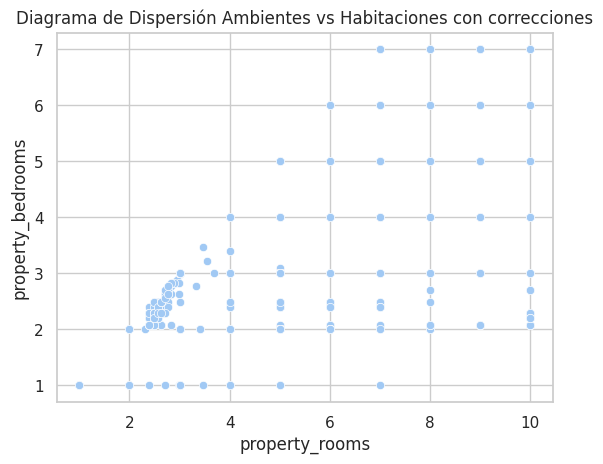

In [1031]:
# Visualización después de correcciones
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones con correcciones")
plt.show()


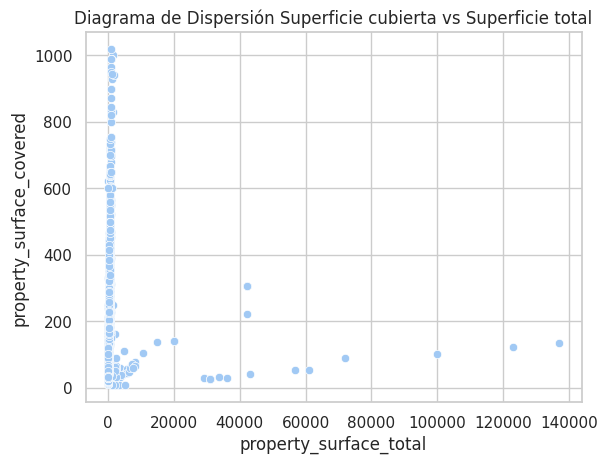

In [1032]:
sns.scatterplot(y=ds_train["property_surface_covered"], x=df["property_surface_total"])
plt.title("Diagrama de Dispersión Superficie cubierta vs Superficie total")
plt.show()

En primer lugar, vamos a distinguir los casos triviales donde la superficie cubierta es mayor a la superficie total.

In [1033]:
# Casos donde la superficie cubierta es mayor a la total
ds_train[(ds_train['property_surface_total'] < ds_train['property_surface_covered'])]

id  start_date    end_date created_on  \
182205  v5NfrN+68lhwxAlp5mjlFw==  2021-08-06  2022-05-08 2021-08-06   
174864  dzeFyIOqpO0z/2NVd8m0NA==  2021-08-31  2022-01-19 2021-08-31   
35772   YlLn73RCQP4pM51jaWJtNg==  2021-02-08  2021-03-01 2021-02-08   
394120  XVi/gSKt++m52oq0TF8+Og==  2021-02-13  2021-03-01 2021-02-13   
107214  VxPrUTqFKvB6wzkPwREpSQ==  2021-03-11  2021-06-05 2021-03-11   
...                          ...         ...         ...        ...   
324326  3whyopfUB1ra2OEzglOjMQ==  2021-03-03  2021-06-05 2021-03-03   
155783  RBcMbV7LwSbNKxljAV7Y3Q==  2021-04-05  2021-04-15 2021-04-05   
440712  XY4k5kxLYRlzy1KqIwqpxg==  2021-07-20  9999-12-31 2021-07-20   
347242  ZruR5IT6eaDpsOM/lfBmyw==  2021-09-30  2021-12-15 2021-09-30   
59162   22kF8r6mw/+yPLjxlpumeg==  2021-03-13  2021-05-29 2021-03-13   

          latitud   longitud          place_l3 property_type  property_rooms  \
182205 -34.627059 -58.445419         Caballito  Departamento             3.0   
174864 -34.627287 -58.432343         Caballito            PH             3.0   
35772  -34.639048 -58.431920  Parque Chacabuco          Casa             8.0   
394120 -34.635830 -58.471558            Flores          Casa             5.0   
107214 -34.591767 -58.413748           Palermo  Departamento             5.0   
...           ...        ...               ...           ...             ...   
324326 -34.555076 -58.453584          Belgrano  Departamento             3.0   
155783 -34.553903 -58.449629          Belgrano  Departamento             1.0   
440712 -34.587859 -58.420280           Palermo  Departamento             5.0   
347242 -34.650617 -58.385472          Barracas          Casa             6.0   
59162  -34.577358 -58.407118           Palermo  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
182205                2.0                    40.0                      44.0   
174864                2.0                    45.0                      47.0   
35772                 5.0                   240.0                     358.0   
394120                4.0                   104.0                     210.0   
107214                3.0                   105.0                     126.0   
...                   ...                     ...                       ...   
324326                2.0                    45.0                      90.0   
155783                1.0                    37.0                      38.0   
440712                3.0                    89.0                     110.0   
347242                4.0                   202.0                     204.0   
59162                 1.0                    33.0                      38.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
182205         82000.0             0.108209              0.108209  
174864         94000.0             0.108209              0.108209  
35772         420000.0             3.123465              3.123465  
394120        243000.0             2.118379              2.118379  
107214        285000.0             1.113294              1.113294  
...                ...                  ...                   ...  
324326        360000.0             0.108209              0.108209  
155783        110000.0            -0.896877             -0.896877  
440712        250000.0             1.113294              1.113294  
347242        310000.0             2.118379              2.118379  
59162         138000.0            -0.896877             -0.896877  

[347 rows x 15 columns]

Vamos a combinar algunas de las técnicas que ya realizamos anteriormente.

In [1034]:
# Creamos una máscara booleana para nuestra condición
mask = ds_train['property_surface_total'] < ds_train['property_surface_covered']

# Invertimos los valores usando la máscara
ds_train.loc[mask, ['property_surface_total', 'property_surface_covered']] = ds_train.loc[mask, ['property_surface_covered', 'property_surface_covered']].values

Aquí se podría revisar que no haya valores como superficies cubiertas muy pequeñas, pero por ahora se mantendrá así a menos que se determine que sigue habiendo demasiado ruido en nuestro ds.

### Análisis multivariado

#### **Isolation forest**

In [1035]:
# Cargo los datos
X =ds_train.copy()
X.head()

id  start_date    end_date created_on  \
285884  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18 2021-03-06   
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
419659  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09 2021-10-14   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07 2021-10-01   
103677  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
285884 -34.621390 -58.506366      Monte Castro  Departamento             3.0   
120762 -34.563005 -58.453674          Belgrano  Departamento             3.0   
419659 -34.612349 -58.491906  Villa del Parque  Departamento             3.0   
21443  -34.620806 -58.397336             Boedo            PH             3.0   
103677 -34.558229 -58.446708          Belgrano  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
285884                2.0                    51.0                      44.0   
120762                2.0                    79.0                      66.0   
419659                2.0                   110.0                      80.0   
21443                 2.0                    97.0                      67.0   
103677                2.0                    89.0                      89.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
285884        112000.0             0.108209              0.108209  
120762        299900.0             0.108209              0.108209  
419659        249000.0             0.108209              0.108209  
21443         135000.0             0.108209              0.108209  
103677        300000.0             0.108209              0.108209

In [1036]:
# Limpio el dataset
X.drop(columns=['latitud', 'longitud', 'created_on', 'end_date', 'start_date'], inplace=True)
X.head()

id          place_l3 property_type  \
285884  sH/yN2YdtUSSJepTsIXyjQ==      Monte Castro  Departamento   
120762  8vhkDo5KTd+Wwz3QYRR7wg==          Belgrano  Departamento   
419659  hnDEA6QbHN6K/57Hkhlrhg==  Villa del Parque  Departamento   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==             Boedo            PH   
103677  GgQjrtJSz1N4jQ8aSuNudA==          Belgrano  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
285884             3.0                2.0                    51.0   
120762             3.0                2.0                    79.0   
419659             3.0                2.0                   110.0   
21443              3.0                2.0                    97.0   
103677             3.0                2.0                    89.0   

        property_surface_covered  property_price  z_property_bedrooms  \
285884                      44.0        112000.0             0.108209   
120762                      66.0        299900.0             0.108209   
419659                      80.0        249000.0             0.108209   
21443                       67.0        135000.0             0.108209   
103677                      89.0        300000.0             0.108209   

        zm_property_bedrooms  
285884              0.108209  
120762              0.108209  
419659              0.108209  
21443               0.108209  
103677              0.108209

In [1037]:
# Label encoding de los nombres de las ciudades y el tipo de propiedad

label_encoder = LabelEncoder()
X['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
ds_train['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
X['type_encoded'] = label_encoder.fit_transform(X['property_type'])
ds_train['type_encoded'] = label_encoder.fit_transform(X['property_type'])

X

id          place_l3 property_type  \
285884  sH/yN2YdtUSSJepTsIXyjQ==      Monte Castro  Departamento   
120762  8vhkDo5KTd+Wwz3QYRR7wg==          Belgrano  Departamento   
419659  hnDEA6QbHN6K/57Hkhlrhg==  Villa del Parque  Departamento   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==             Boedo            PH   
103677  GgQjrtJSz1N4jQ8aSuNudA==          Belgrano  Departamento   
...                          ...               ...           ...   
404680  Acazbb1LSMA/utzFiPKm9Q==          Belgrano  Departamento   
30514   upUD9tdVDI/Ib/fRFNFDZA==     Villa Urquiza  Departamento   
268902  EJ8p6gJ/c3hA2ktL034+BQ==          Belgrano  Departamento   
379634  Z9std/wufD6bvz2jlpr8pg==          Barracas  Departamento   
75496   JYdp3X64J1/TLuVNwZp5Hg==          Recoleta  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
285884             3.0                2.0                    51.0   
120762             3.0                2.0                    79.0   
419659             3.0                2.0                   110.0   
21443              3.0                2.0                    97.0   
103677             3.0                2.0                    89.0   
...                ...                ...                     ...   
404680             3.0                2.0                    93.0   
30514              3.0                2.0                   100.0   
268902             3.0                2.0                    91.0   
379634             1.0                1.0                    43.0   
75496              2.0                1.0                    34.0   

        property_surface_covered  property_price  z_property_bedrooms  \
285884                      44.0        112000.0             0.108209   
120762                      66.0        299900.0             0.108209   
419659                      80.0        249000.0             0.108209   
21443                       67.0        135000.0             0.108209   
103677                      89.0        300000.0             0.108209   
...                          ...             ...                  ...   
404680                      71.0        240000.0             0.108209   
30514                       75.0        199000.0             0.108209   
268902                      81.0        333000.0             0.108209   
379634                      36.0         99800.0            -0.896877   
75496                       33.0         74900.0            -0.896877   

        zm_property_bedrooms  place_encoded  type_encoded  
285884              0.108209             23             1  
120762              0.108209              6             1  
419659              0.108209             56             1  
21443               0.108209              8             2  
103677              0.108209              6             1  
...                      ...            ...           ...  
404680              0.108209              6             1  
30514               0.108209             55             1  
268902              0.108209              6             1  
379634             -0.896877              4             1  
75496              -0.896877             35             1  

[72224 rows x 12 columns]

In [1038]:
X.drop(columns=['place_l3', 'property_type', 'id'], inplace=True)

In [1039]:
# Creo el modelo
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=5,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

# Entreno y genero la predicción
pred = iforest.fit_predict(X)

# Almaceno scores y etiquetas
X["scores"] = iforest.decision_function(X)
X["outlier_label"] = pred

# Observaciones anómalas
X[X.outlier_label == -1]

property_rooms  property_bedrooms  property_surface_total  \
141134             5.0                5.0                   130.0   
328872             3.0                2.0                   530.0   
269052            10.0                4.0                   605.0   
35772              8.0                5.0                   358.0   
167656             7.0                5.0                   350.0   
...                ...                ...                     ...   
357524             7.0                6.0                   379.0   
439713             8.0                6.0                   247.0   
150988             7.0                4.0                   214.0   
290015             6.0                5.0                   307.0   
179987             5.0                4.0                   300.0   

        property_surface_covered  property_price  z_property_bedrooms  \
141134                     130.0        208000.0             3.123465   
328872                     360.0        560000.0             0.108209   
269052                     600.0        650000.0             2.118379   
35772                      358.0        420000.0             3.123465   
167656                     310.0       1590000.0             3.123465   
...                          ...             ...                  ...   
357524                     222.0        299000.0             4.128550   
439713                     177.0        320000.0             4.128550   
150988                     162.0        260000.0             2.118379   
290015                     162.0        270000.0             3.123465   
179987                     243.0       1370000.0             2.118379   

        zm_property_bedrooms  place_encoded  type_encoded    scores  \
141134              3.123465             29             2 -0.046354   
328872              0.108209             12             0 -0.066660   
269052              2.118379             14             0 -0.140761   
35772               3.123465             29             0 -0.116076   
167656              3.123465              6             1 -0.107024   
...                      ...            ...           ...       ...   
357524              4.128550             18             0 -0.123480   
439713              4.128550             40             2 -0.120524   
150988              2.118379             14             2 -0.029843   
290015              3.123465             18             0 -0.079980   
179987              2.118379             35             1 -0.018907   

        outlier_label  
141134             -1  
328872             -1  
269052             -1  
35772              -1  
167656             -1  
...               ...  
357524             -1  
439713             -1  
150988             -1  
290015             -1  
179987             -1  

[3612 rows x 11 columns]

In [1040]:
# Cantidad de obs. anómalas
X.outlier_label.value_counts()

outlier_label
 1    68612
-1     3612
Name: count, dtype: int64

Obtuvimos 3610 anomalías. Visualizamos.

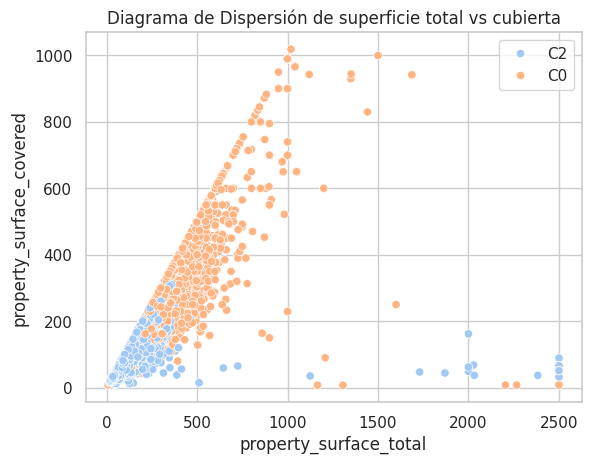

In [1041]:
# Grafico dispersograma
color = [f"C{n+1}" for n in (X["outlier_label"].values)]

sns.scatterplot(x=X["property_surface_total"], y=X["property_surface_covered"], hue=color)
plt.title("Diagrama de Dispersión de superficie total vs cubierta")
plt.show()

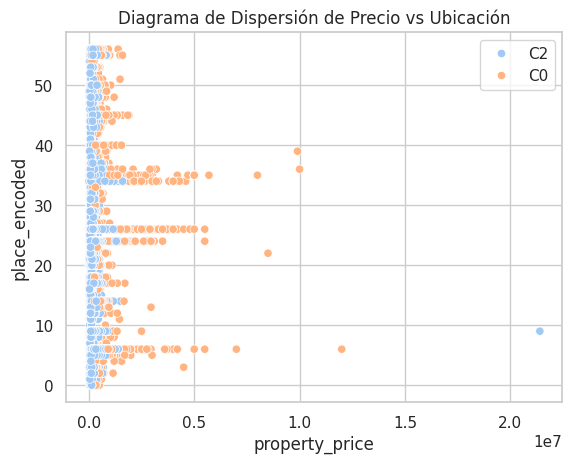

In [1042]:
sns.scatterplot(x=X["property_price"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Precio vs Ubicación")
plt.show()

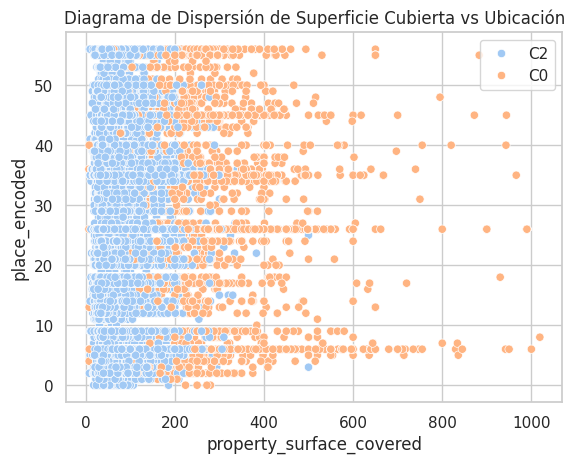

In [1043]:
sns.scatterplot(x=X["property_surface_covered"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Superficie Cubierta vs Ubicación")
plt.show()

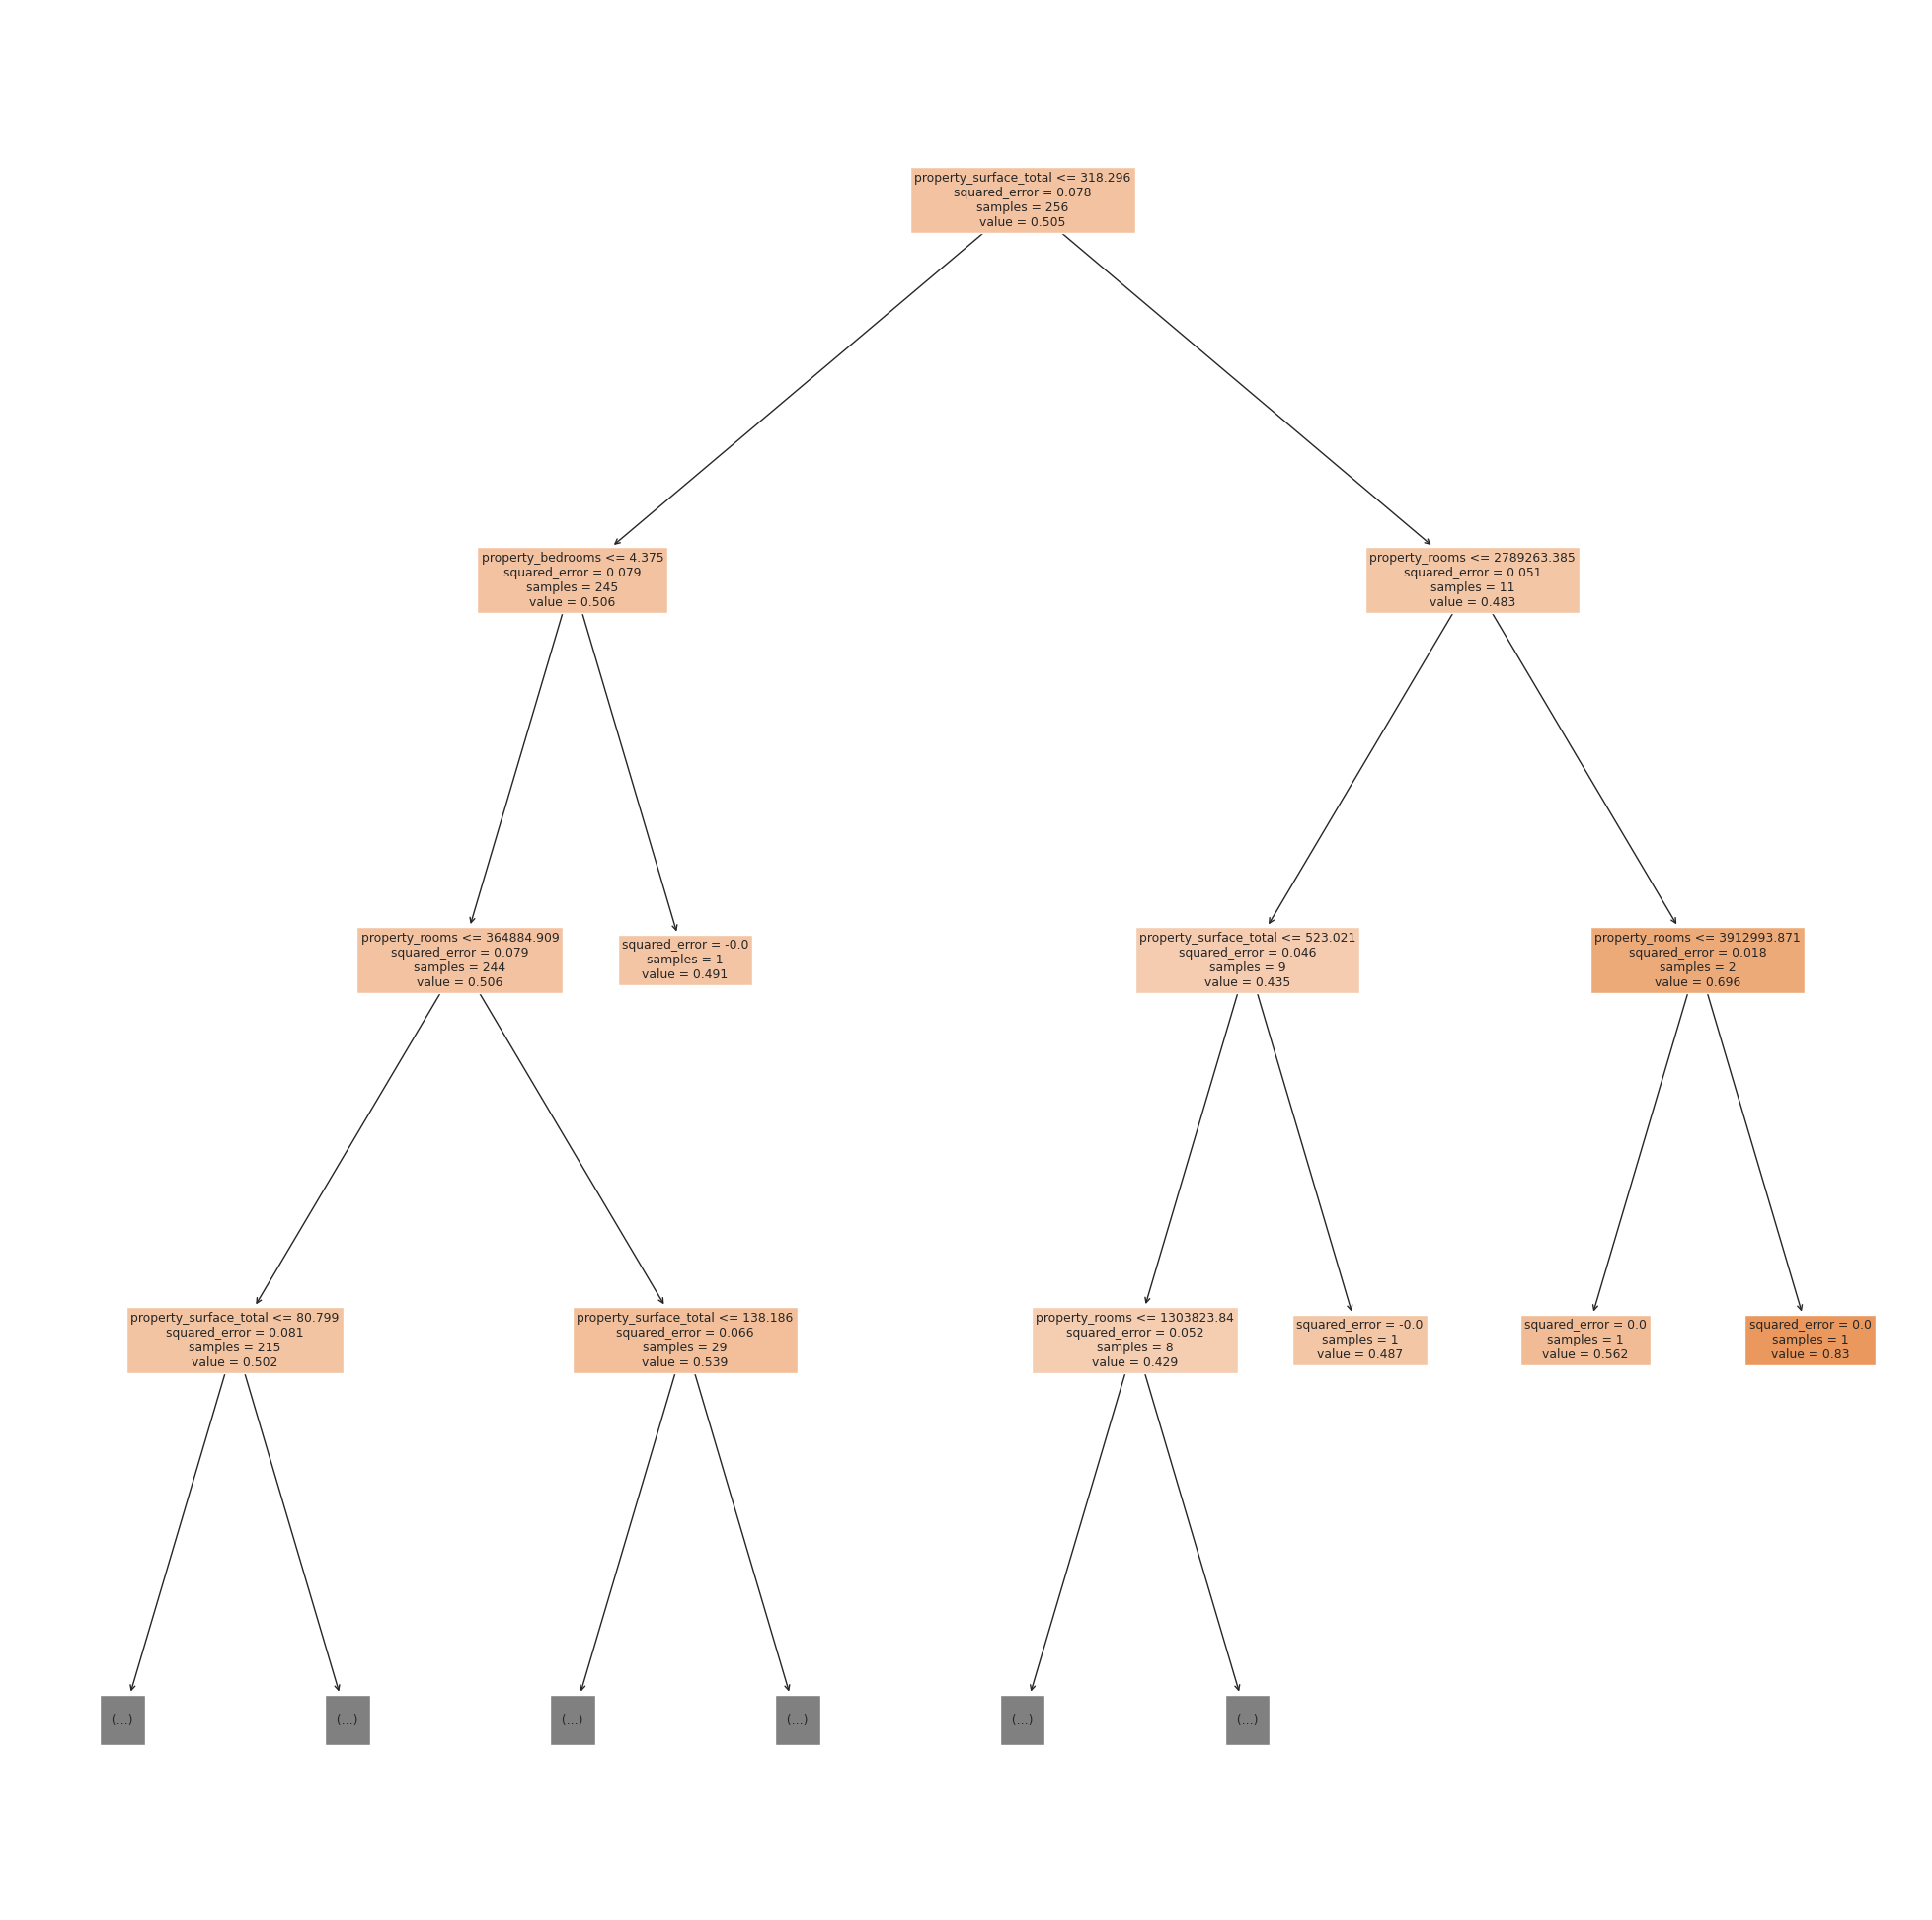

In [1044]:
# Selecciono el árbol
estimator = iforest.estimators_[5]

# Grafico
plt.figure(figsize=(25, 25))
sk.tree.plot_tree(estimator, feature_names=X.columns, filled=True, max_depth=3)
plt.show()

Revisando las anomalías y viendo los scatterplot, en su mayoría parecerían seguir las tendencias de los registros no considerados anómalos pero con valores levemente inferiores/superiores a la mediana (podría analizarse si esto es a causa de los barrios tal como se planteo anteriormente). Parecen ser anomalías genuinas y decidimos mantenerlas por contexto.

Existe un riesgo inherente en mantener los datos como estan pero de detectarse en el entrenamiento que los resultados no son los indicados se revisará esta sección.

#### **LOF**

Vamos a intentar detectar outliers multivariados usando LOF.

In [1045]:
ds_lof = ds_train.copy()

In [1046]:
ds_lof.head()

id  start_date    end_date created_on  \
285884  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18 2021-03-06   
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
419659  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09 2021-10-14   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07 2021-10-01   
103677  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
285884 -34.621390 -58.506366      Monte Castro  Departamento             3.0   
120762 -34.563005 -58.453674          Belgrano  Departamento             3.0   
419659 -34.612349 -58.491906  Villa del Parque  Departamento             3.0   
21443  -34.620806 -58.397336             Boedo            PH             3.0   
103677 -34.558229 -58.446708          Belgrano  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
285884                2.0                    51.0                      44.0   
120762                2.0                    79.0                      66.0   
419659                2.0                   110.0                      80.0   
21443                 2.0                    97.0                      67.0   
103677                2.0                    89.0                      89.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  \
285884        112000.0             0.108209              0.108209   
120762        299900.0             0.108209              0.108209   
419659        249000.0             0.108209              0.108209   
21443         135000.0             0.108209              0.108209   
103677        300000.0             0.108209              0.108209   

        place_encoded  type_encoded  
285884             23             1  
120762              6             1  
419659             56             1  
21443               8             2  
103677              6             1

In [1047]:
def lof(df, var1, var2, name):
  radius = calculo_lof(df, var1, var2, name)
  grafico_lof(df, var1, var2, name, radius)
  return


def calculo_lof(df, var1, var2, name):
  # CÁLCULO
  # Conjunto de entrenamiento
  X = df[[var1, var2]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=30)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df[name] = clf.negative_outlier_factor_

  #VISUALIZACION
  # Calculo radio para plotear score
  radius = (df[name].max() - df[name]) / (df[name].max() - df[name].min())
  return radius


def grafico_lof(df, var1, var2, name, radius):
  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)" + name)
  plt.scatter(
      df[var1].values,
      df[var2].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df[var1].values,
      df[var2].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return

Nota: Para los lof según tipo de propiedad reducimos el valor de n_neighbors a 10 ya que no se analiza el dataset entero.

In [1048]:
def lof_segun_tipo(df, var1, var2, name):

  tipos = ["Casa", "Departamento", "PH"]

  # Subplots
  fig, axs = plt.subplots(1, 3, figsize=(18, 6))

  for i, tipo in enumerate(tipos):
      filtered_data = df[df['property_type'] == tipo]

      # Check if there's any data for this property type
      if not filtered_data.empty:
          # CÁLCULO
          X = filtered_data[[var1, var2]].values
          clf = LocalOutlierFactor(n_neighbors=10)
          y_pred = clf.fit_predict(X)
          score = name + "_" + tipo
          filtered_data[score] = clf.negative_outlier_factor_

          #VISUALIZACION
          # Calculo radio para plotear score

          radius = (filtered_data[score].max() - filtered_data[score]) / (filtered_data[score].max() - filtered_data[score].min())

          # Grafico LOF
          axs[i].scatter(
              filtered_data[var1].values,
              filtered_data[var2].values,
              edgecolor="grey",
              s=30,
              label="datos",
              facecolors="none",
          )
          axs[i].scatter(
              filtered_data[var1].values,
              filtered_data[var2].values,
              s=1300 * radius,
              edgecolors="red",
              facecolors="none",
              label="Outlier scores",
          )
          legend = axs[i].legend(loc="upper left")
          legend.legendHandles[0]._sizes = [10]
          legend.legendHandles[1]._sizes = [20]

          axs[i].set_title(f'{var1}, {var2} en {tipo}')
      else:
          axs[i].set_title(f'No data for {tipo}')


  plt.tight_layout()
  plt.show()
  return


##### Superficie cubierta vs superficie total

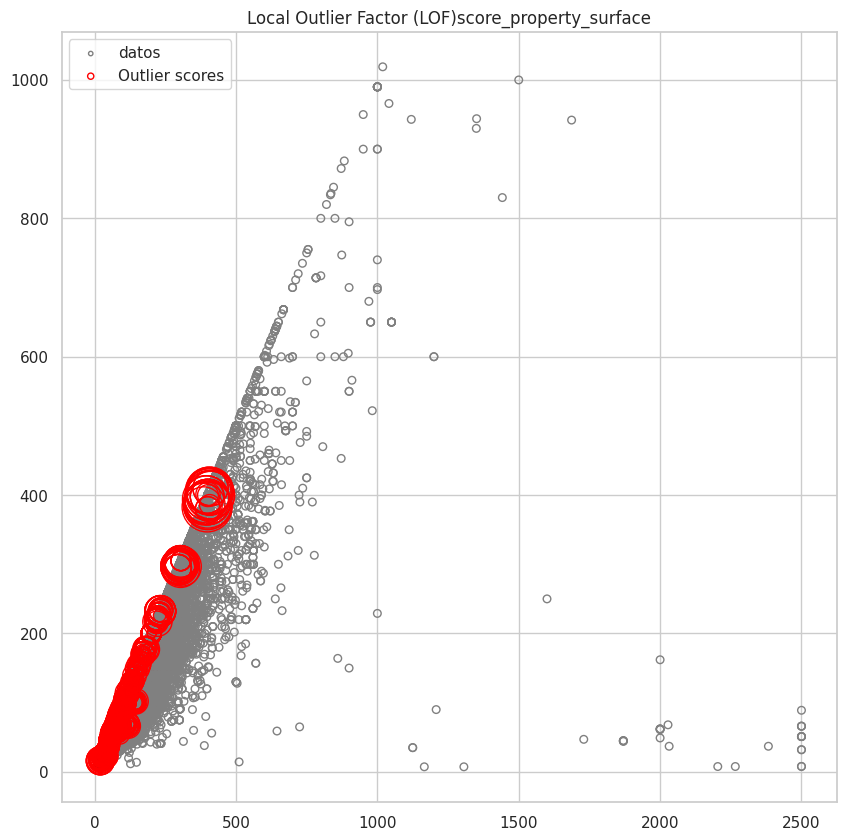

In [1049]:
lof(ds_lof, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

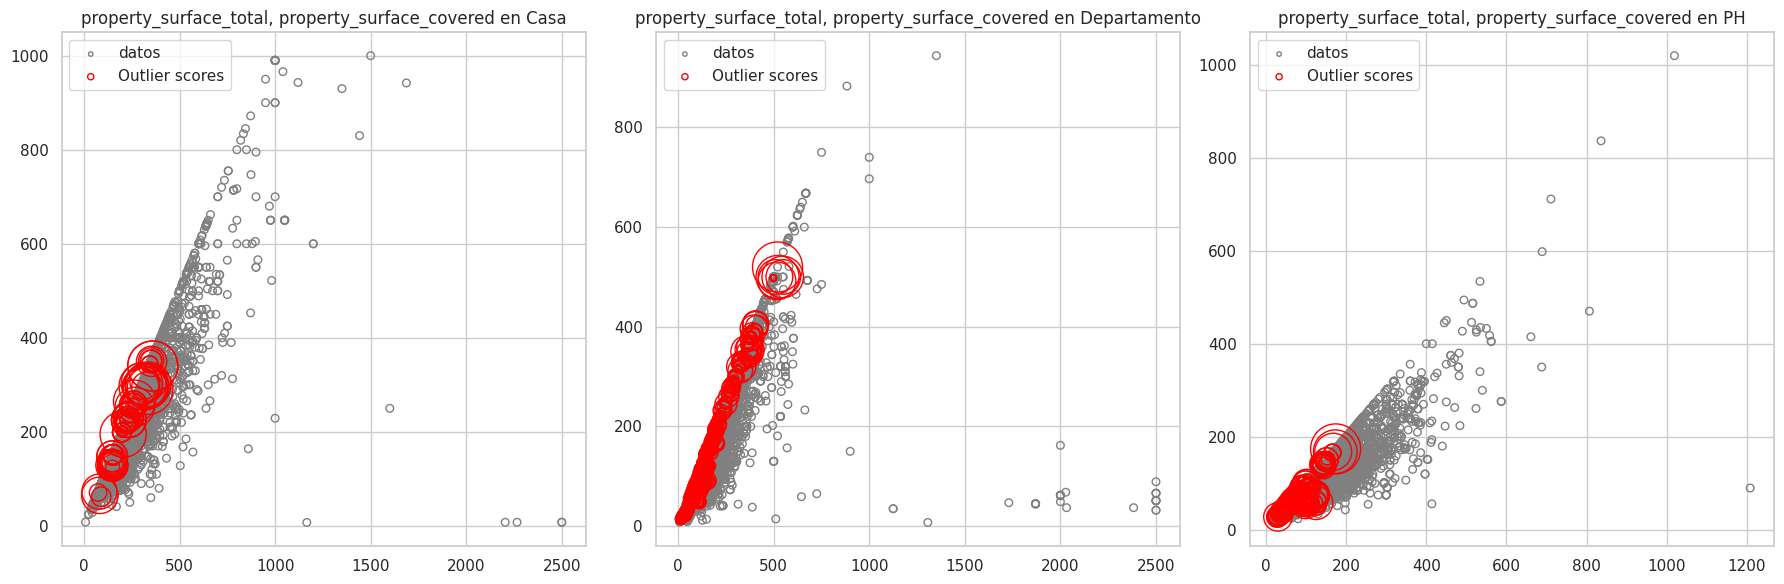

In [1050]:
lof_segun_tipo(ds_lof, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

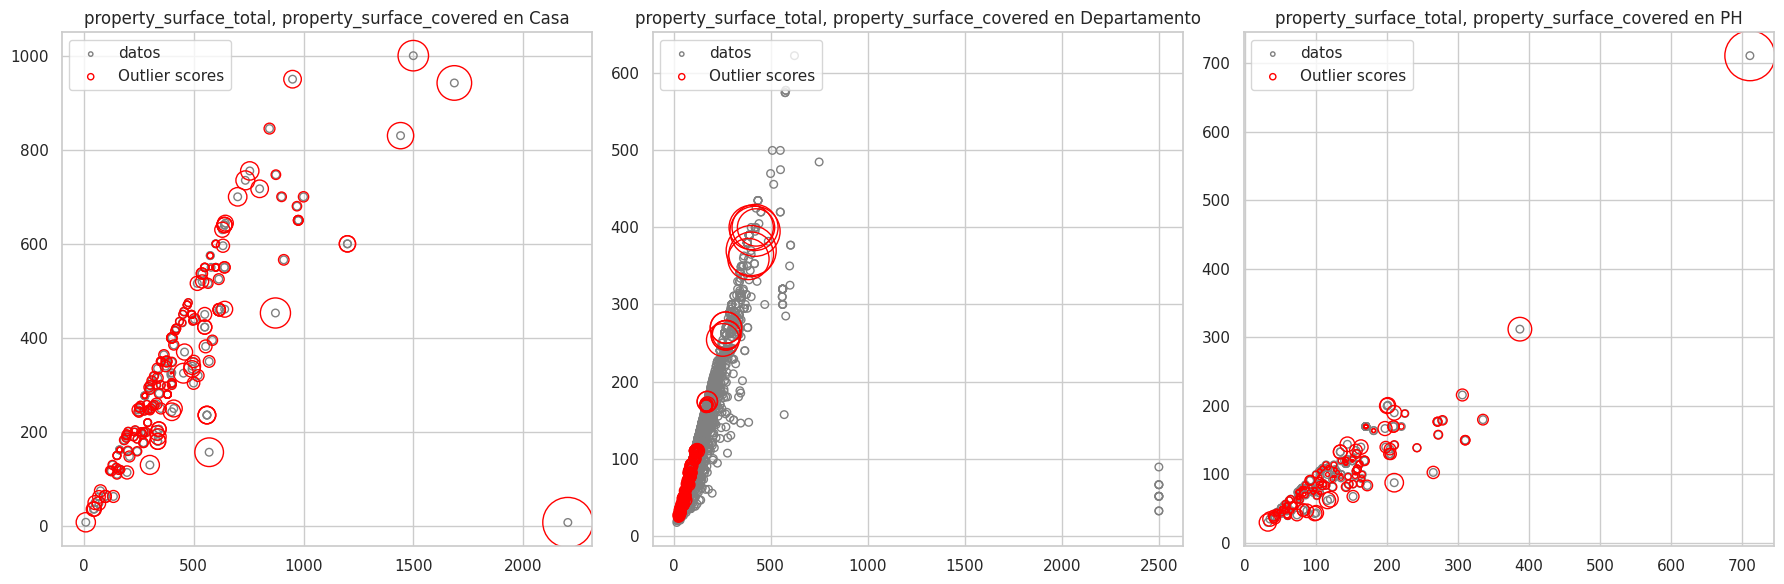

In [1051]:
lof_segun_tipo(ds_lof[(ds_lof['place_l3'] == 'Belgrano')], 'property_surface_total', 'property_surface_covered', 'score_property_surface')

Vemos como ejemplo el lof según tipo del Barrio Belgrano. Las casas son consideradas outliers casi en tu totalidad, al igual que los PHs.

In [1052]:
# Anomalias extrañas que se ven en el gráfico
ds_train[((ds_train['property_surface_covered'] < 50) & (ds_train['property_surface_total'] > 1000))]

id  start_date    end_date created_on  \
158638  IGQ5/6A5NR8BqvBjLOnyzg==  2021-09-12  2021-09-26 2021-09-12   
332190  PkbD1ixa/IWHlTjwozccRQ==  2021-09-17  2022-03-09 2021-09-17   
409283  mpNfyaVZmVoa5okuzXnf+w==  2021-03-19  2021-06-05 2021-03-19   
398823  JNGKctXXrcxIVLKQWZWijQ==  2021-02-13  2021-03-01 2021-02-13   
398750  OX8EKol2msy5QGViKBzvqw==  2021-02-13  2021-03-01 2021-02-13   
119234  pL6KQ+sejcfbfOOG9ML6eA==  2021-03-25  2021-03-26 2021-03-25   
263173  YBglCjqyN6JqZ19HsNlLcQ==  2021-02-26  2021-03-27 2021-02-26   
398822  XvIFiCvdaHyCs6hNNBeY1A==  2021-02-13  2021-03-01 2021-02-13   
165965  NzYulXk9Ddrc+qQoqAAGRw==  2021-04-30  2021-06-05 2021-04-30   
406835  7NOgqyIm3JbJyJhx1dA6jQ==  2021-01-07  2021-01-08 2021-01-07   
399657  gKg576rwUX6YvQP+opSRAg==  2021-02-13  2021-03-01 2021-02-13   
406836  qxNCvqToHSQUlDK37/3L9Q==  2021-01-07  2021-01-08 2021-01-07   
177140  KVFit7mVm+epRM497KAchw==  2021-03-23  2021-06-05 2021-03-23   
34608   g2uthf40imsD2Cuq7jQh6g==  2021-02-08  2021-03-18 2021-02-08   
406499  3yeoD8Z07TPF6qlG/flLVg==  2021-01-07  2021-01-08 2021-01-07   
2352    kQ5vw2UUa3ciFLWb0M9CEw==  2021-12-17  2022-03-25 2021-12-17   
398888  pwIwws7noE6bWYrB0u/l2w==  2021-02-13  2021-03-01 2021-02-13   
177181  q6PytfvCIgQ9xOWk3o+m1A==  2021-03-23  2021-06-05 2021-03-23   

          latitud   longitud      place_l3 property_type  property_rooms  \
158638 -34.563371 -58.455471      Belgrano  Departamento        1.000000   
332190 -34.593634 -58.377164        Retiro          Casa       10.000000   
409283 -34.599678 -58.436474       Palermo  Departamento        3.000000   
398823 -34.624845 -58.431635     Caballito  Departamento        2.000000   
398750 -34.624845 -58.431635     Caballito  Departamento        2.000000   
119234 -34.637304 -58.357534          Boca  Departamento        2.000000   
263173 -34.557749 -58.471384      Belgrano          Casa        8.000000   
398822 -34.624845 -58.431635     Caballito  Departamento        2.000000   
165965 -34.557754 -58.471497       Coghlan          Casa        3.000000   
406835 -34.611826 -58.516024  Villa Devoto  Departamento        2.000000   
399657 -34.613757 -58.523484  Villa Devoto  Departamento        1.000000   
406836 -34.613757 -58.523484  Villa Devoto  Departamento        1.000000   
177140 -34.627279 -58.373637      Barracas          Casa        2.772589   
34608  -34.611660 -58.393440     Balvanera  Departamento        2.000000   
406499 -34.563005 -58.453674      Belgrano  Departamento        1.000000   
2352   -34.584521 -58.424260       Palermo  Departamento        2.000000   
398888 -34.624845 -58.431635     Caballito  Departamento        2.000000   
177181 -34.626697 -58.373873     San Telmo          Casa        2.772589   

        property_bedrooms  property_surface_total  property_surface_covered  \
158638           1.000000                  2500.0                 32.000000   
332190           2.079442                  1166.0                  7.303170   
409283           2.000000                  1306.0                  7.300473   
398823           1.000000                  1870.0                 45.000000   
398750           1.000000                  1870.0                 45.000000   
119234           1.000000                  1730.0                 47.000000   
263173           2.079442                  2204.0                  7.698029   
398822           1.000000                  1870.0                 45.000000   
165965           2.000000                  2266.0                  7.725771   
406835           1.000000                  2000.0                 49.000000   
399657           1.000000                  1125.0                 35.000000   
406836           1.000000                  1125.0                 35.000000   
177140           2.639057                  2500.0                  7.824046   
34608            1.000000                  2383.0                 37.000000   
406499           1.000000                  2500.0 

Las anomalías parecerían ser de una combinación de imputaciones extrañas con algún error de escala no determinable. Normalizamos con sklearn.

In [1053]:
filtrado = ds_train[((ds_train['property_surface_covered'] < 50) & (ds_train['property_surface_total'] > 1000))]

# Determinamos las variables a normalizar y aplicamos MinMaxScaler
variables = filtrado[['property_surface_covered', 'property_surface_total']]
scaler = MinMaxScaler()
normalizadas = scaler.fit_transform(variables)


filtrado[['property_surface_covered', 'property_surface_total']] = normalizadas
ds_train.update(filtrado)


In [1054]:
ds_train[((ds_train['property_surface_covered'] < 50) & (ds_train['property_surface_total'] > 1000))]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms, place_encoded, type_encoded]
Index: []

##### Precio vs Superficie total

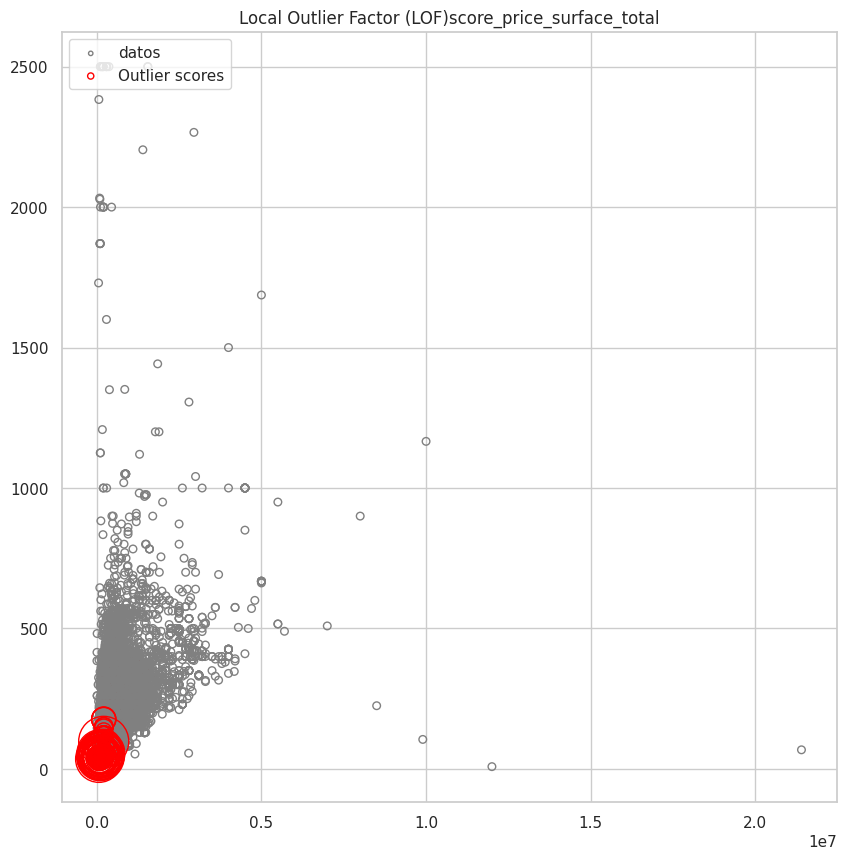

In [1055]:
lof(ds_lof, 'property_price', 'property_surface_total', 'score_price_surface_total')

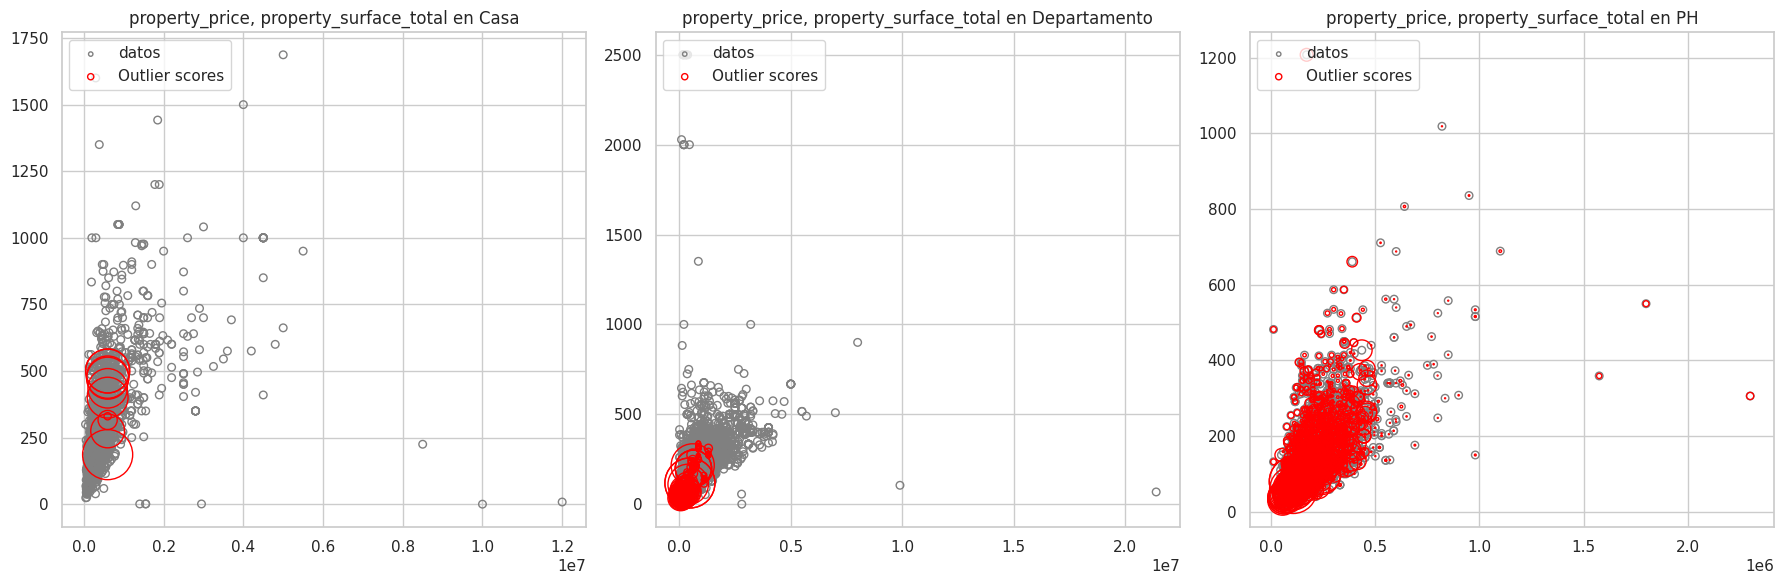

In [1056]:
lof_segun_tipo(ds_train, 'property_price', 'property_surface_total', 'score_price_surface_total')

Si bien no se detectan como anomalías por LOF, vemos algunas situaciones extrañas en el gráfico y las analizamos.

In [1057]:
# Propiedad demasiado barata para la superficie total
ds_train[((ds_train['property_price'] < 290000) & (ds_train['property_surface_total'] > 1000))]

id  start_date    end_date created_on  \
314537  z68hZQPtyGLxAbk4BXLzjA==  2021-01-06  2021-01-09 2021-01-06   
338138  w1MOQZvGtuxrsmEwmJIQ5w==  2021-04-13  2021-05-01 2021-04-13   
314739  GCATxme+VZNJyNX6WLwKuA==  2021-01-06  2021-01-09 2021-01-06   
313773  g0YOvd0iUVPj5i5/W5L67g==  2021-01-06  2021-01-09 2021-01-06   
336355  4WknGj7iBL7zrNCoaqjvVA==  2021-07-21  2021-08-08 2021-07-21   
152387  5e2B9vTi0QYTdU/nsMPrnw==  2021-08-05  2021-08-08 2021-08-05   
59206   nAlNswS6InJ4arizl/c9QQ==  2021-03-13  2021-03-16 2021-03-13   
195264  8b+CSpRNOTjFl1WESiegUg==  2021-08-21  2021-08-27 2021-08-21   
233704  xZtn7sYshWyoqpVg9tsNKw==  2021-03-20  2021-04-13 2021-03-20   
320899  adGY6/gjcj/MfuSQmZg7jw==  2021-09-03  2021-09-03 2021-09-03   
34113   TOICJnvvamy4J2bHIyfZAQ==  2021-02-08  2021-03-04 2021-02-08   

          latitud   longitud      place_l3 property_type  property_rooms  \
314537 -34.554356 -58.458076      Belgrano  Departamento             2.0   
338138 -34.611826 -58.516024  Villa Devoto  Departamento             3.0   
314739 -34.611826 -58.516024  Villa Devoto  Departamento             3.0   
313773 -34.617067 -58.513585  Villa Devoto            PH             4.0   
336355 -34.604284 -58.387255     Monserrat  Departamento             3.0   
152387 -34.611826 -58.516024  Villa Devoto  Departamento             3.0   
59206  -34.563005 -58.453674      Belgrano  Departamento             3.0   
195264 -34.554356 -58.458076      Belgrano  Departamento             2.0   
233704 -34.611826 -58.516024  Villa Devoto  Departamento             3.0   
320899 -34.554356 -58.458076      Belgrano  Departamento             2.0   
34113  -34.554356 -58.458076      Belgrano  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
314537                1.0                  2500.0                      51.0   
338138                2.0                  2000.0                      62.0   
314739                2.0                  2000.0                      62.0   
313773                2.0                  1208.0                      90.0   
336355                2.0                  2028.0                      68.0   
152387                2.0                  2000.0                      61.0   
59206                 2.0                  2500.0                      66.0   
195264                1.0                  2500.0                      51.0   
233704                2.0                  2000.0                      62.0   
320899                1.0                  2500.0                      51.0   
34113                 1.0                  2500.0                      51.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  \
314537        199000.0            -0.896877             -0.896877   
338138        204700.0             0.108209              0.108209   
314739        204700.0             0.108209              0.108209   
313773        170000.0             0.108209              0.108209   
336355         95000.0             0.108209              0.108209   
152387        189400.0             0.108209              0.108209   
59206         289500.0             0.108209              0.108209   
195264        164900.0            -0.896877             -0.896877   
233704        204700.0             0.108209              0.108209   
320899        159000.0            -0.896877             -0.896877   
34113         189850.0            -0.896877             -0.896877   

        place_encoded  type_encoded  
314537              6             1  
338138             45             1  
314739             45             1  
313773             45             2  
336355             22             1  
152387             45             1  
59206               6             1  
195264              6             1  
233704             45             1  
320899              6             1  
34113               6             1

Son casi todos casos de Departamento. Viendo las variables, el error parecería estar en la superficie y no en el precio. Normalizamos estos casos.

In [1058]:
ds_train[((ds_train['property_price'] < 290000) & (ds_train['property_surface_total'] > 1000))]

# Determinamos las variables a normalizar y aplicamos MinMaxScaler
variables = filtrado[['property_price', 'property_surface_total']]
scaler = MinMaxScaler()
normalizadas = scaler.fit_transform(variables)


filtrado[['property_price', 'property_surface_total']] = normalizadas
ds_train.update(filtrado)

In [1059]:
ds_lof.sort_values(by='score_price_surface_total', ascending=False)

id  start_date    end_date created_on  \
123318  3LpTbAlx1Z9afJMp33Ym+w==  2021-08-04  2022-05-05 2021-08-04   
168390  jymwaWFS9NizFctPXZcRQg==  2021-04-30  2021-06-05 2021-04-30   
94598   IvSpRhkqPw66/mN/3d3erg==  2021-09-24  2022-02-09 2021-09-24   
37574   NrSE21kgGEcjvL8loc0fzA==  2021-09-21  2022-02-09 2021-09-21   
329988  ITcYrReJn1GXkkQctQNvng==  2021-08-12  2022-02-09 2021-08-12   
...                          ...         ...         ...        ...   
137138  SUpsx62dVTRXTfjnmulTkA==  2021-01-22  2021-06-30 2021-01-22   
455239  fOV5F8KeXarxFMSY8t9y6w==  2021-12-16  2022-02-09 2021-12-16   
426127  9HNSOHfRvwNIh6z/tQSKLA==  2021-12-16  2022-02-09 2021-12-16   
313176  7tYLqN9qjiL5PL57EOSjxg==  2021-06-14  2021-07-07 2021-06-14   
115179  kjhveUE+S+Quextr/6MFUg==  2021-12-07  2022-01-27 2021-12-07   

          latitud   longitud             place_l3 property_type  \
123318 -34.589852 -58.436174              Palermo  Departamento   
168390 -34.584737 -58.413652         Barrio Norte  Departamento   
94598  -34.629519 -58.479869             Floresta  Departamento   
37574  -34.603323 -58.467655  Villa General Mitre            PH   
329988 -34.621833 -58.439353            Caballito  Departamento   
...           ...        ...                  ...           ...   
137138 -34.582098 -58.448859              Palermo  Departamento   
455239 -34.628923 -58.408985        San Cristobal  Departamento   
426127 -34.576273 -58.438730              Palermo  Departamento   
313176 -34.609056 -58.421322              Almagro  Departamento   
115179 -34.614531 -58.443807            Caballito            PH   

        property_rooms  property_bedrooms  property_surface_total  \
123318             4.0                3.0                    80.0   
168390             2.0                1.0                    80.0   
94598              3.0                2.0                    80.0   
37574              4.0                3.0                    80.0   
329988             3.0                2.0                    80.0   
...                ...                ...                     ...   
137138             2.0                1.0                    54.0   
455239             1.0                1.0                    35.0   
426127             2.0                1.0                    43.0   
313176             2.0                1.0                    55.0   
115179             3.0                2.0                    98.0   

        property_surface_covered  property_price  z_property_bedrooms  \
123318                      80.0        135000.0             1.113294   
168390                      55.0        135000.0            -0.896877   
94598                       74.0        135000.0             0.108209   
37574                       72.0        135000.0             1.113294   
329988                      50.0        135000.0             0.108209   
...                          ...             ...                  ...   
137138                      45.0        125212.0            -0.896877   
455239                      31.0         65200.0            -0.896877   
426127                      36.0        110500.0            -0.896877   
313176                      51.0        125400.0            -0.896877   
115179                      95.0        211500.0             0.108209   

        zm_property_bedrooms  place_encoded  type_encoded  \
123318              1.113294             26             1   
168390             -0.896877              5             1   
94598               0.108209             18             1   
37574               1.113294             46             2   
329988              0.108209              9             1   
...                      ...            ...           ...   
137138             -0.896877             26             1   
455239             -0.896877             38             1   
426127             -0.896877             26             1   
313176             -0.896877              2             

Lo que el score arrojado como LOF nos indica como outlier no parecería serlo a primera vista. Probamos igualmente

In [1060]:
umbral = -1.5
# Filtrar las filas donde el valor de 'score_price_surface_total' es menor que el umbral
ds_lof[ds_lof['score_price_surface_total'] < umbral]


id  start_date    end_date created_on  \
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
270432  8LN8u1uIzf5z/EtTbmrtuA==  2021-07-13  2022-08-11 2021-07-13   
7923    ihd0YI1jGRZdZW0fuhp9JQ==  2021-02-09  2021-07-20 2021-02-09   
79144   mrPUzlIZ8HZCQI1XZRAfMA==  2021-11-10  2022-01-27 2021-11-10   
242452  Fh1AToHtxcA7uQnAMP9JFw==  2021-04-01  2021-04-05 2021-04-01   
...                          ...         ...         ...        ...   
317537  x1BlLb49Up0aSX9yuzhrMw==  2021-09-29  2022-03-25 2021-09-29   
329691  7Vvr6tld8hQtwnf2J1gJyQ==  2021-08-12  2021-09-21 2021-08-12   
179987  Pz/CUOo7PYZ4kUH13dNSkg==  2021-02-02  9999-12-31 2021-02-02   
268902  EJ8p6gJ/c3hA2ktL034+BQ==  2021-01-19  2021-01-29 2021-01-19   
379634  Z9std/wufD6bvz2jlpr8pg==  2021-05-19  2021-06-02 2021-05-19   

          latitud   longitud         place_l3 property_type  property_rooms  \
120762 -34.563005 -58.453674         Belgrano  Departamento             3.0   
270432 -34.634941 -58.473996         Floresta  Departamento             3.0   
7923   -34.575282 -58.492324    Villa Urquiza  Departamento             2.0   
79144  -34.637531 -58.369823         Barracas  Departamento             2.0   
242452 -34.622059 -58.378334        San Telmo  Departamento             4.0   
...           ...        ...              ...           ...             ...   
317537 -34.698989 -58.469994  Villa Riachuelo  Departamento             4.0   
329691 -34.580115 -58.425652          Palermo  Departamento             1.0   
179987 -34.597173 -58.393231         Recoleta  Departamento             5.0   
268902 -34.555575 -58.438803         Belgrano  Departamento             3.0   
379634 -34.638700 -58.374163         Barracas  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
120762                2.0                    79.0                      66.0   
270432                2.0                    73.0                      67.0   
7923                  1.0                    81.0                      59.0   
79144                 1.0                    53.0                      48.0   
242452                3.0                   270.0                     117.0   
...                   ...                     ...                       ...   
317537                3.0                    91.0                      79.0   
329691                1.0                    41.0                      39.0   
179987                4.0                   300.0                     243.0   
268902                2.0                    91.0                      81.0   
379634                1.0                    43.0                      36.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  \
120762        299900.0             0.108209              0.108209   
270432        135900.0             0.108209              0.108209   
7923          133090.0            -0.896877             -0.896877   
79144         125000.0            -0.896877             -0.896877   
242452        454000.0             1.113294              1.113294   
...                ...                  ...                   ...   
317537         59900.0             1.113294              1.113294   
329691         90000.0            -0.896877             -0.896877   
179987       1370000.0             2.118379              2.118379   
268902        333000.0             0.108209              0.108209   
379634         99800.0            -0.896877             -0.896877   

        place_encoded  type_encoded  score_property_surface  \
120762              6             1               -1.000000   
270432             18             1               -1.000000   
7923               55             1               -1.059525   
79144               4             1               -1.000000   
242452             40             1               -1.503470   
...               ...           ...                     ...   
317537   

Estableciendo un umbral de -1.5, podemos ver 14166 filas consideradas 'outliers'. No solo eso, sino que a primera vista no parecerían serlo. Probamos normalizandolas y graficando a ver si encontramos alguna mejora.



In [1061]:
columnas_a_normalizar=['property_price', 'property_surface_total']
ds_lof[columnas_a_normalizar] = scaler.fit_transform(ds_lof[columnas_a_normalizar])


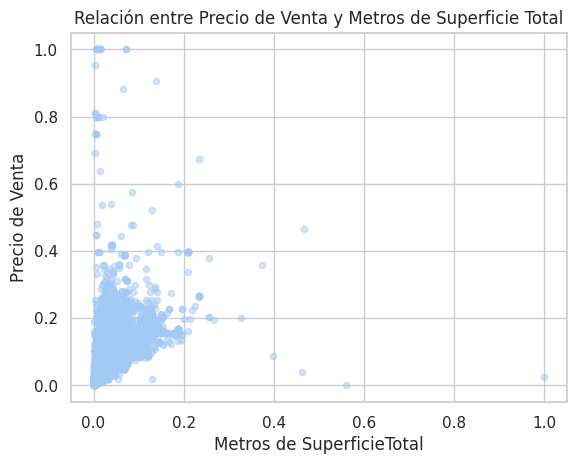

In [1062]:
ds_lof.plot.scatter(y='property_surface_total', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()


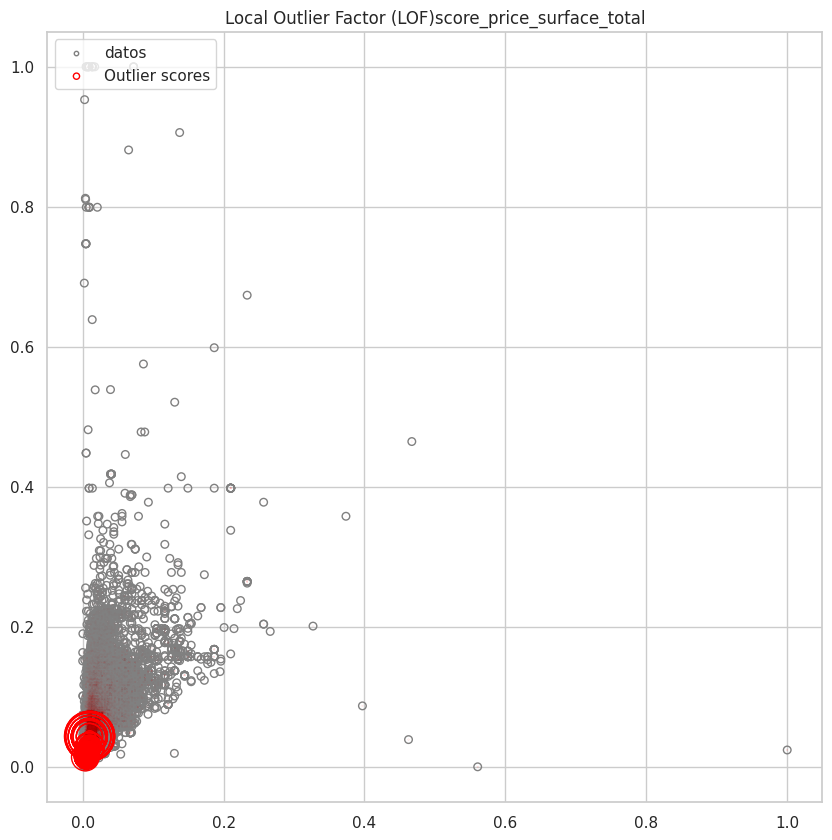

In [1063]:
lof(ds_lof, 'property_price', 'property_surface_total', 'score_price_surface_total')

No se ve una mejora notoría, sino la concentración aún más de los outliers en una ubicación que no tiene sentido. Teniendo eso en cuenta y que los datos parecen normales a simple vista, los dejaremos como estaban, excepto los casos particulares ya expuestos.

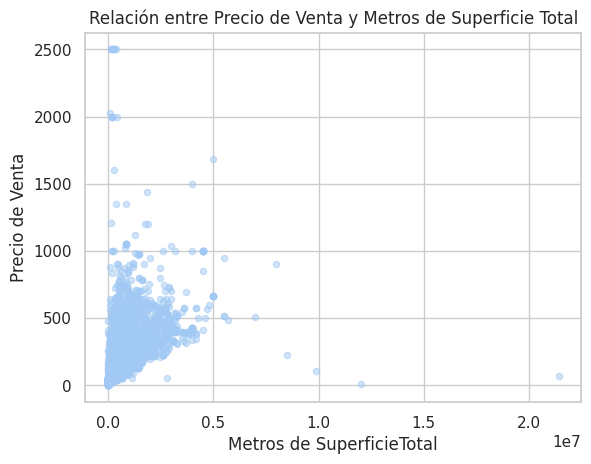

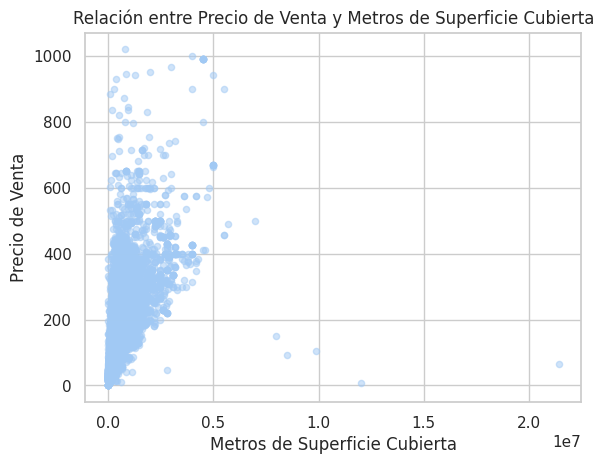

In [1064]:
ds_train.plot.scatter(y='property_surface_total', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()


ds_train.plot.scatter(y='property_surface_covered', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Cubierta')
plt.xlabel('Metros de Superficie Cubierta')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()

###### Ubicación vs Precio

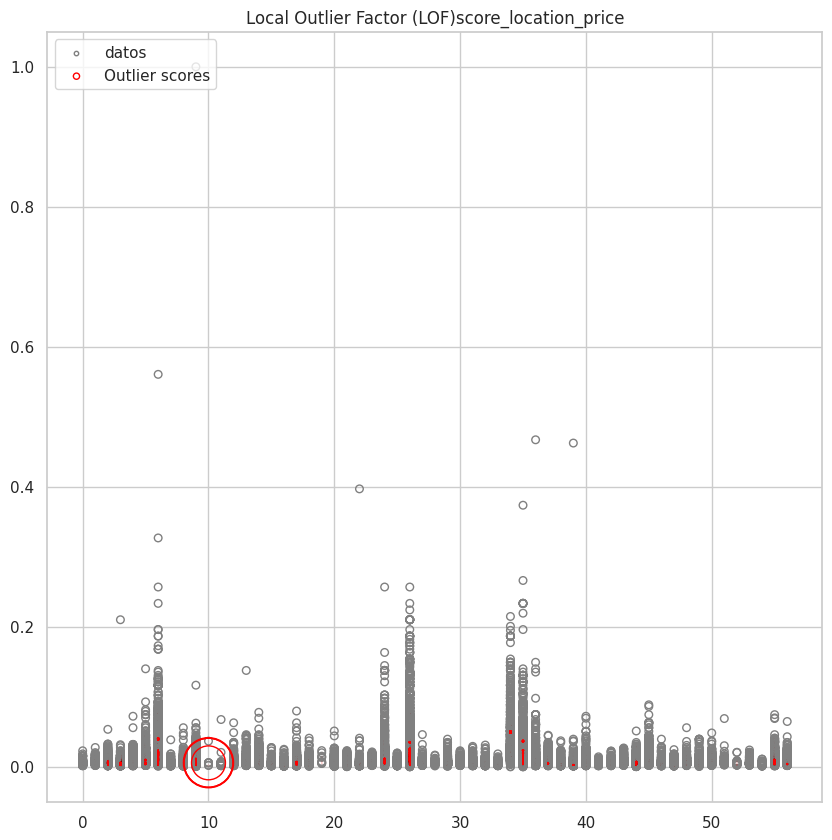

In [1065]:
lof(ds_lof, 'place_encoded', 'property_price', 'score_location_price')

### Redondeo de rooms/bedrooms

Finalmente notamos que las habitaciones y ambientes tienen un tipo de dato Float (numeros con decimales) cosa que es imposible y no representan los datos reales (no se puede tener una fraccion de habitacion). Por lo tanto arreglamos esto redondeando dichas columnas.

In [1066]:
ds_train.head()

id  start_date    end_date created_on  \
285884  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18 2021-03-06   
120762  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19 2021-05-13   
419659  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09 2021-10-14   
21443   FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07 2021-10-01   
103677  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
285884 -34.621390 -58.506366      Monte Castro  Departamento             3.0   
120762 -34.563005 -58.453674          Belgrano  Departamento             3.0   
419659 -34.612349 -58.491906  Villa del Parque  Departamento             3.0   
21443  -34.620806 -58.397336             Boedo            PH             3.0   
103677 -34.558229 -58.446708          Belgrano  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
285884                2.0                    51.0                      44.0   
120762                2.0                    79.0                      66.0   
419659                2.0                   110.0                      80.0   
21443                 2.0                    97.0                      67.0   
103677                2.0                    89.0                      89.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  \
285884        112000.0             0.108209              0.108209   
120762        299900.0             0.108209              0.108209   
419659        249000.0             0.108209              0.108209   
21443         135000.0             0.108209              0.108209   
103677        300000.0             0.108209              0.108209   

        place_encoded  type_encoded  
285884             23             1  
120762              6             1  
419659             56             1  
21443               8             2  
103677              6             1

In [1067]:
# Redondeamos rooms y bedrooms
ds_train['property_rooms'] = np.round(ds_train['property_rooms']).astype(int)
ds_train['property_bedrooms'] = np.round(ds_train['property_bedrooms']).astype(int)

# Guardado de train y test Datasets

In [1068]:
if using_drive:
  ds_train.to_csv(drive_path + "/Dataset/ds_train.csv", index=False)
  ds_test.to_csv(drive_path + "/Dataset/ds_test.csv", index=False)
else:
  ds_train.to_csv("./dataset/ds_train.csv", index=False)
  ds_test.to_csv("./dataset/ds_test.csv", index=False)